# **Necessary imports**


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform
import torch
from tqdm import tqdm
import os
import time
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import copy
from skimage import io, transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from PIL import Image
from IPython.display import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# **Exploring the dataset**


In [2]:
columns = {"name": "X", "score": "y"}
dataset = pd.read_csv("../../data/memcat.csv")
dataset.rename(columns=columns, inplace=True)

In [3]:
dataset.head()

,image,memorability_score
0,000000003481.jpg,0.561224
1,000000005745.jpg,0.790123
2,000000011552.jpg,0.721154
3,000000027439.jpg,0.807018
4,000000055601.jpg,0.813725


In [4]:
len(dataset)

10000

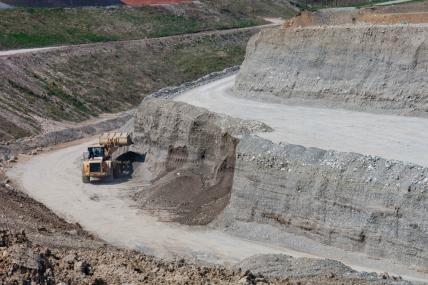

In [5]:
Image(filename="images/ac3390421ba8e3dc.jpg")

In [6]:
def split_csv(dataset):
    df = dataset
    split_percent = 0.80
    df_length = int(len(df) * split_percent)
    df1 = df.iloc[:df_length, :]
    df2 = df.iloc[df_length:, :]
    return df1, df2

In [7]:
dataset_train, dataset_validation = split_csv(dataset)

In [8]:
len(dataset_train), len(dataset_validation)

(8000, 2000)

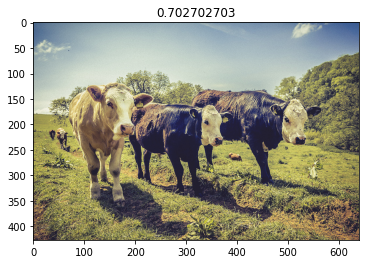

In [9]:
def show_sample_from_dataset(i=0):
    def show_image(image, asethics_value=0):
        plt.imshow(image)
        plt.title(str(asethics_value))

    image_path = "images/" + str(dataset_train.iloc[i]["image"])
    mem_value = str(dataset_train.iloc[i]["memorability_score"])
    show_image(io.imread(image_path), mem_value)


show_sample_from_dataset(300)

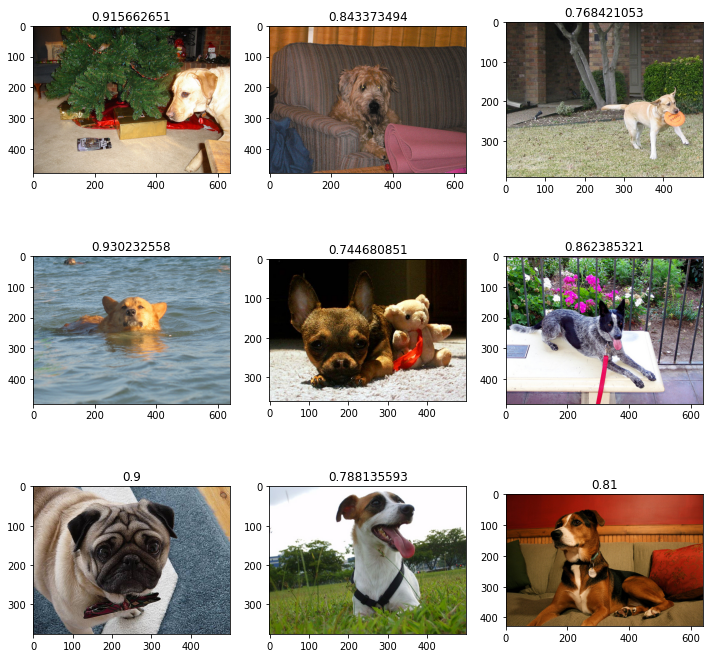

In [10]:
def show_grid(n_row, n_col):
    i = 500
    _, fig = plt.subplots(n_row, n_col, figsize=(12, 12))
    fig = fig.flatten()
    for f in fig:
        image_path = os.path.join("images/" + str(dataset_train.iloc[i]["image"]))
        mem_value = os.path.join(str(dataset_train.iloc[i]["memorability_score"]))
        f.imshow(io.imread(image_path))
        f.title.set_text(str(mem_value))
        i = i + 1


show_grid(3, 3)

# **Statistics**


In [11]:
dataset_train["memorability_score"].describe()

count    8000.000000
mean        0.758769
std         0.138828
min         0.205882
25%         0.680851
50%         0.792079
75%         0.861702
max         1.000000
Name: memorability_score, dtype: float64

In [12]:
dataset_validation["memorability_score"].describe()

count    2000.000000
mean        0.757178
std         0.094263
min         0.325843
25%         0.699003
50%         0.765957
75%         0.827444
max         0.953271
Name: memorability_score, dtype: float64

## **Data preprocessing**


In [13]:
class AsetheticsDataset(Dataset):
    """asethitics dataset"""

    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(image_name)
        mem_val = self.data.iloc[idx, 1]
        return_sample = {"image": image, "memorability_score": mem_val}
        if self.transform:
            return_sample = self.transform(return_sample)

        return return_sample

In [14]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mem_val = sample["image"], sample["memorability_score"]
        h, w = image.shape[:2]
        img = transform.resize(image, (self.output_size, self.output_size, 3))
        return {"image": img, "memorability_score": mem_val}

In [15]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mem_val = sample["image"], sample["memorability_score"]
        image = image.transpose((2, 0, 1))
        return {"image": torch.from_numpy(image), "memorability_score": mem_val}

In [16]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image, mem_val = sample["image"], sample["memorability_score"]
        normalized = (image - self.mean) / self.std
        return {"image": normalized, "memorability_score": mem_val}

In [17]:
transformed_dataset_train = AsetheticsDataset(
    dataset_train,
    root_dir="images",
    transform=transforms.Compose([Rescale(224), ToTensor(), Normalize(0.5, 0.5)]),
)
transformed_dataset_val = AsetheticsDataset(
    dataset_validation,
    root_dir="images",
    transform=transforms.Compose([Rescale(224), ToTensor(), Normalize(0.5, 0.5)]),
)

In [18]:
train_dataloader = DataLoader(transformed_dataset_train, batch_size=128, shuffle=True)
validation_dataloader = DataLoader(
    transformed_dataset_val, batch_size=128, shuffle=True
)

In [19]:
dataloaders = {"train": train_dataloader, "val": validation_dataloader}

In [20]:
dataset_sizes = {"train": len(dataset_train), "val": len(dataset_validation)}

# **ResNet50**


In [21]:
model_50 = models.resnet50("pth/resnet50-0676ba61.pth")

In [22]:
# model_50 = models.resnet50(pretrained=True)
for param in model_50.parameters():
    param.requires_grad = False

n_inputs = model_50.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_50.fc = last_layer
model_50.to(device)
print(model_50.fc.out_features)

1


In [23]:
model_50 = model_50.double()
resmodel_50 = copy.deepcopy(model_50)

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_50.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    running_loss_history = []
    val_running_loss_history = []
    orignal_model = None
    best_model_wts = copy.deepcopy(model.state_dict())
    low_loss = np.inf

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batched_data in tqdm(dataloaders[phase]):

                inputs = batched_data["image"]
                inputs = inputs.to(device)
                labels = batched_data["memorability_score"]
                labels = labels.view(-1, 1).double()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    print("  batch loss:    ", loss.item())
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == "train":
                running_loss_history.append(epoch_loss)
            else:
                val_running_loss_history.append(epoch_loss)

            print("{} Loss: {:.4f}".format(phase, epoch_loss))

            # deep copy the model
            if phase == "val" and epoch_loss < low_loss:

                print("saving best model......")
                low_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "models/resnet50_weights.pt")

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )

    # load best model weights
    original_model = copy.deepcopy(model)
    model.load_state_dict(best_model_wts)
    return model, original_model, running_loss_history, val_running_loss_history

In [26]:
epchocs_count = 25

In [27]:
best_model_50, model_50, running_loss_history, val_running_loss_history = train_model(
    model_50, criterion, optimizer, exp_lr_scheduler, epchocs_count
)

Epoch 0/24
----------


  2%|█▎                                                                                  | 1/63 [00:11<11:48, 11.43s/it]

  batch loss:     1.2219064860700302


  3%|██▋                                                                                 | 2/63 [00:23<11:45, 11.56s/it]

  batch loss:     1.0544974139078356


  5%|████                                                                                | 3/63 [00:35<11:43, 11.73s/it]

  batch loss:     0.8888043892217596


  6%|█████▎                                                                              | 4/63 [00:45<11:12, 11.40s/it]

  batch loss:     0.6470388035273038


  8%|██████▋                                                                             | 5/63 [00:57<10:57, 11.33s/it]

  batch loss:     0.5424839113453408


 10%|████████                                                                            | 6/63 [01:07<10:35, 11.15s/it]

  batch loss:     0.43219710162954117


 11%|█████████▎                                                                          | 7/63 [01:19<10:24, 11.14s/it]

  batch loss:     0.34067571110278133


 13%|██████████▋                                                                         | 8/63 [01:29<10:05, 11.00s/it]

  batch loss:     0.2630765016642074


 14%|████████████                                                                        | 9/63 [01:40<09:49, 10.92s/it]

  batch loss:     0.18932633131049442


 16%|█████████████▏                                                                     | 10/63 [01:50<09:28, 10.73s/it]

  batch loss:     0.163185041690053


 17%|██████████████▍                                                                    | 11/63 [02:01<09:17, 10.71s/it]

  batch loss:     0.10293342922123835


 19%|███████████████▊                                                                   | 12/63 [02:12<09:05, 10.69s/it]

  batch loss:     0.07749141737538154


 21%|█████████████████▏                                                                 | 13/63 [02:22<08:51, 10.64s/it]

  batch loss:     0.07219735383355384


 22%|██████████████████▍                                                                | 14/63 [02:32<08:35, 10.53s/it]

  batch loss:     0.06808590973896204


 24%|███████████████████▊                                                               | 15/63 [02:43<08:26, 10.56s/it]

  batch loss:     0.06832854125051524


 25%|█████████████████████                                                              | 16/63 [02:53<08:10, 10.43s/it]

  batch loss:     0.08098818227169968


 27%|██████████████████████▍                                                            | 17/63 [03:04<08:03, 10.50s/it]

  batch loss:     0.09453514783117972


 29%|███████████████████████▋                                                           | 18/63 [03:14<07:49, 10.42s/it]

  batch loss:     0.1071925862410346


 30%|█████████████████████████                                                          | 19/63 [03:24<07:37, 10.39s/it]

  batch loss:     0.10783916599855203


 32%|██████████████████████████▎                                                        | 20/63 [03:35<07:28, 10.43s/it]

  batch loss:     0.12027675353287574


 33%|███████████████████████████▋                                                       | 21/63 [03:45<07:16, 10.38s/it]

  batch loss:     0.14058462842374925


 35%|████████████████████████████▉                                                      | 22/63 [03:56<07:06, 10.41s/it]

  batch loss:     0.14338125977192645


 37%|██████████████████████████████▎                                                    | 23/63 [04:06<06:56, 10.42s/it]

  batch loss:     0.14934723645637388


 38%|███████████████████████████████▌                                                   | 24/63 [04:16<06:45, 10.40s/it]

  batch loss:     0.12561612817230955


 40%|████████████████████████████████▉                                                  | 25/63 [04:27<06:36, 10.44s/it]

  batch loss:     0.1329934857600163


 41%|██████████████████████████████████▎                                                | 26/63 [04:37<06:23, 10.36s/it]

  batch loss:     0.1292325670397389


 43%|███████████████████████████████████▌                                               | 27/63 [04:47<06:12, 10.35s/it]

  batch loss:     0.11474781422263039


 44%|████████████████████████████████████▉                                              | 28/63 [04:58<06:02, 10.34s/it]

  batch loss:     0.10820752080965154


 46%|██████████████████████████████████████▏                                            | 29/63 [05:08<05:50, 10.32s/it]

  batch loss:     0.0948529993240163


 48%|███████████████████████████████████████▌                                           | 30/63 [05:19<05:41, 10.36s/it]

  batch loss:     0.09758254975297817


 49%|████████████████████████████████████████▊                                          | 31/63 [05:29<05:32, 10.40s/it]

  batch loss:     0.08719940368971453


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:39<05:19, 10.31s/it]

  batch loss:     0.060300973791881915


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:49<05:09, 10.32s/it]

  batch loss:     0.0828304771648075


 54%|████████████████████████████████████████████▊                                      | 34/63 [06:00<04:59, 10.31s/it]

  batch loss:     0.0582982897893015


 56%|██████████████████████████████████████████████                                     | 35/63 [06:10<04:50, 10.38s/it]

  batch loss:     0.07495703825957575


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:20<04:38, 10.30s/it]

  batch loss:     0.0725135334632218


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:31<04:28, 10.34s/it]

  batch loss:     0.06455619777172526


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:41<04:18, 10.33s/it]

  batch loss:     0.06694957724813008


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:51<04:07, 10.31s/it]

  batch loss:     0.05473395346029796


 63%|████████████████████████████████████████████████████▋                              | 40/63 [07:02<03:57, 10.34s/it]

  batch loss:     0.0760501024874171


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:12<03:48, 10.40s/it]

  batch loss:     0.06975355409579764


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:23<03:38, 10.42s/it]

  batch loss:     0.06720193426330409


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:34<03:30, 10.51s/it]

  batch loss:     0.07700926498978522


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:44<03:20, 10.56s/it]

  batch loss:     0.06596957886751942


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:55<03:09, 10.52s/it]

  batch loss:     0.07199501042708593


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [08:05<02:58, 10.49s/it]

  batch loss:     0.07118708822496804


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:16<02:48, 10.51s/it]

  batch loss:     0.06001522599807308


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:26<02:36, 10.43s/it]

  batch loss:     0.07295733367569719


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:37<02:27, 10.51s/it]

  batch loss:     0.07894912241193716


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:47<02:16, 10.50s/it]

  batch loss:     0.067616067921797


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:58<02:05, 10.49s/it]

  batch loss:     0.06092304272571994


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:08<01:55, 10.52s/it]

  batch loss:     0.05203683863824726


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:18<01:44, 10.48s/it]

  batch loss:     0.05454517543720558


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:29<01:33, 10.43s/it]

  batch loss:     0.05876755477143956


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:39<01:22, 10.36s/it]

  batch loss:     0.06411522034195306


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:49<01:12, 10.33s/it]

  batch loss:     0.06870774435224264


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [10:00<01:01, 10.31s/it]

  batch loss:     0.058577721653189196


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:10<00:51, 10.38s/it]

  batch loss:     0.06170157582268336


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:21<00:41, 10.42s/it]

  batch loss:     0.06654057488408709


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:31<00:31, 10.38s/it]

  batch loss:     0.06340633255304812


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:41<00:20, 10.44s/it]

  batch loss:     0.059504217125220714


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:51<00:10, 10.32s/it]

  batch loss:     0.06663753260169268


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:57<00:00, 10.43s/it]


  batch loss:     0.06586482973262671
train Loss: 0.1608


  6%|█████▎                                                                              | 1/16 [00:09<02:23,  9.54s/it]

  batch loss:     0.050606484244490005


 12%|██████████▌                                                                         | 2/16 [00:18<02:11,  9.38s/it]

  batch loss:     0.06919234724592838


 19%|███████████████▊                                                                    | 3/16 [00:27<02:00,  9.26s/it]

  batch loss:     0.06367838524456035


 25%|█████████████████████                                                               | 4/16 [00:37<01:51,  9.27s/it]

  batch loss:     0.0632457159269464


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:43,  9.39s/it]

  batch loss:     0.05756796940093916


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:32,  9.29s/it]

  batch loss:     0.058301232444546935


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.23s/it]

  batch loss:     0.05153658597715931


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.28s/it]

  batch loss:     0.05900312074424317


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:05,  9.29s/it]

  batch loss:     0.057681093295334135


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.24s/it]

  batch loss:     0.056099723487979085


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.23s/it]

  batch loss:     0.06474016007253384


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:36,  9.23s/it]

  batch loss:     0.054868943968285


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.31s/it]

  batch loss:     0.05283268510394466


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:09<00:18,  9.27s/it]

  batch loss:     0.05535718587408851


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.33s/it]

  batch loss:     0.05428889516527746


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.08s/it]


  batch loss:     0.05064162945949817
val Loss: 0.0576
saving best model......

Epoch 1/24
----------


  2%|█▎                                                                                  | 1/63 [00:09<10:19,  9.99s/it]

  batch loss:     0.06861319901797441


  3%|██▋                                                                                 | 2/63 [00:20<10:33, 10.38s/it]

  batch loss:     0.06409524438679567


  5%|████                                                                                | 3/63 [00:31<10:26, 10.44s/it]

  batch loss:     0.05092093678425111


  6%|█████▎                                                                              | 4/63 [00:41<10:10, 10.34s/it]

  batch loss:     0.0492936136688736


  8%|██████▋                                                                             | 5/63 [00:51<10:04, 10.43s/it]

  batch loss:     0.0478899931164162


 10%|████████                                                                            | 6/63 [01:02<09:48, 10.33s/it]

  batch loss:     0.06909166728164691


 11%|█████████▎                                                                          | 7/63 [01:12<09:37, 10.32s/it]

  batch loss:     0.06722161847737505


 13%|██████████▋                                                                         | 8/63 [01:22<09:28, 10.34s/it]

  batch loss:     0.05216063810832991


 14%|████████████                                                                        | 9/63 [01:32<09:16, 10.30s/it]

  batch loss:     0.06582096809771124


 16%|█████████████▏                                                                     | 10/63 [01:43<09:13, 10.45s/it]

  batch loss:     0.06581294236086242


 17%|██████████████▍                                                                    | 11/63 [01:53<08:58, 10.35s/it]

  batch loss:     0.048087743703429324


 19%|███████████████▊                                                                   | 12/63 [02:04<08:46, 10.33s/it]

  batch loss:     0.05681941797885549


 21%|█████████████████▏                                                                 | 13/63 [02:14<08:42, 10.46s/it]

  batch loss:     0.06126590019888914


 22%|██████████████████▍                                                                | 14/63 [02:25<08:27, 10.36s/it]

  batch loss:     0.06352065448917979


 24%|███████████████████▊                                                               | 15/63 [02:35<08:17, 10.37s/it]

  batch loss:     0.05768179999039744


 25%|█████████████████████                                                              | 16/63 [02:45<08:06, 10.35s/it]

  batch loss:     0.05495002816838056


 27%|██████████████████████▍                                                            | 17/63 [02:55<07:53, 10.29s/it]

  batch loss:     0.07710306070783082


 29%|███████████████████████▋                                                           | 18/63 [03:06<07:49, 10.42s/it]

  batch loss:     0.05411231411127747


 30%|█████████████████████████                                                          | 19/63 [03:16<07:35, 10.35s/it]

  batch loss:     0.07410280831507164


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:23, 10.31s/it]

  batch loss:     0.061169948479864476


 33%|███████████████████████████▋                                                       | 21/63 [03:37<07:13, 10.32s/it]

  batch loss:     0.05965942692179942


 35%|████████████████████████████▉                                                      | 22/63 [03:47<06:59, 10.24s/it]

  batch loss:     0.05809063377713791


 37%|██████████████████████████████▎                                                    | 23/63 [03:58<06:55, 10.38s/it]

  batch loss:     0.06461636804520426


 38%|███████████████████████████████▌                                                   | 24/63 [04:08<06:46, 10.41s/it]

  batch loss:     0.06491744857783241


 40%|████████████████████████████████▉                                                  | 25/63 [04:18<06:35, 10.40s/it]

  batch loss:     0.04589097644570112


 41%|██████████████████████████████████▎                                                | 26/63 [04:29<06:24, 10.40s/it]

  batch loss:     0.0673882730216627


 43%|███████████████████████████████████▌                                               | 27/63 [04:39<06:15, 10.42s/it]

  batch loss:     0.0494580257043221


 44%|████████████████████████████████████▉                                              | 28/63 [04:50<06:03, 10.39s/it]

  batch loss:     0.05171629586667566


 46%|██████████████████████████████████████▏                                            | 29/63 [05:00<05:53, 10.41s/it]

  batch loss:     0.054816741921300115


 48%|███████████████████████████████████████▌                                           | 30/63 [05:11<05:43, 10.41s/it]

  batch loss:     0.04926399066724006


 49%|████████████████████████████████████████▊                                          | 31/63 [05:21<05:32, 10.38s/it]

  batch loss:     0.05096940910196554


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:31<05:22, 10.39s/it]

  batch loss:     0.05335961142297441


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:41<05:08, 10.29s/it]

  batch loss:     0.0754490299526464


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:52<05:00, 10.35s/it]

  batch loss:     0.04973879431012629


 56%|██████████████████████████████████████████████                                     | 35/63 [06:02<04:50, 10.37s/it]

  batch loss:     0.05712519595110928


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:13<04:39, 10.36s/it]

  batch loss:     0.04912058041487314


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:23<04:30, 10.39s/it]

  batch loss:     0.056622015091760285


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:33<04:18, 10.32s/it]

  batch loss:     0.05797623780940588


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:43<04:07, 10.30s/it]

  batch loss:     0.057808057579767466


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:54<03:58, 10.35s/it]

  batch loss:     0.058243900285979366


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:04<03:47, 10.33s/it]

  batch loss:     0.06236256580041615


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:15<03:38, 10.39s/it]

  batch loss:     0.04816901893508997


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:25<03:27, 10.37s/it]

  batch loss:     0.059143721961157844


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:35<03:16, 10.34s/it]

  batch loss:     0.06010293149240311


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:46<03:06, 10.38s/it]

  batch loss:     0.0503676481369312


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:56<02:55, 10.35s/it]

  batch loss:     0.05184535686715082


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:06<02:45, 10.36s/it]

  batch loss:     0.052797606993889384


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:17<02:35, 10.37s/it]

  batch loss:     0.04884344717834661


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:27<02:25, 10.37s/it]

  batch loss:     0.0531085282662392


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:37<02:13, 10.29s/it]

  batch loss:     0.05472217784420491


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:48<02:04, 10.36s/it]

  batch loss:     0.056912212168349116


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [08:58<01:54, 10.42s/it]

  batch loss:     0.044726763751449954


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:09<01:44, 10.46s/it]

  batch loss:     0.046426250649874545


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:20<01:34, 10.51s/it]

  batch loss:     0.05047598732784579


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:30<01:24, 10.51s/it]

  batch loss:     0.05444052677132168


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:40<01:13, 10.47s/it]

  batch loss:     0.05436646736064607


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:51<01:02, 10.46s/it]

  batch loss:     0.04944252277372127


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:01<00:52, 10.48s/it]

  batch loss:     0.05228455945577325


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:12<00:42, 10.54s/it]

  batch loss:     0.05741062816975494


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:23<00:31, 10.52s/it]

  batch loss:     0.04768555429607691


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:33<00:20, 10.47s/it]

  batch loss:     0.05994671888417559


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:43<00:10, 10.38s/it]

  batch loss:     0.05617281104583939


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:48<00:00, 10.30s/it]


  batch loss:     0.04847118510888028
train Loss: 0.0566


  6%|█████▎                                                                              | 1/16 [00:09<02:21,  9.43s/it]

  batch loss:     0.058216977727043845


 12%|██████████▌                                                                         | 2/16 [00:18<02:11,  9.40s/it]

  batch loss:     0.056416103524604834


 19%|███████████████▊                                                                    | 3/16 [00:27<02:00,  9.27s/it]

  batch loss:     0.05502190883889495


 25%|█████████████████████                                                               | 4/16 [00:37<01:50,  9.24s/it]

  batch loss:     0.05567062481693419


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:41,  9.23s/it]

  batch loss:     0.04809786866265468


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:32,  9.26s/it]

  batch loss:     0.055396208546903386


 44%|████████████████████████████████████▊                                               | 7/16 [01:04<01:23,  9.28s/it]

  batch loss:     0.0572062452145418


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:13,  9.22s/it]

  batch loss:     0.05516373412312799


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:04,  9.25s/it]

  batch loss:     0.05981687136678925


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.28s/it]

  batch loss:     0.05866797014813277


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.29s/it]

  batch loss:     0.05748933653617349


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:36,  9.21s/it]

  batch loss:     0.06103673098732418


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.25s/it]

  batch loss:     0.05480287274246065


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:09<00:18,  9.20s/it]

  batch loss:     0.046754082529202164


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:18<00:09,  9.22s/it]

  batch loss:     0.056781161057375254


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:24<00:00,  9.05s/it]


  batch loss:     0.037326912478145714
val Loss: 0.0550
saving best model......

Epoch 2/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:38, 10.29s/it]

  batch loss:     0.059717154305043776


  3%|██▋                                                                                 | 2/63 [00:20<10:25, 10.26s/it]

  batch loss:     0.05883573866115769


  5%|████                                                                                | 3/63 [00:30<10:19, 10.33s/it]

  batch loss:     0.05224292453078965


  6%|█████▎                                                                              | 4/63 [00:41<10:12, 10.38s/it]

  batch loss:     0.04143411041082304


  8%|██████▋                                                                             | 5/63 [00:51<10:01, 10.38s/it]

  batch loss:     0.05229969759235179


 10%|████████                                                                            | 6/63 [01:02<09:54, 10.42s/it]

  batch loss:     0.04676734113120393


 11%|█████████▎                                                                          | 7/63 [01:12<09:43, 10.43s/it]

  batch loss:     0.0446824640558596


 13%|██████████▋                                                                         | 8/63 [01:23<09:32, 10.40s/it]

  batch loss:     0.05711649647954989


 14%|████████████                                                                        | 9/63 [01:33<09:21, 10.40s/it]

  batch loss:     0.05079922933413088


 16%|█████████████▏                                                                     | 10/63 [01:43<09:10, 10.38s/it]

  batch loss:     0.04340310317479143


 17%|██████████████▍                                                                    | 11/63 [01:54<09:05, 10.49s/it]

  batch loss:     0.042938121721790276


 19%|███████████████▊                                                                   | 12/63 [02:04<08:47, 10.34s/it]

  batch loss:     0.05646484123905572


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:39, 10.38s/it]

  batch loss:     0.04857846845675419


 22%|██████████████████▍                                                                | 14/63 [02:25<08:24, 10.29s/it]

  batch loss:     0.04633602330236466


 24%|███████████████████▊                                                               | 15/63 [02:35<08:16, 10.35s/it]

  batch loss:     0.05748906909844069


 25%|█████████████████████                                                              | 16/63 [02:45<08:03, 10.29s/it]

  batch loss:     0.043941681019385385


 27%|██████████████████████▍                                                            | 17/63 [02:56<07:54, 10.31s/it]

  batch loss:     0.06466123523655093


 29%|███████████████████████▋                                                           | 18/63 [03:06<07:44, 10.31s/it]

  batch loss:     0.04768798197773536


 30%|█████████████████████████                                                          | 19/63 [03:16<07:33, 10.32s/it]

  batch loss:     0.03907782361614283


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:26, 10.38s/it]

  batch loss:     0.0469639086793326


 33%|███████████████████████████▋                                                       | 21/63 [03:37<07:13, 10.31s/it]

  batch loss:     0.04525153657277223


 35%|████████████████████████████▉                                                      | 22/63 [03:47<07:05, 10.39s/it]

  batch loss:     0.05303901448538978


 37%|██████████████████████████████▎                                                    | 23/63 [03:58<06:51, 10.28s/it]

  batch loss:     0.04468082189262295


 38%|███████████████████████████████▌                                                   | 24/63 [04:08<06:43, 10.34s/it]

  batch loss:     0.05501483556641797


 40%|████████████████████████████████▉                                                  | 25/63 [04:19<06:34, 10.39s/it]

  batch loss:     0.049317947345444084


 41%|██████████████████████████████████▎                                                | 26/63 [04:29<06:23, 10.37s/it]

  batch loss:     0.05895605675961225


 43%|███████████████████████████████████▌                                               | 27/63 [04:39<06:14, 10.40s/it]

  batch loss:     0.04648343306026553


 44%|████████████████████████████████████▉                                              | 28/63 [04:49<06:00, 10.31s/it]

  batch loss:     0.04930601587868101


 46%|██████████████████████████████████████▏                                            | 29/63 [05:00<05:50, 10.31s/it]

  batch loss:     0.04770494520691956


 48%|███████████████████████████████████████▌                                           | 30/63 [05:10<05:41, 10.33s/it]

  batch loss:     0.04803281066369186


 49%|████████████████████████████████████████▊                                          | 31/63 [05:20<05:28, 10.27s/it]

  batch loss:     0.04430944750944066


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:31<05:19, 10.31s/it]

  batch loss:     0.04218798228946628


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:41<05:07, 10.26s/it]

  batch loss:     0.059219572624355565


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:51<04:58, 10.29s/it]

  batch loss:     0.04773458871278238


 56%|██████████████████████████████████████████████                                     | 35/63 [06:01<04:46, 10.25s/it]

  batch loss:     0.04561478509520106


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:11<04:36, 10.22s/it]

  batch loss:     0.05042952743466741


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:22<04:26, 10.24s/it]

  batch loss:     0.039145825046895226


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:32<04:16, 10.25s/it]

  batch loss:     0.038023518581732446


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:42<04:07, 10.30s/it]

  batch loss:     0.05764663979063288


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:52<03:55, 10.22s/it]

  batch loss:     0.04766745008085342


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:03<03:47, 10.34s/it]

  batch loss:     0.05289405249553983


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:13<03:35, 10.27s/it]

  batch loss:     0.042641454696912426


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:24<03:26, 10.34s/it]

  batch loss:     0.040756155196437216


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:34<03:15, 10.31s/it]

  batch loss:     0.04128720694768598


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:44<03:05, 10.32s/it]

  batch loss:     0.04900172845712962


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:55<02:58, 10.48s/it]

  batch loss:     0.041929134540332716


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:06<02:48, 10.52s/it]

  batch loss:     0.041443709005298174


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:16<02:36, 10.43s/it]

  batch loss:     0.041942106686299545


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:27<02:26, 10.49s/it]

  batch loss:     0.046135581039779654


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:37<02:16, 10.47s/it]

  batch loss:     0.048798152679393206


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:47<02:04, 10.39s/it]

  batch loss:     0.051811694375660425


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [08:58<01:54, 10.42s/it]

  batch loss:     0.050557164087746125


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:08<01:43, 10.33s/it]

  batch loss:     0.045771197827753435


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:18<01:33, 10.40s/it]

  batch loss:     0.04400148043671339


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:29<01:23, 10.41s/it]

  batch loss:     0.05114747494276001


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:39<01:12, 10.41s/it]

  batch loss:     0.049957985888481896


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:50<01:02, 10.49s/it]

  batch loss:     0.05729502117276366


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:00<00:52, 10.52s/it]

  batch loss:     0.048340502574554835


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:11<00:41, 10.49s/it]

  batch loss:     0.04180241658406434


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:21<00:31, 10.48s/it]

  batch loss:     0.04546146541811361


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:32<00:20, 10.39s/it]

  batch loss:     0.05162485647961476


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:42<00:10, 10.38s/it]

  batch loss:     0.03913587904911757


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:47<00:00, 10.28s/it]


  batch loss:     0.04291393600989194
train Loss: 0.0483


  6%|█████▎                                                                              | 1/16 [00:09<02:19,  9.32s/it]

  batch loss:     0.0500505583468224


 12%|██████████▌                                                                         | 2/16 [00:18<02:11,  9.36s/it]

  batch loss:     0.048464641278408604


 19%|███████████████▊                                                                    | 3/16 [00:28<02:01,  9.38s/it]

  batch loss:     0.050011983362546863


 25%|█████████████████████                                                               | 4/16 [00:37<01:51,  9.30s/it]

  batch loss:     0.04201669500040473


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.33s/it]

  batch loss:     0.04533337310211546


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:34,  9.42s/it]

  batch loss:     0.05402445979060348


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.32s/it]

  batch loss:     0.0543821463349169


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.34s/it]

  batch loss:     0.04347128521779259


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:04,  9.28s/it]

  batch loss:     0.05059127109785907


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:33<00:55,  9.26s/it]

  batch loss:     0.04660745965288367


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.28s/it]

  batch loss:     0.0543907154996426


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.25s/it]

  batch loss:     0.0543328801102974


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:01<00:27,  9.29s/it]

  batch loss:     0.05445261961122254


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.37s/it]

  batch loss:     0.05068858554215488


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.28s/it]

  batch loss:     0.05109308605299966


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.10s/it]


  batch loss:     0.0513077531387275
val Loss: 0.0500
saving best model......

Epoch 3/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:41, 10.34s/it]

  batch loss:     0.045255724105708085


  3%|██▋                                                                                 | 2/63 [00:20<10:34, 10.40s/it]

  batch loss:     0.04527024543338532


  5%|████                                                                                | 3/63 [00:31<10:27, 10.45s/it]

  batch loss:     0.039965743067389495


  6%|█████▎                                                                              | 4/63 [00:41<10:12, 10.38s/it]

  batch loss:     0.04276182680135139


  8%|██████▋                                                                             | 5/63 [00:52<10:03, 10.41s/it]

  batch loss:     0.042207153138637085


 10%|████████                                                                            | 6/63 [01:02<09:56, 10.46s/it]

  batch loss:     0.04395945985293566


 11%|█████████▎                                                                          | 7/63 [01:12<09:40, 10.37s/it]

  batch loss:     0.04188048979154941


 13%|██████████▋                                                                         | 8/63 [01:23<09:29, 10.35s/it]

  batch loss:     0.046476897853273316


 14%|████████████                                                                        | 9/63 [01:33<09:20, 10.38s/it]

  batch loss:     0.038429852640318646


 16%|█████████████▏                                                                     | 10/63 [01:43<09:08, 10.35s/it]

  batch loss:     0.05137057849713094


 17%|██████████████▍                                                                    | 11/63 [01:53<08:53, 10.27s/it]

  batch loss:     0.04288160470827306


 19%|███████████████▊                                                                   | 12/63 [02:04<08:48, 10.36s/it]

  batch loss:     0.04703024291351747


 21%|█████████████████▏                                                                 | 13/63 [02:14<08:37, 10.36s/it]

  batch loss:     0.03941415355399744


 22%|██████████████████▍                                                                | 14/63 [02:25<08:28, 10.37s/it]

  batch loss:     0.047798482349790616


 24%|███████████████████▊                                                               | 15/63 [02:35<08:19, 10.40s/it]

  batch loss:     0.036003806326949814


 25%|█████████████████████                                                              | 16/63 [02:46<08:10, 10.43s/it]

  batch loss:     0.04345927035004446


 27%|██████████████████████▍                                                            | 17/63 [02:56<07:59, 10.43s/it]

  batch loss:     0.04141082181643225


 29%|███████████████████████▋                                                           | 18/63 [03:06<07:48, 10.41s/it]

  batch loss:     0.05131167903313985


 30%|█████████████████████████                                                          | 19/63 [03:17<07:40, 10.47s/it]

  batch loss:     0.048320787527166044


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:24, 10.34s/it]

  batch loss:     0.03945018759832902


 33%|███████████████████████████▋                                                       | 21/63 [03:38<07:16, 10.40s/it]

  batch loss:     0.03490431949350557


 35%|████████████████████████████▉                                                      | 22/63 [03:48<07:05, 10.38s/it]

  batch loss:     0.045370960696968526


 37%|██████████████████████████████▎                                                    | 23/63 [03:58<06:52, 10.31s/it]

  batch loss:     0.047052724653076215


 38%|███████████████████████████████▌                                                   | 24/63 [04:09<06:46, 10.41s/it]

  batch loss:     0.04181519822557483


 40%|████████████████████████████████▉                                                  | 25/63 [04:19<06:35, 10.40s/it]

  batch loss:     0.03875333102653842


 41%|██████████████████████████████████▎                                                | 26/63 [04:29<06:22, 10.35s/it]

  batch loss:     0.04691232997959286


 43%|███████████████████████████████████▌                                               | 27/63 [04:40<06:12, 10.35s/it]

  batch loss:     0.028732960452174668


 44%|████████████████████████████████████▉                                              | 28/63 [04:50<06:00, 10.31s/it]

  batch loss:     0.046298763460659975


 46%|██████████████████████████████████████▏                                            | 29/63 [05:01<05:53, 10.39s/it]

  batch loss:     0.03957382472305339


 48%|███████████████████████████████████████▌                                           | 30/63 [05:11<05:45, 10.47s/it]

  batch loss:     0.05111979800967361


 49%|████████████████████████████████████████▊                                          | 31/63 [05:21<05:31, 10.37s/it]

  batch loss:     0.04220607406028053


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:32<05:23, 10.43s/it]

  batch loss:     0.04387031521209074


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:42<05:12, 10.41s/it]

  batch loss:     0.05120526102206314


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:52<04:59, 10.33s/it]

  batch loss:     0.03379817178701157


 56%|██████████████████████████████████████████████                                     | 35/63 [06:03<04:52, 10.45s/it]

  batch loss:     0.03747887312045744


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:14<04:42, 10.45s/it]

  batch loss:     0.039181524507877555


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:24<04:30, 10.40s/it]

  batch loss:     0.031876229669603975


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:34<04:19, 10.36s/it]

  batch loss:     0.05458731263539518


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:44<04:07, 10.33s/it]

  batch loss:     0.038613215578159235


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:55<03:57, 10.32s/it]

  batch loss:     0.03989259553810669


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:05<03:45, 10.25s/it]

  batch loss:     0.033830010224319085


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:15<03:36, 10.31s/it]

  batch loss:     0.042541580400901634


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:26<03:25, 10.30s/it]

  batch loss:     0.03663749753838189


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:36<03:16, 10.34s/it]

  batch loss:     0.047583838306006467


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:46<03:06, 10.37s/it]

  batch loss:     0.031573485914657355


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:57<02:57, 10.46s/it]

  batch loss:     0.045940643042823026


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:07<02:45, 10.36s/it]

  batch loss:     0.03861204350322921


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:18<02:35, 10.39s/it]

  batch loss:     0.04225966585738419


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:28<02:24, 10.34s/it]

  batch loss:     0.0592282883653351


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:38<02:14, 10.34s/it]

  batch loss:     0.03268898651417455


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:49<02:04, 10.37s/it]

  batch loss:     0.04442732567093914


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [08:59<01:53, 10.36s/it]

  batch loss:     0.036075805068885435


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:10<01:44, 10.43s/it]

  batch loss:     0.039867115139284336


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:20<01:33, 10.35s/it]

  batch loss:     0.035287466795389445


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:30<01:22, 10.35s/it]

  batch loss:     0.03620278381337034


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:41<01:12, 10.42s/it]

  batch loss:     0.04379160172112598


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:51<01:02, 10.36s/it]

  batch loss:     0.036492675845595186


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:01<00:51, 10.34s/it]

  batch loss:     0.04638537611404561


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:12<00:41, 10.38s/it]

  batch loss:     0.04550230847805883


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:22<00:31, 10.36s/it]

  batch loss:     0.03327697770434104


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:32<00:20, 10.40s/it]

  batch loss:     0.03731289934430371


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:43<00:10, 10.50s/it]

  batch loss:     0.029137780632753043


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:49<00:00, 10.30s/it]


  batch loss:     0.046749929655245714
train Loss: 0.0417


  6%|█████▎                                                                              | 1/16 [00:09<02:21,  9.40s/it]

  batch loss:     0.049287953424463654


 12%|██████████▌                                                                         | 2/16 [00:18<02:10,  9.35s/it]

  batch loss:     0.046548901588161315


 19%|███████████████▊                                                                    | 3/16 [00:28<02:01,  9.36s/it]

  batch loss:     0.04523793481589716


 25%|█████████████████████                                                               | 4/16 [00:37<01:52,  9.41s/it]

  batch loss:     0.04917952592998876


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:43,  9.37s/it]

  batch loss:     0.05305564088482781


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:32,  9.30s/it]

  batch loss:     0.05721212119148307


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.33s/it]

  batch loss:     0.044859865633706905


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.27s/it]

  batch loss:     0.04541005768931958


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:05,  9.29s/it]

  batch loss:     0.04282226573269735


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:33<00:55,  9.30s/it]

  batch loss:     0.04941445750884577


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.21s/it]

  batch loss:     0.05424768465096763


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.35s/it]

  batch loss:     0.041043743645775524


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:01<00:28,  9.40s/it]

  batch loss:     0.047998871832601875


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.31s/it]

  batch loss:     0.054057140358133804


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.34s/it]

  batch loss:     0.04890426074721417


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.11s/it]


  batch loss:     0.035884305410435045
val Loss: 0.0481
saving best model......

Epoch 4/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:47, 10.45s/it]

  batch loss:     0.02787449463305544


  3%|██▋                                                                                 | 2/63 [00:20<10:40, 10.49s/it]

  batch loss:     0.05623172528272622


  5%|████                                                                                | 3/63 [00:31<10:30, 10.51s/it]

  batch loss:     0.04804612639008101


  6%|█████▎                                                                              | 4/63 [00:42<10:22, 10.55s/it]

  batch loss:     0.04252377365218387


  8%|██████▋                                                                             | 5/63 [00:52<10:12, 10.57s/it]

  batch loss:     0.03703411182900489


 10%|████████                                                                            | 6/63 [01:03<09:59, 10.51s/it]

  batch loss:     0.03330374302971613


 11%|█████████▎                                                                          | 7/63 [01:13<09:42, 10.40s/it]

  batch loss:     0.03810610241420512


 13%|██████████▋                                                                         | 8/63 [01:23<09:32, 10.41s/it]

  batch loss:     0.043241887484930366


 14%|████████████                                                                        | 9/63 [01:34<09:21, 10.40s/it]

  batch loss:     0.03840687417159741


 16%|█████████████▏                                                                     | 10/63 [01:44<09:11, 10.41s/it]

  batch loss:     0.0377183946442913


 17%|██████████████▍                                                                    | 11/63 [01:54<08:57, 10.34s/it]

  batch loss:     0.03778928768686843


 19%|███████████████▊                                                                   | 12/63 [02:05<08:48, 10.35s/it]

  batch loss:     0.04335365334809836


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:38, 10.36s/it]

  batch loss:     0.034529556531349925


 22%|██████████████████▍                                                                | 14/63 [02:25<08:24, 10.30s/it]

  batch loss:     0.02851623790702


 24%|███████████████████▊                                                               | 15/63 [02:36<08:17, 10.37s/it]

  batch loss:     0.04351947195269883


 25%|█████████████████████                                                              | 16/63 [02:46<08:05, 10.33s/it]

  batch loss:     0.028913223261493617


 27%|██████████████████████▍                                                            | 17/63 [02:56<07:54, 10.32s/it]

  batch loss:     0.036714626378893486


 29%|███████████████████████▋                                                           | 18/63 [03:07<07:51, 10.47s/it]

  batch loss:     0.032310945690739945


 30%|█████████████████████████                                                          | 19/63 [03:17<07:36, 10.37s/it]

  batch loss:     0.03819436586138228


 32%|██████████████████████████▎                                                        | 20/63 [03:28<07:26, 10.38s/it]

  batch loss:     0.03284902508401576


 33%|███████████████████████████▋                                                       | 21/63 [03:38<07:16, 10.40s/it]

  batch loss:     0.033688176955254806


 35%|████████████████████████████▉                                                      | 22/63 [03:48<07:05, 10.37s/it]

  batch loss:     0.04237217560952376


 37%|██████████████████████████████▎                                                    | 23/63 [03:59<06:56, 10.42s/it]

  batch loss:     0.033131196665098867


 38%|███████████████████████████████▌                                                   | 24/63 [04:09<06:47, 10.44s/it]

  batch loss:     0.0382536091244628


 40%|████████████████████████████████▉                                                  | 25/63 [04:20<06:38, 10.49s/it]

  batch loss:     0.04004350582810738


 41%|██████████████████████████████████▎                                                | 26/63 [04:30<06:26, 10.46s/it]

  batch loss:     0.02594007190208318


 43%|███████████████████████████████████▌                                               | 27/63 [04:41<06:15, 10.44s/it]

  batch loss:     0.029092125089412686


 44%|████████████████████████████████████▉                                              | 28/63 [04:51<06:06, 10.46s/it]

  batch loss:     0.028351423313182873


 46%|██████████████████████████████████████▏                                            | 29/63 [05:02<05:54, 10.42s/it]

  batch loss:     0.03391213904106635


 48%|███████████████████████████████████████▌                                           | 30/63 [05:12<05:44, 10.44s/it]

  batch loss:     0.036151025543104814


 49%|████████████████████████████████████████▊                                          | 31/63 [05:22<05:31, 10.36s/it]

  batch loss:     0.04496179732706098


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:33<05:23, 10.43s/it]

  batch loss:     0.04046883748253845


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:43<05:12, 10.41s/it]

  batch loss:     0.03306174050500894


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:53<05:00, 10.35s/it]

  batch loss:     0.03876194381278544


 56%|██████████████████████████████████████████████                                     | 35/63 [06:04<04:49, 10.36s/it]

  batch loss:     0.026256902462520677


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:14<04:38, 10.31s/it]

  batch loss:     0.02792020109451081


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:25<04:30, 10.40s/it]

  batch loss:     0.041090417279647


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:35<04:17, 10.32s/it]

  batch loss:     0.03278401890789659


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:45<04:08, 10.36s/it]

  batch loss:     0.03793182288407848


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:55<03:57, 10.33s/it]

  batch loss:     0.03831733246390945


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:06<03:47, 10.35s/it]

  batch loss:     0.03512814630941495


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:16<03:38, 10.42s/it]

  batch loss:     0.03776508231811969


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:27<03:28, 10.45s/it]

  batch loss:     0.02998270550130534


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:37<03:17, 10.40s/it]

  batch loss:     0.02914585673133591


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:48<03:07, 10.43s/it]

  batch loss:     0.038322653648438516


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:58<02:56, 10.38s/it]

  batch loss:     0.03675394265048869


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:08<02:45, 10.36s/it]

  batch loss:     0.038134157909816765


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:19<02:34, 10.32s/it]

  batch loss:     0.04120843757375219


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:29<02:24, 10.33s/it]

  batch loss:     0.03365348968578026


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:39<02:15, 10.42s/it]

  batch loss:     0.03740133081693714


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:50<02:04, 10.41s/it]

  batch loss:     0.032099517795452705


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:00<01:53, 10.32s/it]

  batch loss:     0.0298728735813694


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:10<01:42, 10.28s/it]

  batch loss:     0.03560029974473162


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:20<01:32, 10.24s/it]

  batch loss:     0.03159046287850764


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:31<01:23, 10.38s/it]

  batch loss:     0.03299310950252656


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:42<01:13, 10.45s/it]

  batch loss:     0.034449093946681594


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:52<01:02, 10.46s/it]

  batch loss:     0.03835303925230915


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:03<00:52, 10.48s/it]

  batch loss:     0.04206656935214772


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:13<00:41, 10.43s/it]

  batch loss:     0.031246707794705796


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:23<00:31, 10.37s/it]

  batch loss:     0.0383721798928965


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:33<00:20, 10.34s/it]

  batch loss:     0.030710173878752304


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:44<00:10, 10.29s/it]

  batch loss:     0.029453414652939675


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:49<00:00, 10.31s/it]


  batch loss:     0.032290023136828536
train Loss: 0.0359


  6%|█████▎                                                                              | 1/16 [00:09<02:21,  9.41s/it]

  batch loss:     0.03783413224711158


 12%|██████████▌                                                                         | 2/16 [00:18<02:12,  9.47s/it]

  batch loss:     0.03753713054345685


 19%|███████████████▊                                                                    | 3/16 [00:28<02:01,  9.33s/it]

  batch loss:     0.04662800290745356


 25%|█████████████████████                                                               | 4/16 [00:37<01:50,  9.22s/it]

  batch loss:     0.038043977419488326


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.31s/it]

  batch loss:     0.035483606330726225


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:33,  9.38s/it]

  batch loss:     0.03334643182782196


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.32s/it]

  batch loss:     0.046530827963897924


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.27s/it]

  batch loss:     0.04541776229593751


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:05,  9.29s/it]

  batch loss:     0.04452457619472654


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:33<00:56,  9.35s/it]

  batch loss:     0.03576615825239976


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.38s/it]

  batch loss:     0.027478616591423918


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:52<00:37,  9.36s/it]

  batch loss:     0.038751288918680286


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:01<00:28,  9.38s/it]

  batch loss:     0.046577105476207276


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.38s/it]

  batch loss:     0.03835401368478169


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.30s/it]

  batch loss:     0.03989626168685877


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.12s/it]


  batch loss:     0.03611971332431672
val Loss: 0.0393
saving best model......

Epoch 5/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<11:00, 10.66s/it]

  batch loss:     0.028930573038675314


  3%|██▋                                                                                 | 2/63 [00:21<10:47, 10.62s/it]

  batch loss:     0.03766056577992803


  5%|████                                                                                | 3/63 [00:31<10:31, 10.53s/it]

  batch loss:     0.02622825993926013


  6%|█████▎                                                                              | 4/63 [00:42<10:19, 10.51s/it]

  batch loss:     0.040173348899762845


  8%|██████▋                                                                             | 5/63 [00:52<10:11, 10.54s/it]

  batch loss:     0.027542885407789406


 10%|████████                                                                            | 6/63 [01:03<09:56, 10.47s/it]

  batch loss:     0.02888642320955647


 11%|█████████▎                                                                          | 7/63 [01:13<09:43, 10.42s/it]

  batch loss:     0.029783998972472966


 13%|██████████▋                                                                         | 8/63 [01:23<09:35, 10.46s/it]

  batch loss:     0.034452468667577944


 14%|████████████                                                                        | 9/63 [01:34<09:27, 10.52s/it]

  batch loss:     0.022926719095888594


 16%|█████████████▏                                                                     | 10/63 [01:45<09:16, 10.50s/it]

  batch loss:     0.040118859485679684


 17%|██████████████▍                                                                    | 11/63 [01:55<08:59, 10.38s/it]

  batch loss:     0.038123080600908195


 19%|███████████████▊                                                                   | 12/63 [02:05<08:54, 10.48s/it]

  batch loss:     0.033087763966458475


 21%|█████████████████▏                                                                 | 13/63 [02:16<08:41, 10.42s/it]

  batch loss:     0.03401947378650907


 22%|██████████████████▍                                                                | 14/63 [02:26<08:28, 10.38s/it]

  batch loss:     0.03200776558048107


 24%|███████████████████▊                                                               | 15/63 [02:37<08:24, 10.51s/it]

  batch loss:     0.03950146809831635


 25%|█████████████████████                                                              | 16/63 [02:47<08:09, 10.42s/it]

  batch loss:     0.038596031817940545


 27%|██████████████████████▍                                                            | 17/63 [02:57<07:57, 10.39s/it]

  batch loss:     0.0349151232139657


 29%|███████████████████████▋                                                           | 18/63 [03:08<07:50, 10.45s/it]

  batch loss:     0.0313769300063237


 30%|█████████████████████████                                                          | 19/63 [03:18<07:36, 10.37s/it]

  batch loss:     0.02969360729774735


 32%|██████████████████████████▎                                                        | 20/63 [03:28<07:24, 10.34s/it]

  batch loss:     0.0314285319949651


 33%|███████████████████████████▋                                                       | 21/63 [03:39<07:12, 10.29s/it]

  batch loss:     0.030198833839578186


 35%|████████████████████████████▉                                                      | 22/63 [03:49<07:04, 10.34s/it]

  batch loss:     0.03673267576462711


 37%|██████████████████████████████▎                                                    | 23/63 [03:59<06:54, 10.35s/it]

  batch loss:     0.03319910984492825


 38%|███████████████████████████████▌                                                   | 24/63 [04:10<06:43, 10.35s/it]

  batch loss:     0.03601158256382635


 40%|████████████████████████████████▉                                                  | 25/63 [04:20<06:34, 10.38s/it]

  batch loss:     0.028277398923687393


 41%|██████████████████████████████████▎                                                | 26/63 [04:30<06:23, 10.35s/it]

  batch loss:     0.03056641658535359


 43%|███████████████████████████████████▌                                               | 27/63 [04:41<06:12, 10.34s/it]

  batch loss:     0.031651778954842946


 44%|████████████████████████████████████▉                                              | 28/63 [04:51<06:01, 10.33s/it]

  batch loss:     0.035600111595850636


 46%|██████████████████████████████████████▏                                            | 29/63 [05:01<05:49, 10.28s/it]

  batch loss:     0.03254573343333951


 48%|███████████████████████████████████████▌                                           | 30/63 [05:11<05:39, 10.28s/it]

  batch loss:     0.033022616149795445


 49%|████████████████████████████████████████▊                                          | 31/63 [05:22<05:27, 10.22s/it]

  batch loss:     0.03377235126659956


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:32<05:19, 10.30s/it]

  batch loss:     0.032528177191693625


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:42<05:07, 10.24s/it]

  batch loss:     0.020555486153777114


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:53<04:59, 10.34s/it]

  batch loss:     0.0328312007076911


 56%|██████████████████████████████████████████████                                     | 35/63 [06:03<04:49, 10.35s/it]

  batch loss:     0.0303238831334898


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:13<04:37, 10.28s/it]

  batch loss:     0.027921967470893795


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:24<04:28, 10.33s/it]

  batch loss:     0.025203759984623673


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:34<04:18, 10.32s/it]

  batch loss:     0.030058884663843904


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:44<04:08, 10.37s/it]

  batch loss:     0.03116256931181189


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:55<03:57, 10.31s/it]

  batch loss:     0.0359943712484663


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:05<03:45, 10.26s/it]

  batch loss:     0.028410972659856495


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:15<03:36, 10.32s/it]

  batch loss:     0.03432180851697014


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:25<03:25, 10.27s/it]

  batch loss:     0.026233228201342614


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:36<03:15, 10.32s/it]

  batch loss:     0.03505430072227876


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:46<03:05, 10.32s/it]

  batch loss:     0.023198435397065245


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:56<02:54, 10.29s/it]

  batch loss:     0.04506181229759991


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:07<02:44, 10.26s/it]

  batch loss:     0.025641160212410863


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:17<02:34, 10.27s/it]

  batch loss:     0.02682568100032593


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:27<02:23, 10.26s/it]

  batch loss:     0.029410496383238456


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:37<02:13, 10.24s/it]

  batch loss:     0.027103941028453274


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:48<02:04, 10.34s/it]

  batch loss:     0.04153553156733685


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [08:58<01:54, 10.39s/it]

  batch loss:     0.02801841309687451


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:09<01:44, 10.41s/it]

  batch loss:     0.030220385135700776


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:19<01:34, 10.46s/it]

  batch loss:     0.031314845291067074


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:30<01:23, 10.39s/it]

  batch loss:     0.02813812005851238


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:40<01:12, 10.37s/it]

  batch loss:     0.0282892081514923


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:50<01:01, 10.30s/it]

  batch loss:     0.029792686576355747


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:00<00:51, 10.33s/it]

  batch loss:     0.03035914628620133


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:11<00:41, 10.35s/it]

  batch loss:     0.03273840518945802


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:21<00:30, 10.33s/it]

  batch loss:     0.027673366075033054


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:32<00:20, 10.37s/it]

  batch loss:     0.026057963173000943


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:42<00:10, 10.28s/it]

  batch loss:     0.032405600767002454


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:47<00:00, 10.27s/it]


  batch loss:     0.03216838889544895
train Loss: 0.0315


  6%|█████▎                                                                              | 1/16 [00:09<02:18,  9.21s/it]

  batch loss:     0.04609881140302476


 12%|██████████▌                                                                         | 2/16 [00:18<02:09,  9.26s/it]

  batch loss:     0.038025384434303255


 19%|███████████████▊                                                                    | 3/16 [00:27<02:01,  9.35s/it]

  batch loss:     0.03869246071435987


 25%|█████████████████████                                                               | 4/16 [00:37<01:51,  9.30s/it]

  batch loss:     0.03365536920938151


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.29s/it]

  batch loss:     0.03867296667881419


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:33,  9.30s/it]

  batch loss:     0.03556087897134637


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.32s/it]

  batch loss:     0.04235496344014538


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.28s/it]

  batch loss:     0.039621978376370194


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:04,  9.25s/it]

  batch loss:     0.0338514491197418


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.29s/it]

  batch loss:     0.03639267313694362


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.30s/it]

  batch loss:     0.04147000911231505


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.28s/it]

  batch loss:     0.04215301638486097


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.32s/it]

  batch loss:     0.029184653433566757


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:09<00:18,  9.24s/it]

  batch loss:     0.03563790553349156


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.27s/it]

  batch loss:     0.03918001490906088


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.08s/it]


  batch loss:     0.031323998647589356
val Loss: 0.0378
saving best model......

Epoch 6/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:50, 10.49s/it]

  batch loss:     0.02969511131204617


  3%|██▋                                                                                 | 2/63 [00:21<10:40, 10.50s/it]

  batch loss:     0.02994987034997801


  5%|████                                                                                | 3/63 [00:31<10:31, 10.53s/it]

  batch loss:     0.024242501545318876


  6%|█████▎                                                                              | 4/63 [00:41<10:15, 10.42s/it]

  batch loss:     0.02818688877723475


  8%|██████▋                                                                             | 5/63 [00:52<10:08, 10.49s/it]

  batch loss:     0.024258967239351753


 10%|████████                                                                            | 6/63 [01:03<10:01, 10.55s/it]

  batch loss:     0.031077750237046176


 11%|█████████▎                                                                          | 7/63 [01:13<09:53, 10.59s/it]

  batch loss:     0.027854241111475636


 13%|██████████▋                                                                         | 8/63 [01:24<09:40, 10.55s/it]

  batch loss:     0.028251858780872247


 14%|████████████                                                                        | 9/63 [01:34<09:30, 10.57s/it]

  batch loss:     0.030104191491872857


 16%|█████████████▏                                                                     | 10/63 [01:45<09:15, 10.48s/it]

  batch loss:     0.027647889762542226


 17%|██████████████▍                                                                    | 11/63 [01:55<09:04, 10.47s/it]

  batch loss:     0.03210983224120078


 19%|███████████████▊                                                                   | 12/63 [02:06<08:54, 10.48s/it]

  batch loss:     0.025801896008639667


 21%|█████████████████▏                                                                 | 13/63 [02:16<08:44, 10.48s/it]

  batch loss:     0.02658781705492184


 22%|██████████████████▍                                                                | 14/63 [02:27<08:34, 10.50s/it]

  batch loss:     0.03190840846856612


 24%|███████████████████▊                                                               | 15/63 [02:37<08:24, 10.50s/it]

  batch loss:     0.023115700957088148


 25%|█████████████████████                                                              | 16/63 [02:48<08:12, 10.48s/it]

  batch loss:     0.02555835202717694


 27%|██████████████████████▍                                                            | 17/63 [02:58<08:00, 10.44s/it]

  batch loss:     0.0274487355089474


 29%|███████████████████████▋                                                           | 18/63 [03:08<07:51, 10.48s/it]

  batch loss:     0.028981265690237436


 30%|█████████████████████████                                                          | 19/63 [03:19<07:41, 10.48s/it]

  batch loss:     0.028391035741717113


 32%|██████████████████████████▎                                                        | 20/63 [03:29<07:28, 10.42s/it]

  batch loss:     0.028491097833278328


 33%|███████████████████████████▋                                                       | 21/63 [03:40<07:22, 10.53s/it]

  batch loss:     0.025119685915536948


 35%|████████████████████████████▉                                                      | 22/63 [03:50<07:07, 10.43s/it]

  batch loss:     0.02947076864100131


 37%|██████████████████████████████▎                                                    | 23/63 [04:00<06:54, 10.37s/it]

  batch loss:     0.023642260932927227


 38%|███████████████████████████████▌                                                   | 24/63 [04:11<06:48, 10.47s/it]

  batch loss:     0.027410248439649045


 40%|████████████████████████████████▉                                                  | 25/63 [04:21<06:34, 10.38s/it]

  batch loss:     0.031315028418152924


 41%|██████████████████████████████████▎                                                | 26/63 [04:32<06:23, 10.38s/it]

  batch loss:     0.025128859444338257


 43%|███████████████████████████████████▌                                               | 27/63 [04:42<06:14, 10.41s/it]

  batch loss:     0.030589696755433007


 44%|████████████████████████████████████▉                                              | 28/63 [04:52<06:01, 10.34s/it]

  batch loss:     0.030362392577584406


 46%|██████████████████████████████████████▏                                            | 29/63 [05:03<05:52, 10.35s/it]

  batch loss:     0.02766861625219633


 48%|███████████████████████████████████████▌                                           | 30/63 [05:13<05:38, 10.27s/it]

  batch loss:     0.03292339001192006


 49%|████████████████████████████████████████▊                                          | 31/63 [05:23<05:31, 10.35s/it]

  batch loss:     0.026889426495696343


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:33<05:18, 10.28s/it]

  batch loss:     0.03309469944010205


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:44<05:11, 10.38s/it]

  batch loss:     0.029289694406317904


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:54<05:00, 10.36s/it]

  batch loss:     0.025857311390104703


 56%|██████████████████████████████████████████████                                     | 35/63 [06:05<04:49, 10.34s/it]

  batch loss:     0.025324105782524944


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:15<04:40, 10.39s/it]

  batch loss:     0.031034702509273565


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:25<04:29, 10.36s/it]

  batch loss:     0.03288324820189892


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:36<04:20, 10.43s/it]

  batch loss:     0.028262635602200714


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:46<04:08, 10.36s/it]

  batch loss:     0.025531365084788066


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:57<03:57, 10.33s/it]

  batch loss:     0.02885840024579813


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:07<03:49, 10.44s/it]

  batch loss:     0.02860381344376228


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:18<03:39, 10.47s/it]

  batch loss:     0.025552978111629807


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:28<03:27, 10.38s/it]

  batch loss:     0.03067228128635463


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:38<03:17, 10.41s/it]

  batch loss:     0.02881772537203947


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:49<03:07, 10.42s/it]

  batch loss:     0.025632208488274143


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:59<02:57, 10.43s/it]

  batch loss:     0.024237332291191835


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:10<02:46, 10.44s/it]

  batch loss:     0.025893826131044996


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:20<02:36, 10.40s/it]

  batch loss:     0.01751999205810982


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:31<02:25, 10.41s/it]

  batch loss:     0.03443793602681053


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:41<02:14, 10.38s/it]

  batch loss:     0.030972391826479494


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:51<02:03, 10.33s/it]

  batch loss:     0.027725799352469008


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:02<01:54, 10.39s/it]

  batch loss:     0.03512864352360859


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:12<01:44, 10.41s/it]

  batch loss:     0.0284758460643554


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:22<01:33, 10.39s/it]

  batch loss:     0.02779840128850363


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:33<01:24, 10.52s/it]

  batch loss:     0.02949218776705732


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:44<01:13, 10.54s/it]

  batch loss:     0.029906228805242366


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:54<01:03, 10.51s/it]

  batch loss:     0.03269402477724782


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:05<00:52, 10.52s/it]

  batch loss:     0.024340744349487582


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:15<00:42, 10.52s/it]

  batch loss:     0.024537604346642556


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:26<00:31, 10.47s/it]

  batch loss:     0.024069785360012697


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:36<00:20, 10.44s/it]

  batch loss:     0.02635887777131654


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:47<00:10, 10.50s/it]

  batch loss:     0.032332139141804675


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:52<00:00, 10.36s/it]


  batch loss:     0.027484590400635334
train Loss: 0.0281


  6%|█████▎                                                                              | 1/16 [00:09<02:20,  9.36s/it]

  batch loss:     0.03232879730537021


 12%|██████████▌                                                                         | 2/16 [00:18<02:10,  9.31s/it]

  batch loss:     0.03552613976830217


 19%|███████████████▊                                                                    | 3/16 [00:27<02:00,  9.25s/it]

  batch loss:     0.03154016426579845


 25%|█████████████████████                                                               | 4/16 [00:37<01:52,  9.35s/it]

  batch loss:     0.03809512643408501


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:43,  9.44s/it]

  batch loss:     0.03651789127590708


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:33,  9.37s/it]

  batch loss:     0.036992265889453396


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.29s/it]

  batch loss:     0.033406015670441644


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.37s/it]

  batch loss:     0.03988054553675882


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:05,  9.29s/it]

  batch loss:     0.033810907055334904


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:33<00:55,  9.30s/it]

  batch loss:     0.02771687507042792


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.27s/it]

  batch loss:     0.03514252536285515


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.26s/it]

  batch loss:     0.031018562143094855


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.23s/it]

  batch loss:     0.033056902653843874


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.31s/it]

  batch loss:     0.03746453536018103


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.31s/it]

  batch loss:     0.042266839317103275


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.08s/it]


  batch loss:     0.03205470681549234
val Loss: 0.0349
saving best model......

Epoch 7/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:53, 10.55s/it]

  batch loss:     0.027671370099160104


  3%|██▋                                                                                 | 2/63 [00:21<10:47, 10.61s/it]

  batch loss:     0.029370337082804343


  5%|████                                                                                | 3/63 [00:31<10:31, 10.52s/it]

  batch loss:     0.022289678171393223


  6%|█████▎                                                                              | 4/63 [00:42<10:18, 10.48s/it]

  batch loss:     0.022987876307090444


  8%|██████▋                                                                             | 5/63 [00:52<09:58, 10.32s/it]

  batch loss:     0.028217552786257146


 10%|████████                                                                            | 6/63 [01:02<09:50, 10.35s/it]

  batch loss:     0.023422992562567715


 11%|█████████▎                                                                          | 7/63 [01:12<09:38, 10.34s/it]

  batch loss:     0.028485372475603295


 13%|██████████▋                                                                         | 8/63 [01:23<09:29, 10.35s/it]

  batch loss:     0.03191423980679735


 14%|████████████                                                                        | 9/63 [01:33<09:24, 10.45s/it]

  batch loss:     0.02449313733593176


 16%|█████████████▏                                                                     | 10/63 [01:44<09:16, 10.50s/it]

  batch loss:     0.0287756313580039


 17%|██████████████▍                                                                    | 11/63 [01:54<09:02, 10.44s/it]

  batch loss:     0.028407348515029643


 19%|███████████████▊                                                                   | 12/63 [02:05<08:54, 10.47s/it]

  batch loss:     0.02892482202138028


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:44, 10.48s/it]

  batch loss:     0.027591679098344996


 22%|██████████████████▍                                                                | 14/63 [02:26<08:37, 10.55s/it]

  batch loss:     0.0249695442040979


 24%|███████████████████▊                                                               | 15/63 [02:36<08:24, 10.52s/it]

  batch loss:     0.022789777973436606


 25%|█████████████████████                                                              | 16/63 [02:47<08:12, 10.48s/it]

  batch loss:     0.02761207721298721


 27%|██████████████████████▍                                                            | 17/63 [02:58<08:05, 10.55s/it]

  batch loss:     0.03279432508935295


 29%|███████████████████████▋                                                           | 18/63 [03:08<07:54, 10.54s/it]

  batch loss:     0.024956026248968904


 30%|█████████████████████████                                                          | 19/63 [03:19<07:47, 10.64s/it]

  batch loss:     0.029836859961000543


 32%|██████████████████████████▎                                                        | 20/63 [03:29<07:35, 10.60s/it]

  batch loss:     0.029527304924418046


 33%|███████████████████████████▋                                                       | 21/63 [03:40<07:23, 10.56s/it]

  batch loss:     0.030478174097981682


 35%|████████████████████████████▉                                                      | 22/63 [03:51<07:13, 10.57s/it]

  batch loss:     0.024550994032735224


 37%|██████████████████████████████▎                                                    | 23/63 [04:01<07:02, 10.56s/it]

  batch loss:     0.022061361522492648


 38%|███████████████████████████████▌                                                   | 24/63 [04:11<06:48, 10.48s/it]

  batch loss:     0.024577394114723712


 40%|████████████████████████████████▉                                                  | 25/63 [04:22<06:38, 10.48s/it]

  batch loss:     0.021896207213140464


 41%|██████████████████████████████████▎                                                | 26/63 [04:32<06:27, 10.47s/it]

  batch loss:     0.019106200591690384


 43%|███████████████████████████████████▌                                               | 27/63 [04:42<06:13, 10.38s/it]

  batch loss:     0.019843330004904874


 44%|████████████████████████████████████▉                                              | 28/63 [04:53<06:02, 10.36s/it]

  batch loss:     0.02880999656793273


 46%|██████████████████████████████████████▏                                            | 29/63 [05:03<05:50, 10.30s/it]

  batch loss:     0.02451570627113003


 48%|███████████████████████████████████████▌                                           | 30/63 [05:13<05:40, 10.33s/it]

  batch loss:     0.027389202964783803


 49%|████████████████████████████████████████▊                                          | 31/63 [05:23<05:28, 10.27s/it]

  batch loss:     0.021494111011614525


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:34<05:21, 10.36s/it]

  batch loss:     0.026345975795955878


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:44<05:11, 10.37s/it]

  batch loss:     0.030695380852203413


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:55<04:59, 10.32s/it]

  batch loss:     0.02386830918695792


 56%|██████████████████████████████████████████████                                     | 35/63 [06:05<04:48, 10.32s/it]

  batch loss:     0.026321620382482886


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:15<04:38, 10.33s/it]

  batch loss:     0.026647976826574663


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:26<04:28, 10.33s/it]

  batch loss:     0.02617891400410502


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:36<04:18, 10.32s/it]

  batch loss:     0.03028643366515593


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:46<04:09, 10.38s/it]

  batch loss:     0.02719235444174079


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:57<03:59, 10.39s/it]

  batch loss:     0.02914112817695041


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:07<03:48, 10.37s/it]

  batch loss:     0.034106100764683844


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:18<03:38, 10.43s/it]

  batch loss:     0.03057734158859902


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:28<03:29, 10.47s/it]

  batch loss:     0.021031805800694876


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:38<03:16, 10.32s/it]

  batch loss:     0.022036267673904257


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:49<03:06, 10.36s/it]

  batch loss:     0.025110729060174575


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:59<02:54, 10.27s/it]

  batch loss:     0.021164160095201345


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:09<02:45, 10.36s/it]

  batch loss:     0.028942051538779393


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:20<02:35, 10.34s/it]

  batch loss:     0.025293957872850346


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:30<02:24, 10.34s/it]

  batch loss:     0.024300078852036465


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:41<02:15, 10.41s/it]

  batch loss:     0.026318207664853016


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:51<02:05, 10.44s/it]

  batch loss:     0.03184377213423871


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:01<01:54, 10.39s/it]

  batch loss:     0.023013972223276356


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:12<01:44, 10.44s/it]

  batch loss:     0.02361021465487112


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:22<01:33, 10.36s/it]

  batch loss:     0.028939964513876426


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:33<01:23, 10.42s/it]

  batch loss:     0.028510434460980547


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:43<01:13, 10.47s/it]

  batch loss:     0.025244793431738147


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:54<01:02, 10.44s/it]

  batch loss:     0.02296862523223496


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:04<00:52, 10.43s/it]

  batch loss:     0.03526525015116661


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:14<00:41, 10.43s/it]

  batch loss:     0.018228412756730174


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:25<00:31, 10.38s/it]

  batch loss:     0.026173058746485907


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:35<00:20, 10.43s/it]

  batch loss:     0.025574200943318144


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:46<00:10, 10.38s/it]

  batch loss:     0.027127317432971525


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:51<00:00, 10.34s/it]


  batch loss:     0.02367348982982749
train Loss: 0.0263


  6%|█████▎                                                                              | 1/16 [00:09<02:22,  9.47s/it]

  batch loss:     0.026275222868985704


 12%|██████████▌                                                                         | 2/16 [00:18<02:12,  9.45s/it]

  batch loss:     0.033869492691864206


 19%|███████████████▊                                                                    | 3/16 [00:28<02:03,  9.47s/it]

  batch loss:     0.03310609864441989


 25%|█████████████████████                                                               | 4/16 [00:37<01:52,  9.40s/it]

  batch loss:     0.04036967457594228


 31%|██████████████████████████▎                                                         | 5/16 [00:47<01:43,  9.40s/it]

  batch loss:     0.03910188221518518


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:33,  9.35s/it]

  batch loss:     0.03162227296898582


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.29s/it]

  batch loss:     0.03357891635883333


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.30s/it]

  batch loss:     0.03232809137948777


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:24<01:04,  9.27s/it]

  batch loss:     0.03207370002058096


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:33<00:55,  9.31s/it]

  batch loss:     0.03862462139329145


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.30s/it]

  batch loss:     0.03024783500966574


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:36,  9.23s/it]

  batch loss:     0.035539993794920344


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.21s/it]

  batch loss:     0.02946299333741886


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.19s/it]

  batch loss:     0.04075286918425791


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.27s/it]

  batch loss:     0.03222739948409842


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.08s/it]


  batch loss:     0.03328738631964075
val Loss: 0.0339
saving best model......

Epoch 8/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:58, 10.61s/it]

  batch loss:     0.025886352076253574


  3%|██▋                                                                                 | 2/63 [00:21<10:45, 10.59s/it]

  batch loss:     0.020748594567921264


  5%|████                                                                                | 3/63 [00:31<10:31, 10.53s/it]

  batch loss:     0.025809119738229514


  6%|█████▎                                                                              | 4/63 [00:42<10:23, 10.56s/it]

  batch loss:     0.023173627400103723


  8%|██████▋                                                                             | 5/63 [00:52<10:08, 10.49s/it]

  batch loss:     0.026762144190682097


 10%|████████                                                                            | 6/63 [01:03<09:57, 10.49s/it]

  batch loss:     0.028504851785607462


 11%|█████████▎                                                                          | 7/63 [01:13<09:47, 10.50s/it]

  batch loss:     0.021984086776938996


 13%|██████████▋                                                                         | 8/63 [01:23<09:32, 10.41s/it]

  batch loss:     0.02158044589107028


 14%|████████████                                                                        | 9/63 [01:34<09:20, 10.38s/it]

  batch loss:     0.02863703517955181


 16%|█████████████▏                                                                     | 10/63 [01:44<09:07, 10.34s/it]

  batch loss:     0.025822782323934527


 17%|██████████████▍                                                                    | 11/63 [01:54<08:57, 10.34s/it]

  batch loss:     0.02453531562007415


 19%|███████████████▊                                                                   | 12/63 [02:05<08:52, 10.44s/it]

  batch loss:     0.030676104268371668


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:39, 10.39s/it]

  batch loss:     0.03255461679282293


 22%|██████████████████▍                                                                | 14/63 [02:25<08:26, 10.35s/it]

  batch loss:     0.026779285688464907


 24%|███████████████████▊                                                               | 15/63 [02:36<08:14, 10.30s/it]

  batch loss:     0.024569676109636923


 25%|█████████████████████                                                              | 16/63 [02:46<08:07, 10.37s/it]

  batch loss:     0.022939053761252857


 27%|██████████████████████▍                                                            | 17/63 [02:57<08:00, 10.44s/it]

  batch loss:     0.022293669159617686


 29%|███████████████████████▋                                                           | 18/63 [03:07<07:50, 10.46s/it]

  batch loss:     0.02529191268075866


 30%|█████████████████████████                                                          | 19/63 [03:18<07:42, 10.51s/it]

  batch loss:     0.02357428926141751


 32%|██████████████████████████▎                                                        | 20/63 [03:28<07:32, 10.53s/it]

  batch loss:     0.03129082327028902


 33%|███████████████████████████▋                                                       | 21/63 [03:39<07:21, 10.51s/it]

  batch loss:     0.0212405594990407


 35%|████████████████████████████▉                                                      | 22/63 [03:49<07:09, 10.47s/it]

  batch loss:     0.03086974621969394


 37%|██████████████████████████████▎                                                    | 23/63 [04:00<06:59, 10.49s/it]

  batch loss:     0.034489000248805114


 38%|███████████████████████████████▌                                                   | 24/63 [04:10<06:48, 10.47s/it]

  batch loss:     0.030421111406123184


 40%|████████████████████████████████▉                                                  | 25/63 [04:21<06:38, 10.50s/it]

  batch loss:     0.030113028956784256


 41%|██████████████████████████████████▎                                                | 26/63 [04:31<06:28, 10.49s/it]

  batch loss:     0.02123533062262596


 43%|███████████████████████████████████▌                                               | 27/63 [04:42<06:15, 10.44s/it]

  batch loss:     0.02352889617933997


 44%|████████████████████████████████████▉                                              | 28/63 [04:52<06:08, 10.52s/it]

  batch loss:     0.02485838245997776


 46%|██████████████████████████████████████▏                                            | 29/63 [05:03<05:55, 10.46s/it]

  batch loss:     0.02696760942939553


 48%|███████████████████████████████████████▌                                           | 30/63 [05:13<05:45, 10.48s/it]

  batch loss:     0.02311927992692603


 49%|████████████████████████████████████████▊                                          | 31/63 [05:24<05:37, 10.55s/it]

  batch loss:     0.030215062127519142


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:34<05:22, 10.39s/it]

  batch loss:     0.022654532066608578


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:44<05:11, 10.39s/it]

  batch loss:     0.029197315569172617


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:55<05:03, 10.46s/it]

  batch loss:     0.023861986880864963


 56%|██████████████████████████████████████████████                                     | 35/63 [06:05<04:50, 10.39s/it]

  batch loss:     0.02721989298797533


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:16<04:43, 10.51s/it]

  batch loss:     0.022951660897688176


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:26<04:31, 10.46s/it]

  batch loss:     0.02374850276849776


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:37<04:22, 10.48s/it]

  batch loss:     0.02834717891584597


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:47<04:12, 10.50s/it]

  batch loss:     0.02649046162264972


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:57<03:57, 10.34s/it]

  batch loss:     0.022674840540757028


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:08<03:46, 10.32s/it]

  batch loss:     0.022171192499961075


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:18<03:35, 10.25s/it]

  batch loss:     0.0240932111840927


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:28<03:24, 10.21s/it]

  batch loss:     0.026753179909875534


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:38<03:14, 10.23s/it]

  batch loss:     0.027558475968712113


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:48<03:04, 10.27s/it]

  batch loss:     0.02597352559240715


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:59<02:54, 10.29s/it]

  batch loss:     0.023674974197666964


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:09<02:44, 10.26s/it]

  batch loss:     0.028309038123911407


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:19<02:33, 10.26s/it]

  batch loss:     0.024558644822335062


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:30<02:25, 10.36s/it]

  batch loss:     0.030049481053900887


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:40<02:14, 10.33s/it]

  batch loss:     0.02627411813102034


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:50<02:03, 10.31s/it]

  batch loss:     0.030596644741769423


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:01<01:53, 10.30s/it]

  batch loss:     0.019964108647820222


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:11<01:42, 10.29s/it]

  batch loss:     0.02272083432579808


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:21<01:32, 10.31s/it]

  batch loss:     0.022138669336427063


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:32<01:22, 10.29s/it]

  batch loss:     0.023671430641348863


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:42<01:12, 10.39s/it]

  batch loss:     0.02738262915707374


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:52<01:01, 10.32s/it]

  batch loss:     0.026683302013990433


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:03<00:51, 10.38s/it]

  batch loss:     0.021370747526944102


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:13<00:41, 10.39s/it]

  batch loss:     0.02411997956181334


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:23<00:31, 10.35s/it]

  batch loss:     0.028974538195136807


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:34<00:20, 10.40s/it]

  batch loss:     0.025320882242836667


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:45<00:10, 10.45s/it]

  batch loss:     0.02701271324603425


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:50<00:00, 10.32s/it]


  batch loss:     0.014966053609270356
train Loss: 0.0257


  6%|█████▎                                                                              | 1/16 [00:09<02:17,  9.14s/it]

  batch loss:     0.03171370066859767


 12%|██████████▌                                                                         | 2/16 [00:18<02:08,  9.20s/it]

  batch loss:     0.02825201771531545


 19%|███████████████▊                                                                    | 3/16 [00:27<01:59,  9.21s/it]

  batch loss:     0.03431662843195609


 25%|█████████████████████                                                               | 4/16 [00:36<01:49,  9.15s/it]

  batch loss:     0.023552460982415167


 31%|██████████████████████████▎                                                         | 5/16 [00:45<01:41,  9.20s/it]

  batch loss:     0.025971035494043126


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:32,  9.29s/it]

  batch loss:     0.04036047342863667


 44%|████████████████████████████████████▊                                               | 7/16 [01:04<01:24,  9.36s/it]

  batch loss:     0.03216652244153027


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.32s/it]

  batch loss:     0.031149445814435184


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:05,  9.33s/it]

  batch loss:     0.0379853429224649


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.32s/it]

  batch loss:     0.036968719687631116


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.31s/it]

  batch loss:     0.02620229353775003


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.26s/it]

  batch loss:     0.035667770970233555


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.28s/it]

  batch loss:     0.03437185312718394


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:09<00:18,  9.26s/it]

  batch loss:     0.034243167776696906


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.30s/it]

  batch loss:     0.03401065564098453


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.07s/it]


  batch loss:     0.04355120465602049
val Loss: 0.0329
saving best model......

Epoch 9/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:47, 10.45s/it]

  batch loss:     0.02512996775409406


  3%|██▋                                                                                 | 2/63 [00:20<10:34, 10.41s/it]

  batch loss:     0.026197873666992954


  5%|████                                                                                | 3/63 [00:31<10:31, 10.53s/it]

  batch loss:     0.02028325648531598


  6%|█████▎                                                                              | 4/63 [00:41<10:11, 10.37s/it]

  batch loss:     0.024854399302912628


  8%|██████▋                                                                             | 5/63 [00:52<10:04, 10.41s/it]

  batch loss:     0.030488737671703


 10%|████████                                                                            | 6/63 [01:02<09:50, 10.36s/it]

  batch loss:     0.02413998004067871


 11%|█████████▎                                                                          | 7/63 [01:12<09:39, 10.35s/it]

  batch loss:     0.024243502879496608


 13%|██████████▋                                                                         | 8/63 [01:22<09:27, 10.32s/it]

  batch loss:     0.026610120815449938


 14%|████████████                                                                        | 9/63 [01:33<09:18, 10.35s/it]

  batch loss:     0.02839513451697393


 16%|█████████████▏                                                                     | 10/63 [01:43<09:09, 10.36s/it]

  batch loss:     0.030231900394771416


 17%|██████████████▍                                                                    | 11/63 [01:53<08:55, 10.31s/it]

  batch loss:     0.031099865610295145


 19%|███████████████▊                                                                   | 12/63 [02:04<08:49, 10.39s/it]

  batch loss:     0.02814657420415283


 21%|█████████████████▏                                                                 | 13/63 [02:14<08:35, 10.30s/it]

  batch loss:     0.026919813142874872


 22%|██████████████████▍                                                                | 14/63 [02:25<08:28, 10.38s/it]

  batch loss:     0.028735708820603553


 24%|███████████████████▊                                                               | 15/63 [02:35<08:14, 10.31s/it]

  batch loss:     0.021125481170347973


 25%|█████████████████████                                                              | 16/63 [02:45<08:07, 10.36s/it]

  batch loss:     0.027039810834682144


 27%|██████████████████████▍                                                            | 17/63 [02:56<07:58, 10.40s/it]

  batch loss:     0.0214135465322822


 29%|███████████████████████▋                                                           | 18/63 [03:06<07:44, 10.32s/it]

  batch loss:     0.02524708826118563


 30%|█████████████████████████                                                          | 19/63 [03:16<07:35, 10.36s/it]

  batch loss:     0.020172020704013353


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:24, 10.34s/it]

  batch loss:     0.02749086230485559


 33%|███████████████████████████▋                                                       | 21/63 [03:37<07:16, 10.39s/it]

  batch loss:     0.030919533798920998


 35%|████████████████████████████▉                                                      | 22/63 [03:47<07:03, 10.33s/it]

  batch loss:     0.02398767341370564


 37%|██████████████████████████████▎                                                    | 23/63 [03:58<06:52, 10.30s/it]

  batch loss:     0.019722783927736576


 38%|███████████████████████████████▌                                                   | 24/63 [04:08<06:45, 10.41s/it]

  batch loss:     0.02165246597176782


 40%|████████████████████████████████▉                                                  | 25/63 [04:19<06:33, 10.35s/it]

  batch loss:     0.02651784004539942


 41%|██████████████████████████████████▎                                                | 26/63 [04:29<06:23, 10.38s/it]

  batch loss:     0.0272795738017214


 43%|███████████████████████████████████▌                                               | 27/63 [04:39<06:14, 10.39s/it]

  batch loss:     0.02720404424294896


 44%|████████████████████████████████████▉                                              | 28/63 [04:50<06:05, 10.45s/it]

  batch loss:     0.02349574290824496


 46%|██████████████████████████████████████▏                                            | 29/63 [05:01<05:56, 10.48s/it]

  batch loss:     0.024639507789197296


 48%|███████████████████████████████████████▌                                           | 30/63 [05:11<05:45, 10.46s/it]

  batch loss:     0.023662859907937435


 49%|████████████████████████████████████████▊                                          | 31/63 [05:21<05:34, 10.45s/it]

  batch loss:     0.02459971141148435


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:32<05:25, 10.50s/it]

  batch loss:     0.025063648441597204


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:43<05:15, 10.52s/it]

  batch loss:     0.02569093719357374


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:53<05:04, 10.51s/it]

  batch loss:     0.029292686691920058


 56%|██████████████████████████████████████████████                                     | 35/63 [06:03<04:53, 10.49s/it]

  batch loss:     0.02628449567226435


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:14<04:43, 10.51s/it]

  batch loss:     0.024434520931235194


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:25<04:33, 10.50s/it]

  batch loss:     0.025119085023567567


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:35<04:21, 10.48s/it]

  batch loss:     0.02760893473985315


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:45<04:10, 10.43s/it]

  batch loss:     0.02236363968111745


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:56<03:59, 10.41s/it]

  batch loss:     0.026292392283562102


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:06<03:47, 10.33s/it]

  batch loss:     0.02577320502718685


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:16<03:35, 10.24s/it]

  batch loss:     0.021918641652496566


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:26<03:26, 10.30s/it]

  batch loss:     0.02714800125585696


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:37<03:15, 10.30s/it]

  batch loss:     0.030478419986300864


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:47<03:05, 10.29s/it]

  batch loss:     0.02717062294182066


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:57<02:55, 10.35s/it]

  batch loss:     0.02923134942667235


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:07<02:44, 10.30s/it]

  batch loss:     0.028921341480033485


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:18<02:34, 10.32s/it]

  batch loss:     0.025547582809907526


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:28<02:23, 10.22s/it]

  batch loss:     0.020305525349627054


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:38<02:14, 10.35s/it]

  batch loss:     0.02228161823500464


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:49<02:04, 10.37s/it]

  batch loss:     0.024147655953760193


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [08:59<01:53, 10.36s/it]

  batch loss:     0.024451297718206186


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:10<01:44, 10.41s/it]

  batch loss:     0.021909781348252513


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:20<01:33, 10.42s/it]

  batch loss:     0.020642487475321637


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:31<01:23, 10.44s/it]

  batch loss:     0.029268992954493568


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:41<01:13, 10.53s/it]

  batch loss:     0.02203005888062882


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:52<01:03, 10.56s/it]

  batch loss:     0.025392361701222194


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:03<00:52, 10.54s/it]

  batch loss:     0.022716835809114395


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:13<00:42, 10.56s/it]

  batch loss:     0.02344105895198849


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:23<00:31, 10.45s/it]

  batch loss:     0.02276120383667885


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:34<00:20, 10.50s/it]

  batch loss:     0.030012450870948677


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:44<00:10, 10.48s/it]

  batch loss:     0.02704486139050494


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:50<00:00, 10.32s/it]


  batch loss:     0.03559556444055842
train Loss: 0.0255


  6%|█████▎                                                                              | 1/16 [00:09<02:19,  9.33s/it]

  batch loss:     0.033922837346907916


 12%|██████████▌                                                                         | 2/16 [00:18<02:10,  9.31s/it]

  batch loss:     0.031628069732484505


 19%|███████████████▊                                                                    | 3/16 [00:27<02:00,  9.25s/it]

  batch loss:     0.031405669385119864


 25%|█████████████████████                                                               | 4/16 [00:37<01:51,  9.32s/it]

  batch loss:     0.02843003062933249


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.35s/it]

  batch loss:     0.03858392183311274


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:33,  9.30s/it]

  batch loss:     0.038337649963605516


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.28s/it]

  batch loss:     0.031235388346585173


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:13,  9.23s/it]

  batch loss:     0.035386281278761304


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:04,  9.25s/it]

  batch loss:     0.03344922232681358


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.27s/it]

  batch loss:     0.03561720130243836


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:41<00:46,  9.20s/it]

  batch loss:     0.03419222795119846


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.27s/it]

  batch loss:     0.03101106225401128


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.32s/it]

  batch loss:     0.03219180877077189


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.34s/it]

  batch loss:     0.03364836123198826


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.32s/it]

  batch loss:     0.03594079726873457


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.07s/it]


  batch loss:     0.028499038820965363
val Loss: 0.0335

Epoch 10/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:54, 10.55s/it]

  batch loss:     0.02295479080116993


  3%|██▋                                                                                 | 2/63 [00:20<10:34, 10.40s/it]

  batch loss:     0.022116008756114004


  5%|████                                                                                | 3/63 [00:31<10:23, 10.39s/it]

  batch loss:     0.02892461418520182


  6%|█████▎                                                                              | 4/63 [00:41<10:22, 10.54s/it]

  batch loss:     0.027282098176863213


  8%|██████▋                                                                             | 5/63 [00:52<10:07, 10.47s/it]

  batch loss:     0.02373886130085401


 10%|████████                                                                            | 6/63 [01:02<09:58, 10.49s/it]

  batch loss:     0.021783753724390016


 11%|█████████▎                                                                          | 7/63 [01:13<09:47, 10.48s/it]

  batch loss:     0.026633619410546663


 13%|██████████▋                                                                         | 8/63 [01:23<09:34, 10.44s/it]

  batch loss:     0.022561116974758443


 14%|████████████                                                                        | 9/63 [01:33<09:21, 10.40s/it]

  batch loss:     0.024986649746003498


 16%|█████████████▏                                                                     | 10/63 [01:44<09:09, 10.37s/it]

  batch loss:     0.02223756169856106


 17%|██████████████▍                                                                    | 11/63 [01:54<09:00, 10.40s/it]

  batch loss:     0.03212670738521153


 19%|███████████████▊                                                                   | 12/63 [02:05<08:48, 10.36s/it]

  batch loss:     0.022577400207498342


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:36, 10.33s/it]

  batch loss:     0.025139825087371396


 22%|██████████████████▍                                                                | 14/63 [02:25<08:29, 10.39s/it]

  batch loss:     0.0232696524308515


 24%|███████████████████▊                                                               | 15/63 [02:36<08:16, 10.34s/it]

  batch loss:     0.026773721775316513


 25%|█████████████████████                                                              | 16/63 [02:46<08:08, 10.39s/it]

  batch loss:     0.028614752946678954


 27%|██████████████████████▍                                                            | 17/63 [02:57<07:59, 10.42s/it]

  batch loss:     0.028827408821877055


 29%|███████████████████████▋                                                           | 18/63 [03:07<07:46, 10.37s/it]

  batch loss:     0.029484614070352334


 30%|█████████████████████████                                                          | 19/63 [03:17<07:34, 10.32s/it]

  batch loss:     0.02211547380102641


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:23, 10.31s/it]

  batch loss:     0.02343210043678067


 33%|███████████████████████████▋                                                       | 21/63 [03:38<07:13, 10.31s/it]

  batch loss:     0.02595101972622281


 35%|████████████████████████████▉                                                      | 22/63 [03:48<07:01, 10.28s/it]

  batch loss:     0.02484051335388


 37%|██████████████████████████████▎                                                    | 23/63 [03:58<06:53, 10.35s/it]

  batch loss:     0.023538917583182786


 38%|███████████████████████████████▌                                                   | 24/63 [04:09<06:41, 10.31s/it]

  batch loss:     0.03201378091283182


 40%|████████████████████████████████▉                                                  | 25/63 [04:19<06:30, 10.28s/it]

  batch loss:     0.022274059043827666


 41%|██████████████████████████████████▎                                                | 26/63 [04:29<06:21, 10.32s/it]

  batch loss:     0.02488107585518453


 43%|███████████████████████████████████▌                                               | 27/63 [04:39<06:09, 10.26s/it]

  batch loss:     0.02742443640285678


 44%|████████████████████████████████████▉                                              | 28/63 [04:50<06:00, 10.29s/it]

  batch loss:     0.026006101253917217


 46%|██████████████████████████████████████▏                                            | 29/63 [05:00<05:47, 10.21s/it]

  batch loss:     0.02589708529184549


 48%|███████████████████████████████████████▌                                           | 30/63 [05:10<05:40, 10.33s/it]

  batch loss:     0.02420969499589476


 49%|████████████████████████████████████████▊                                          | 31/63 [05:21<05:31, 10.34s/it]

  batch loss:     0.027323490522043272


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:31<05:21, 10.37s/it]

  batch loss:     0.026052813035051626


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:42<05:11, 10.39s/it]

  batch loss:     0.022371385887659197


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:52<05:04, 10.49s/it]

  batch loss:     0.020897546530652587


 56%|██████████████████████████████████████████████                                     | 35/63 [06:03<04:53, 10.47s/it]

  batch loss:     0.02113071597655793


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:13<04:42, 10.48s/it]

  batch loss:     0.022657948522846735


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:24<04:33, 10.54s/it]

  batch loss:     0.026153867084197632


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:34<04:21, 10.47s/it]

  batch loss:     0.022579910429625587


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:44<04:10, 10.42s/it]

  batch loss:     0.02947650084023777


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:55<03:59, 10.43s/it]

  batch loss:     0.023831496200899895


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:05<03:50, 10.48s/it]

  batch loss:     0.02223126243506235


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:16<03:38, 10.43s/it]

  batch loss:     0.02774840048346376


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:26<03:29, 10.49s/it]

  batch loss:     0.02612137334196911


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:37<03:20, 10.54s/it]

  batch loss:     0.01979833358482566


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:48<03:09, 10.52s/it]

  batch loss:     0.028004235693839745


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:58<02:58, 10.49s/it]

  batch loss:     0.02119852531793658


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:08<02:46, 10.44s/it]

  batch loss:     0.01991305992864775


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:19<02:37, 10.50s/it]

  batch loss:     0.02956599955588675


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:29<02:25, 10.38s/it]

  batch loss:     0.020399775586937587


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:39<02:14, 10.32s/it]

  batch loss:     0.02334177110834796


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:50<02:04, 10.38s/it]

  batch loss:     0.0242259348459676


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:00<01:53, 10.32s/it]

  batch loss:     0.02925977256133629


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:10<01:43, 10.36s/it]

  batch loss:     0.022403778199301897


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:21<01:32, 10.30s/it]

  batch loss:     0.026460329014131076


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:31<01:22, 10.37s/it]

  batch loss:     0.02648903800283957


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:41<01:12, 10.39s/it]

  batch loss:     0.025676198725499994


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:52<01:01, 10.33s/it]

  batch loss:     0.026091037187420837


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:02<00:51, 10.28s/it]

  batch loss:     0.025267624023056694


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:12<00:41, 10.31s/it]

  batch loss:     0.027981549017628823


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:23<00:31, 10.40s/it]

  batch loss:     0.03331568914117231


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:33<00:20, 10.33s/it]

  batch loss:     0.027721182667214996


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:43<00:10, 10.31s/it]

  batch loss:     0.02257741645389756


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:49<00:00, 10.30s/it]


  batch loss:     0.027949326361560178
train Loss: 0.0252


  6%|█████▎                                                                              | 1/16 [00:09<02:19,  9.28s/it]

  batch loss:     0.0342676053004885


 12%|██████████▌                                                                         | 2/16 [00:18<02:09,  9.27s/it]

  batch loss:     0.037103614690930736


 19%|███████████████▊                                                                    | 3/16 [00:27<02:01,  9.33s/it]

  batch loss:     0.03304506114058942


 25%|█████████████████████                                                               | 4/16 [00:37<01:52,  9.41s/it]

  batch loss:     0.03349759144566543


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.32s/it]

  batch loss:     0.027079465608800354


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:32,  9.28s/it]

  batch loss:     0.03465232908962436


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.30s/it]

  batch loss:     0.0350698259976414


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.27s/it]

  batch loss:     0.034152293791633925


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:05,  9.29s/it]

  batch loss:     0.030960008209078196


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.28s/it]

  batch loss:     0.03588183454742878


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.28s/it]

  batch loss:     0.029019703713834853


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:36,  9.23s/it]

  batch loss:     0.030375977212980357


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.33s/it]

  batch loss:     0.030115781747522323


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.30s/it]

  batch loss:     0.03292723515991883


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.33s/it]

  batch loss:     0.033576092313914965


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.09s/it]


  batch loss:     0.027414005523209085
val Loss: 0.0326
saving best model......

Epoch 11/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:49, 10.47s/it]

  batch loss:     0.027456136206936387


  3%|██▋                                                                                 | 2/63 [00:20<10:27, 10.29s/it]

  batch loss:     0.02476751433200785


  5%|████                                                                                | 3/63 [00:31<10:20, 10.33s/it]

  batch loss:     0.0271805686547796


  6%|█████▎                                                                              | 4/63 [00:41<10:10, 10.35s/it]

  batch loss:     0.02277544268527112


  8%|██████▋                                                                             | 5/63 [00:51<09:56, 10.29s/it]

  batch loss:     0.022403188296525767


 10%|████████                                                                            | 6/63 [01:02<09:50, 10.35s/it]

  batch loss:     0.026036547383292457


 11%|█████████▎                                                                          | 7/63 [01:12<09:39, 10.35s/it]

  batch loss:     0.027613465613231115


 13%|██████████▋                                                                         | 8/63 [01:22<09:29, 10.35s/it]

  batch loss:     0.03465297595623663


 14%|████████████                                                                        | 9/63 [01:33<09:20, 10.37s/it]

  batch loss:     0.028643518324143764


 16%|█████████████▏                                                                     | 10/63 [01:43<09:08, 10.35s/it]

  batch loss:     0.023382803932459024


 17%|██████████████▍                                                                    | 11/63 [01:53<08:59, 10.37s/it]

  batch loss:     0.028665948774689455


 19%|███████████████▊                                                                   | 12/63 [02:03<08:44, 10.29s/it]

  batch loss:     0.02147344928450037


 21%|█████████████████▏                                                                 | 13/63 [02:14<08:37, 10.35s/it]

  batch loss:     0.02265700754966607


 22%|██████████████████▍                                                                | 14/63 [02:24<08:24, 10.29s/it]

  batch loss:     0.024434524956912226


 24%|███████████████████▊                                                               | 15/63 [02:35<08:19, 10.40s/it]

  batch loss:     0.021946972193183326


 25%|█████████████████████                                                              | 16/63 [02:45<08:08, 10.38s/it]

  batch loss:     0.02532119081024932


 27%|██████████████████████▍                                                            | 17/63 [02:55<07:56, 10.36s/it]

  batch loss:     0.019154133737248384


 29%|███████████████████████▋                                                           | 18/63 [03:06<07:49, 10.43s/it]

  batch loss:     0.02230667725241989


 30%|█████████████████████████                                                          | 19/63 [03:16<07:37, 10.39s/it]

  batch loss:     0.02278106598267761


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:30, 10.47s/it]

  batch loss:     0.02070149653044656


 33%|███████████████████████████▋                                                       | 21/63 [03:37<07:18, 10.43s/it]

  batch loss:     0.023468694474157982


 35%|████████████████████████████▉                                                      | 22/63 [03:48<07:05, 10.37s/it]

  batch loss:     0.0266754637453477


 37%|██████████████████████████████▎                                                    | 23/63 [03:58<06:54, 10.36s/it]

  batch loss:     0.02359239407912281


 38%|███████████████████████████████▌                                                   | 24/63 [04:08<06:42, 10.33s/it]

  batch loss:     0.027717655254772055


 40%|████████████████████████████████▉                                                  | 25/63 [04:19<06:36, 10.43s/it]

  batch loss:     0.022645454474353004


 41%|██████████████████████████████████▎                                                | 26/63 [04:29<06:24, 10.40s/it]

  batch loss:     0.02068656791416843


 43%|███████████████████████████████████▌                                               | 27/63 [04:40<06:14, 10.41s/it]

  batch loss:     0.03112270359894806


 44%|████████████████████████████████████▉                                              | 28/63 [04:50<06:04, 10.42s/it]

  batch loss:     0.02643504665193587


 46%|██████████████████████████████████████▏                                            | 29/63 [05:00<05:52, 10.37s/it]

  batch loss:     0.022886000298089335


 48%|███████████████████████████████████████▌                                           | 30/63 [05:11<05:42, 10.38s/it]

  batch loss:     0.02936687171875925


 49%|████████████████████████████████████████▊                                          | 31/63 [05:21<05:30, 10.34s/it]

  batch loss:     0.027241609207991117


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:31<05:22, 10.42s/it]

  batch loss:     0.021901058780242025


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:42<05:12, 10.41s/it]

  batch loss:     0.024494186130690893


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:52<04:59, 10.33s/it]

  batch loss:     0.02621003262120035


 56%|██████████████████████████████████████████████                                     | 35/63 [06:02<04:49, 10.35s/it]

  batch loss:     0.021175391041014832


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:13<04:38, 10.32s/it]

  batch loss:     0.025539021630344588


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:23<04:29, 10.35s/it]

  batch loss:     0.027816999808961344


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:33<04:17, 10.31s/it]

  batch loss:     0.026868108394943354


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:44<04:08, 10.37s/it]

  batch loss:     0.02957297602315051


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:54<03:58, 10.35s/it]

  batch loss:     0.021485735092142907


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:04<03:47, 10.33s/it]

  batch loss:     0.027703247814107535


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:15<03:37, 10.37s/it]

  batch loss:     0.028578545768790833


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:25<03:28, 10.44s/it]

  batch loss:     0.022040706018915904


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:36<03:19, 10.52s/it]

  batch loss:     0.025042868153711234


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:47<03:09, 10.51s/it]

  batch loss:     0.02505539822839578


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:57<02:58, 10.51s/it]

  batch loss:     0.027399051176958473


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:08<02:48, 10.50s/it]

  batch loss:     0.020538930276659505


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:18<02:37, 10.50s/it]

  batch loss:     0.018442086619191184


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:29<02:26, 10.48s/it]

  batch loss:     0.024418084718081906


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:39<02:15, 10.44s/it]

  batch loss:     0.02818814647898984


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:49<02:04, 10.40s/it]

  batch loss:     0.022798990272392284


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:00<01:54, 10.40s/it]

  batch loss:     0.02053345960549751


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:10<01:45, 10.50s/it]

  batch loss:     0.02052582915340387


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:21<01:34, 10.48s/it]

  batch loss:     0.02320951637968741


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:31<01:23, 10.49s/it]

  batch loss:     0.030353080133357656


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:42<01:13, 10.56s/it]

  batch loss:     0.024931326267912828


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:53<01:03, 10.57s/it]

  batch loss:     0.023341599826040865


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:03<00:52, 10.53s/it]

  batch loss:     0.025936528324643607


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:13<00:41, 10.45s/it]

  batch loss:     0.029000513493263602


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:24<00:31, 10.41s/it]

  batch loss:     0.024575722170531736


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:34<00:21, 10.51s/it]

  batch loss:     0.023890054674108874


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:45<00:10, 10.44s/it]

  batch loss:     0.02994029697771717


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:50<00:00, 10.32s/it]


  batch loss:     0.020279577000695208
train Loss: 0.0249


  6%|█████▎                                                                              | 1/16 [00:09<02:18,  9.26s/it]

  batch loss:     0.03581806175763504


 12%|██████████▌                                                                         | 2/16 [00:18<02:11,  9.37s/it]

  batch loss:     0.031658077188927825


 19%|███████████████▊                                                                    | 3/16 [00:28<02:01,  9.38s/it]

  batch loss:     0.025984327997776953


 25%|█████████████████████                                                               | 4/16 [00:37<01:52,  9.35s/it]

  batch loss:     0.03078639359817166


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:43,  9.37s/it]

  batch loss:     0.03880947521536234


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:33,  9.31s/it]

  batch loss:     0.035346239977996054


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.31s/it]

  batch loss:     0.03480061865239706


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.34s/it]

  batch loss:     0.03206642346316105


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:24<01:05,  9.33s/it]

  batch loss:     0.03242366361776371


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:33<00:56,  9.36s/it]

  batch loss:     0.031516970272787874


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.32s/it]

  batch loss:     0.03577903647138307


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:52<00:37,  9.36s/it]

  batch loss:     0.02635249365223626


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:01<00:27,  9.31s/it]

  batch loss:     0.031099176911406047


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.32s/it]

  batch loss:     0.028685917864981588


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.26s/it]

  batch loss:     0.032575406231804216


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.09s/it]


  batch loss:     0.03081569216908655
val Loss: 0.0322
saving best model......

Epoch 12/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<11:12, 10.85s/it]

  batch loss:     0.026599282601313206


  3%|██▋                                                                                 | 2/63 [00:21<10:44, 10.56s/it]

  batch loss:     0.025160739465905656


  5%|████                                                                                | 3/63 [00:31<10:22, 10.37s/it]

  batch loss:     0.022863090547182097


  6%|█████▎                                                                              | 4/63 [00:41<10:17, 10.46s/it]

  batch loss:     0.022939618759097134


  8%|██████▋                                                                             | 5/63 [00:52<10:02, 10.39s/it]

  batch loss:     0.024962461637005374


 10%|████████                                                                            | 6/63 [01:02<09:51, 10.38s/it]

  batch loss:     0.025409405115489635


 11%|█████████▎                                                                          | 7/63 [01:12<09:36, 10.29s/it]

  batch loss:     0.02227339316668093


 13%|██████████▋                                                                         | 8/63 [01:23<09:26, 10.31s/it]

  batch loss:     0.0237506347800414


 14%|████████████                                                                        | 9/63 [01:33<09:19, 10.37s/it]

  batch loss:     0.022421078460841036


 16%|█████████████▏                                                                     | 10/63 [01:43<09:06, 10.32s/it]

  batch loss:     0.023107450352316063


 17%|██████████████▍                                                                    | 11/63 [01:54<09:00, 10.39s/it]

  batch loss:     0.028762007247983112


 19%|███████████████▊                                                                   | 12/63 [02:04<08:48, 10.35s/it]

  batch loss:     0.03087725457955761


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:40, 10.40s/it]

  batch loss:     0.022099459377406528


 22%|██████████████████▍                                                                | 14/63 [02:25<08:26, 10.33s/it]

  batch loss:     0.025223595204570133


 24%|███████████████████▊                                                               | 15/63 [02:35<08:14, 10.29s/it]

  batch loss:     0.028381084264982436


 25%|█████████████████████                                                              | 16/63 [02:45<08:06, 10.35s/it]

  batch loss:     0.028057367277578023


 27%|██████████████████████▍                                                            | 17/63 [02:56<07:56, 10.36s/it]

  batch loss:     0.021880507168858882


 29%|███████████████████████▋                                                           | 18/63 [03:06<07:47, 10.39s/it]

  batch loss:     0.023134639473154566


 30%|█████████████████████████                                                          | 19/63 [03:16<07:34, 10.33s/it]

  batch loss:     0.021617038606206566


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:22, 10.29s/it]

  batch loss:     0.0227252898333389


 33%|███████████████████████████▋                                                       | 21/63 [03:37<07:14, 10.33s/it]

  batch loss:     0.019855654799090013


 35%|████████████████████████████▉                                                      | 22/63 [03:47<07:04, 10.35s/it]

  batch loss:     0.02589763025505132


 37%|██████████████████████████████▎                                                    | 23/63 [03:58<06:55, 10.38s/it]

  batch loss:     0.020963549806909117


 38%|███████████████████████████████▌                                                   | 24/63 [04:08<06:44, 10.37s/it]

  batch loss:     0.03033483363036508


 40%|████████████████████████████████▉                                                  | 25/63 [04:19<06:32, 10.33s/it]

  batch loss:     0.028295118064144996


 41%|██████████████████████████████████▎                                                | 26/63 [04:29<06:22, 10.34s/it]

  batch loss:     0.02803119030661763


 43%|███████████████████████████████████▌                                               | 27/63 [04:39<06:12, 10.34s/it]

  batch loss:     0.02094049294747442


 44%|████████████████████████████████████▉                                              | 28/63 [04:50<06:03, 10.38s/it]

  batch loss:     0.026509205185037972


 46%|██████████████████████████████████████▏                                            | 29/63 [05:00<05:53, 10.39s/it]

  batch loss:     0.02404118511464671


 48%|███████████████████████████████████████▌                                           | 30/63 [05:11<05:42, 10.39s/it]

  batch loss:     0.025541732976830753


 49%|████████████████████████████████████████▊                                          | 31/63 [05:21<05:37, 10.54s/it]

  batch loss:     0.022954782295245835


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:32<05:27, 10.56s/it]

  batch loss:     0.023901807393711394


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:42<05:14, 10.47s/it]

  batch loss:     0.02906958380163111


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:53<05:02, 10.43s/it]

  batch loss:     0.03038953347698519


 56%|██████████████████████████████████████████████                                     | 35/63 [06:03<04:48, 10.30s/it]

  batch loss:     0.028051000237895446


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:13<04:40, 10.39s/it]

  batch loss:     0.027835391247526514


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:23<04:27, 10.30s/it]

  batch loss:     0.02484087347353181


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:34<04:18, 10.36s/it]

  batch loss:     0.024750124907859532


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:44<04:08, 10.34s/it]

  batch loss:     0.030706919162730502


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:54<03:57, 10.32s/it]

  batch loss:     0.024825124106514707


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:05<03:47, 10.36s/it]

  batch loss:     0.023805460062113308


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:15<03:37, 10.34s/it]

  batch loss:     0.026220726929661063


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:26<03:27, 10.39s/it]

  batch loss:     0.01697802443317392


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:36<03:17, 10.38s/it]

  batch loss:     0.02523733289729514


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:46<03:06, 10.38s/it]

  batch loss:     0.02888692722763307


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:57<02:57, 10.44s/it]

  batch loss:     0.02378434645486555


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:07<02:46, 10.38s/it]

  batch loss:     0.028229103331732786


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:18<02:36, 10.40s/it]

  batch loss:     0.023251402077464275


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:28<02:25, 10.39s/it]

  batch loss:     0.02020671077802623


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:38<02:14, 10.31s/it]

  batch loss:     0.02462569366224516


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:48<02:03, 10.33s/it]

  batch loss:     0.02919846796539133


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [08:59<01:54, 10.37s/it]

  batch loss:     0.022841062962848102


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:09<01:42, 10.27s/it]

  batch loss:     0.023559461668718217


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:19<01:32, 10.29s/it]

  batch loss:     0.016351700538601265


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:30<01:23, 10.41s/it]

  batch loss:     0.018651142399993312


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:40<01:12, 10.38s/it]

  batch loss:     0.027439965262111943


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:51<01:02, 10.40s/it]

  batch loss:     0.02204823078673121


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:01<00:51, 10.36s/it]

  batch loss:     0.025209716408975666


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:11<00:41, 10.37s/it]

  batch loss:     0.018155292590862487


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:22<00:31, 10.43s/it]

  batch loss:     0.023254742575135462


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:33<00:20, 10.48s/it]

  batch loss:     0.029257356687134944


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:43<00:10, 10.45s/it]

  batch loss:     0.029711824868592154


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:48<00:00, 10.30s/it]


  batch loss:     0.020008475635499862
train Loss: 0.0248


  6%|█████▎                                                                              | 1/16 [00:09<02:20,  9.35s/it]

  batch loss:     0.03409759337597463


 12%|██████████▌                                                                         | 2/16 [00:18<02:10,  9.29s/it]

  batch loss:     0.03709709984850645


 19%|███████████████▊                                                                    | 3/16 [00:28<02:02,  9.42s/it]

  batch loss:     0.030925817255915783


 25%|█████████████████████                                                               | 4/16 [00:37<01:52,  9.35s/it]

  batch loss:     0.030392132388059847


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:43,  9.39s/it]

  batch loss:     0.03513849640793407


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:32,  9.28s/it]

  batch loss:     0.029191397476184523


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.25s/it]

  batch loss:     0.02799912885114309


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:13,  9.24s/it]

  batch loss:     0.030063870339881234


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:04,  9.23s/it]

  batch loss:     0.03452242506340072


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.25s/it]

  batch loss:     0.03442074578440026


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:41<00:45,  9.20s/it]

  batch loss:     0.02824066631603383


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:36,  9.17s/it]

  batch loss:     0.029092449848939245


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.20s/it]

  batch loss:     0.033004161910237126


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:09<00:18,  9.25s/it]

  batch loss:     0.03212157876477055


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.31s/it]

  batch loss:     0.02846316440193116


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:24<00:00,  9.06s/it]


  batch loss:     0.03145351190441274
val Loss: 0.0316
saving best model......

Epoch 13/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:58, 10.62s/it]

  batch loss:     0.027822943119102786


  3%|██▋                                                                                 | 2/63 [00:21<10:40, 10.50s/it]

  batch loss:     0.021495139432909028


  5%|████                                                                                | 3/63 [00:31<10:31, 10.53s/it]

  batch loss:     0.025016265996489283


  6%|█████▎                                                                              | 4/63 [00:42<10:24, 10.59s/it]

  batch loss:     0.022578330863801455


  8%|██████▋                                                                             | 5/63 [00:52<10:06, 10.45s/it]

  batch loss:     0.027049785465840526


 10%|████████                                                                            | 6/63 [01:02<09:53, 10.42s/it]

  batch loss:     0.025995998260556097


 11%|█████████▎                                                                          | 7/63 [01:13<09:40, 10.36s/it]

  batch loss:     0.02729912077596123


 13%|██████████▋                                                                         | 8/63 [01:23<09:28, 10.33s/it]

  batch loss:     0.020834835452029264


 14%|████████████                                                                        | 9/63 [01:33<09:17, 10.33s/it]

  batch loss:     0.02036266859085844


 16%|█████████████▏                                                                     | 10/63 [01:43<09:06, 10.30s/it]

  batch loss:     0.024213699369020583


 17%|██████████████▍                                                                    | 11/63 [01:54<09:02, 10.43s/it]

  batch loss:     0.019388101658046983


 19%|███████████████▊                                                                   | 12/63 [02:05<08:58, 10.57s/it]

  batch loss:     0.027160046022188064


 21%|█████████████████▏                                                                 | 13/63 [02:16<08:47, 10.55s/it]

  batch loss:     0.021228474056402633


 22%|██████████████████▍                                                                | 14/63 [02:26<08:36, 10.54s/it]

  batch loss:     0.028099939272923667


 24%|███████████████████▊                                                               | 15/63 [02:37<08:28, 10.60s/it]

  batch loss:     0.021003763764144888


 25%|█████████████████████                                                              | 16/63 [02:47<08:16, 10.56s/it]

  batch loss:     0.025779491895537847


 27%|██████████████████████▍                                                            | 17/63 [02:58<08:01, 10.48s/it]

  batch loss:     0.021752422888857925


 29%|███████████████████████▋                                                           | 18/63 [03:08<07:55, 10.56s/it]

  batch loss:     0.021909694696311578


 30%|█████████████████████████                                                          | 19/63 [03:19<07:40, 10.46s/it]

  batch loss:     0.024968047423783474


 32%|██████████████████████████▎                                                        | 20/63 [03:29<07:27, 10.42s/it]

  batch loss:     0.023386826821086566


 33%|███████████████████████████▋                                                       | 21/63 [03:39<07:17, 10.42s/it]

  batch loss:     0.024707310353271138


 35%|████████████████████████████▉                                                      | 22/63 [03:50<07:08, 10.44s/it]

  batch loss:     0.02425747956544674


 37%|██████████████████████████████▎                                                    | 23/63 [04:00<06:59, 10.50s/it]

  batch loss:     0.02396955542271017


 38%|███████████████████████████████▌                                                   | 24/63 [04:11<06:47, 10.44s/it]

  batch loss:     0.027458280072575163


 40%|████████████████████████████████▉                                                  | 25/63 [04:21<06:35, 10.40s/it]

  batch loss:     0.01831623935515054


 41%|██████████████████████████████████▎                                                | 26/63 [04:31<06:24, 10.39s/it]

  batch loss:     0.028424980942792052


 43%|███████████████████████████████████▌                                               | 27/63 [04:42<06:12, 10.35s/it]

  batch loss:     0.02135917798873095


 44%|████████████████████████████████████▉                                              | 28/63 [04:52<06:05, 10.45s/it]

  batch loss:     0.02245744526098714


 46%|██████████████████████████████████████▏                                            | 29/63 [05:02<05:51, 10.34s/it]

  batch loss:     0.02671789292657127


 48%|███████████████████████████████████████▌                                           | 30/63 [05:13<05:43, 10.40s/it]

  batch loss:     0.02503583851689042


 49%|████████████████████████████████████████▊                                          | 31/63 [05:23<05:32, 10.39s/it]

  batch loss:     0.02981393379957593


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:34<05:22, 10.40s/it]

  batch loss:     0.025951077390478722


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:44<05:11, 10.39s/it]

  batch loss:     0.028308221142627266


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:54<05:00, 10.37s/it]

  batch loss:     0.03021154399526787


 56%|██████████████████████████████████████████████                                     | 35/63 [06:05<04:52, 10.44s/it]

  batch loss:     0.02179769294659143


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:15<04:41, 10.43s/it]

  batch loss:     0.0211335903232389


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:26<04:31, 10.44s/it]

  batch loss:     0.02132619240090794


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:37<04:23, 10.55s/it]

  batch loss:     0.02440848997166271


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:47<04:11, 10.47s/it]

  batch loss:     0.02820970531293758


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:57<04:00, 10.46s/it]

  batch loss:     0.02293193935518327


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:08<03:50, 10.49s/it]

  batch loss:     0.02553120937063188


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:18<03:37, 10.38s/it]

  batch loss:     0.026707338394043413


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:29<03:29, 10.45s/it]

  batch loss:     0.022236570360355284


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:39<03:19, 10.51s/it]

  batch loss:     0.02696055443533415


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:50<03:08, 10.45s/it]

  batch loss:     0.019855866936599118


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [08:00<02:58, 10.52s/it]

  batch loss:     0.018937588623781608


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:11<02:47, 10.49s/it]

  batch loss:     0.022009677690575567


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:21<02:36, 10.43s/it]

  batch loss:     0.023555591514542208


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:32<02:26, 10.47s/it]

  batch loss:     0.02566822119277739


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:42<02:16, 10.47s/it]

  batch loss:     0.022930342324275238


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:52<02:05, 10.43s/it]

  batch loss:     0.02776489601820889


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:03<01:55, 10.50s/it]

  batch loss:     0.028221686749675685


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:14<01:44, 10.48s/it]

  batch loss:     0.019263463946521918


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:24<01:33, 10.44s/it]

  batch loss:     0.02001703246730488


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:35<01:24, 10.51s/it]

  batch loss:     0.02203023012148557


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:45<01:13, 10.50s/it]

  batch loss:     0.022241185609171904


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:55<01:02, 10.44s/it]

  batch loss:     0.022250541992171986


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:06<00:52, 10.54s/it]

  batch loss:     0.02881155765930192


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:17<00:42, 10.54s/it]

  batch loss:     0.027704557570240502


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:27<00:31, 10.61s/it]

  batch loss:     0.025432565375171114


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:38<00:20, 10.48s/it]

  batch loss:     0.02555456911482682


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:48<00:10, 10.48s/it]

  batch loss:     0.02827427640185799


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:54<00:00, 10.38s/it]


  batch loss:     0.023343659548303843
train Loss: 0.0243


  6%|█████▎                                                                              | 1/16 [00:09<02:22,  9.52s/it]

  batch loss:     0.027438347450335906


 12%|██████████▌                                                                         | 2/16 [00:18<02:12,  9.49s/it]

  batch loss:     0.03245122118247655


 19%|███████████████▊                                                                    | 3/16 [00:28<02:03,  9.52s/it]

  batch loss:     0.028238410214577507


 25%|█████████████████████                                                               | 4/16 [00:38<01:54,  9.52s/it]

  batch loss:     0.029439988862492397


 31%|██████████████████████████▎                                                         | 5/16 [00:47<01:43,  9.39s/it]

  batch loss:     0.03864315885827867


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:34,  9.43s/it]

  batch loss:     0.028475906739584833


 44%|████████████████████████████████████▊                                               | 7/16 [01:06<01:24,  9.41s/it]

  batch loss:     0.03243622235553146


 50%|██████████████████████████████████████████                                          | 8/16 [01:15<01:15,  9.41s/it]

  batch loss:     0.022949427289158227


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:24<01:05,  9.42s/it]

  batch loss:     0.03413695985129589


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:34<00:56,  9.48s/it]

  batch loss:     0.030389225498239247


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:44<00:47,  9.49s/it]

  batch loss:     0.03508532400632651


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:53<00:37,  9.41s/it]

  batch loss:     0.030116451827961237


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:02<00:28,  9.45s/it]

  batch loss:     0.03576153915855938


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:12<00:18,  9.40s/it]

  batch loss:     0.030671081399263098


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:21<00:09,  9.40s/it]

  batch loss:     0.034206754496500014


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:27<00:00,  9.21s/it]


  batch loss:     0.03643115436500058
val Loss: 0.0316
saving best model......

Epoch 14/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:30, 10.18s/it]

  batch loss:     0.02130988861863213


  3%|██▋                                                                                 | 2/63 [00:20<10:33, 10.38s/it]

  batch loss:     0.023860034169148198


  5%|████                                                                                | 3/63 [00:31<10:23, 10.38s/it]

  batch loss:     0.021910169611520532


  6%|█████▎                                                                              | 4/63 [00:41<10:14, 10.42s/it]

  batch loss:     0.025955738734455044


  8%|██████▋                                                                             | 5/63 [00:52<10:09, 10.52s/it]

  batch loss:     0.01815823675283991


 10%|████████                                                                            | 6/63 [01:02<09:55, 10.45s/it]

  batch loss:     0.024413688616435003


 11%|█████████▎                                                                          | 7/63 [01:12<09:44, 10.44s/it]

  batch loss:     0.024127738215701723


 13%|██████████▋                                                                         | 8/63 [01:23<09:29, 10.36s/it]

  batch loss:     0.021377443824692696


 14%|████████████                                                                        | 9/63 [01:33<09:20, 10.39s/it]

  batch loss:     0.02668732161558331


 16%|█████████████▏                                                                     | 10/63 [01:44<09:15, 10.48s/it]

  batch loss:     0.024831202019202758


 17%|██████████████▍                                                                    | 11/63 [01:54<09:00, 10.39s/it]

  batch loss:     0.023779178972875147


 19%|███████████████▊                                                                   | 12/63 [02:04<08:49, 10.37s/it]

  batch loss:     0.021794239446533765


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:40, 10.42s/it]

  batch loss:     0.022625391346648017


 22%|██████████████████▍                                                                | 14/63 [02:25<08:30, 10.41s/it]

  batch loss:     0.03127186574575494


 24%|███████████████████▊                                                               | 15/63 [02:36<08:22, 10.47s/it]

  batch loss:     0.02833395633076131


 25%|█████████████████████                                                              | 16/63 [02:46<08:10, 10.43s/it]

  batch loss:     0.02525581457313912


 27%|██████████████████████▍                                                            | 17/63 [02:57<07:58, 10.41s/it]

  batch loss:     0.022247440886317298


 29%|███████████████████████▋                                                           | 18/63 [03:07<07:49, 10.43s/it]

  batch loss:     0.02652837052689127


 30%|█████████████████████████                                                          | 19/63 [03:17<07:35, 10.34s/it]

  batch loss:     0.021223490077136534


 32%|██████████████████████████▎                                                        | 20/63 [03:28<07:29, 10.45s/it]

  batch loss:     0.025399950268254184


 33%|███████████████████████████▋                                                       | 21/63 [03:38<07:18, 10.44s/it]

  batch loss:     0.026903863459455103


 35%|████████████████████████████▉                                                      | 22/63 [03:48<07:04, 10.35s/it]

  batch loss:     0.01927641655732696


 37%|██████████████████████████████▎                                                    | 23/63 [03:59<06:57, 10.43s/it]

  batch loss:     0.030216897271150584


 38%|███████████████████████████████▌                                                   | 24/63 [04:09<06:44, 10.37s/it]

  batch loss:     0.022168706807839285


 40%|████████████████████████████████▉                                                  | 25/63 [04:20<06:33, 10.35s/it]

  batch loss:     0.02065180762774446


 41%|██████████████████████████████████▎                                                | 26/63 [04:30<06:22, 10.34s/it]

  batch loss:     0.021963733886839126


 43%|███████████████████████████████████▌                                               | 27/63 [04:40<06:13, 10.37s/it]

  batch loss:     0.023228371135556137


 44%|████████████████████████████████████▉                                              | 28/63 [04:51<06:01, 10.34s/it]

  batch loss:     0.022092854431806218


 46%|██████████████████████████████████████▏                                            | 29/63 [05:01<05:52, 10.35s/it]

  batch loss:     0.02385578379188354


 48%|███████████████████████████████████████▌                                           | 30/63 [05:12<05:44, 10.45s/it]

  batch loss:     0.02167378758804655


 49%|████████████████████████████████████████▊                                          | 31/63 [05:22<05:31, 10.36s/it]

  batch loss:     0.018954304251330795


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:32<05:21, 10.39s/it]

  batch loss:     0.022870240734472656


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:43<05:11, 10.37s/it]

  batch loss:     0.019757008210039582


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:53<04:58, 10.30s/it]

  batch loss:     0.01995759167996619


 56%|██████████████████████████████████████████████                                     | 35/63 [06:03<04:45, 10.21s/it]

  batch loss:     0.023408614064670954


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:13<04:37, 10.27s/it]

  batch loss:     0.025974737076864485


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:24<04:29, 10.36s/it]

  batch loss:     0.020418625129901787


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:34<04:17, 10.30s/it]

  batch loss:     0.020719448686092528


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:44<04:08, 10.35s/it]

  batch loss:     0.021840483659592246


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:55<03:59, 10.41s/it]

  batch loss:     0.031219770454826566


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:05<03:47, 10.34s/it]

  batch loss:     0.026256464679739133


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:15<03:37, 10.35s/it]

  batch loss:     0.02565070289656279


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:26<03:28, 10.40s/it]

  batch loss:     0.02495369119331144


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:36<03:17, 10.37s/it]

  batch loss:     0.022841076304427495


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:47<03:06, 10.39s/it]

  batch loss:     0.02236671618348904


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:57<02:55, 10.34s/it]

  batch loss:     0.023248995215621203


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:07<02:45, 10.32s/it]

  batch loss:     0.02488718413588732


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:17<02:33, 10.24s/it]

  batch loss:     0.027699301010207643


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:28<02:24, 10.34s/it]

  batch loss:     0.026825392005420737


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:38<02:15, 10.40s/it]

  batch loss:     0.026096051296633487


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:48<02:03, 10.32s/it]

  batch loss:     0.026114880628543682


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [08:59<01:53, 10.35s/it]

  batch loss:     0.031839890026851524


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:09<01:42, 10.24s/it]

  batch loss:     0.025424504159348296


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:19<01:32, 10.27s/it]

  batch loss:     0.02296895441041734


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:30<01:22, 10.30s/it]

  batch loss:     0.024533046952703398


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:40<01:12, 10.35s/it]

  batch loss:     0.02110233210886376


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:50<01:02, 10.36s/it]

  batch loss:     0.01510369868705466


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:01<00:51, 10.32s/it]

  batch loss:     0.02525241858828705


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:11<00:41, 10.39s/it]

  batch loss:     0.024206034760727642


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:21<00:30, 10.30s/it]

  batch loss:     0.02274705744138691


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:32<00:20, 10.33s/it]

  batch loss:     0.02603306251051101


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:42<00:10, 10.33s/it]

  batch loss:     0.02985914813585302


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:47<00:00, 10.28s/it]


  batch loss:     0.03019795817066654
train Loss: 0.0240


  6%|█████▎                                                                              | 1/16 [00:09<02:18,  9.24s/it]

  batch loss:     0.03133201234826295


 12%|██████████▌                                                                         | 2/16 [00:18<02:10,  9.31s/it]

  batch loss:     0.031136076766442703


 19%|███████████████▊                                                                    | 3/16 [00:27<02:00,  9.28s/it]

  batch loss:     0.03256712548062179


 25%|█████████████████████                                                               | 4/16 [00:37<01:51,  9.31s/it]

  batch loss:     0.03027529095143936


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.30s/it]

  batch loss:     0.031259175926428164


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:34,  9.40s/it]

  batch loss:     0.036791345509578924


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.33s/it]

  batch loss:     0.03570456138801523


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.29s/it]

  batch loss:     0.027625409718704995


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:05,  9.36s/it]

  batch loss:     0.033532339033143836


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:33<00:56,  9.38s/it]

  batch loss:     0.0330170267220796


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.32s/it]

  batch loss:     0.03519795510683433


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:52<00:37,  9.40s/it]

  batch loss:     0.03093861780462489


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:01<00:28,  9.49s/it]

  batch loss:     0.02362948138540065


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:11<00:18,  9.43s/it]

  batch loss:     0.023557015022485035


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:20<00:09,  9.40s/it]

  batch loss:     0.03266458292349909


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:26<00:00,  9.16s/it]


  batch loss:     0.03791795110764547
val Loss: 0.0315
saving best model......

Epoch 15/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<11:04, 10.71s/it]

  batch loss:     0.02177132786086851


  3%|██▋                                                                                 | 2/63 [00:21<10:44, 10.56s/it]

  batch loss:     0.02152963702550982


  5%|████                                                                                | 3/63 [00:31<10:33, 10.56s/it]

  batch loss:     0.026814711686703102


  6%|█████▎                                                                              | 4/63 [00:42<10:21, 10.54s/it]

  batch loss:     0.023273953779729472


  8%|██████▋                                                                             | 5/63 [00:52<10:11, 10.55s/it]

  batch loss:     0.020940442746578268


 10%|████████                                                                            | 6/63 [01:03<09:56, 10.47s/it]

  batch loss:     0.02622554890996346


 11%|█████████▎                                                                          | 7/63 [01:13<09:51, 10.57s/it]

  batch loss:     0.029223267688462215


 13%|██████████▋                                                                         | 8/63 [01:24<09:37, 10.51s/it]

  batch loss:     0.029028061325359553


 14%|████████████                                                                        | 9/63 [01:34<09:28, 10.52s/it]

  batch loss:     0.029364707567265856


 16%|█████████████▏                                                                     | 10/63 [01:45<09:17, 10.52s/it]

  batch loss:     0.02371362895308995


 17%|██████████████▍                                                                    | 11/63 [01:55<09:00, 10.39s/it]

  batch loss:     0.025020694878334068


 19%|███████████████▊                                                                   | 12/63 [02:05<08:49, 10.39s/it]

  batch loss:     0.018716495852507894


 21%|█████████████████▏                                                                 | 13/63 [02:16<08:39, 10.38s/it]

  batch loss:     0.025369196999623433


 22%|██████████████████▍                                                                | 14/63 [02:26<08:27, 10.36s/it]

  batch loss:     0.024805498789457495


 24%|███████████████████▊                                                               | 15/63 [02:36<08:16, 10.34s/it]

  batch loss:     0.022677441283181884


 25%|█████████████████████                                                              | 16/63 [02:47<08:07, 10.38s/it]

  batch loss:     0.020983798196250736


 27%|██████████████████████▍                                                            | 17/63 [02:57<08:00, 10.45s/it]

  batch loss:     0.028491242163824395


 29%|███████████████████████▋                                                           | 18/63 [03:08<07:47, 10.40s/it]

  batch loss:     0.021806039698054034


 30%|█████████████████████████                                                          | 19/63 [03:18<07:37, 10.41s/it]

  batch loss:     0.01869538245612599


 32%|██████████████████████████▎                                                        | 20/63 [03:28<07:26, 10.39s/it]

  batch loss:     0.028431449424661165


 33%|███████████████████████████▋                                                       | 21/63 [03:39<07:20, 10.49s/it]

  batch loss:     0.021808198263654766


 35%|████████████████████████████▉                                                      | 22/63 [03:49<07:07, 10.42s/it]

  batch loss:     0.024932559202328945


 37%|██████████████████████████████▎                                                    | 23/63 [04:00<06:56, 10.40s/it]

  batch loss:     0.02695270568936415


 38%|███████████████████████████████▌                                                   | 24/63 [04:10<06:42, 10.32s/it]

  batch loss:     0.023094608729924193


 40%|████████████████████████████████▉                                                  | 25/63 [04:21<06:36, 10.42s/it]

  batch loss:     0.020567593412975763


 41%|██████████████████████████████████▎                                                | 26/63 [04:31<06:24, 10.40s/it]

  batch loss:     0.022173260607056114


 43%|███████████████████████████████████▌                                               | 27/63 [04:41<06:13, 10.37s/it]

  batch loss:     0.01935229216783698


 44%|████████████████████████████████████▉                                              | 28/63 [04:52<06:05, 10.44s/it]

  batch loss:     0.024607094565491226


 46%|██████████████████████████████████████▏                                            | 29/63 [05:02<05:56, 10.48s/it]

  batch loss:     0.03472452510724991


 48%|███████████████████████████████████████▌                                           | 30/63 [05:13<05:44, 10.43s/it]

  batch loss:     0.020006101136474247


 49%|████████████████████████████████████████▊                                          | 31/63 [05:23<05:36, 10.53s/it]

  batch loss:     0.022184491870292783


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:34<05:25, 10.49s/it]

  batch loss:     0.023303492738587575


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:44<05:14, 10.49s/it]

  batch loss:     0.022174060718899095


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:55<05:02, 10.44s/it]

  batch loss:     0.01947518422992912


 56%|██████████████████████████████████████████████                                     | 35/63 [06:05<04:51, 10.41s/it]

  batch loss:     0.026385241453608425


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:16<04:42, 10.47s/it]

  batch loss:     0.028707077542681696


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:26<04:33, 10.52s/it]

  batch loss:     0.03027946992074794


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:37<04:22, 10.49s/it]

  batch loss:     0.023152565915954316


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:47<04:11, 10.50s/it]

  batch loss:     0.02101495257519609


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:58<04:00, 10.47s/it]

  batch loss:     0.0214563725609078


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:08<03:48, 10.39s/it]

  batch loss:     0.02217086797106649


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:18<03:39, 10.44s/it]

  batch loss:     0.029012043622839354


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:29<03:28, 10.41s/it]

  batch loss:     0.027138229857527785


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:39<03:18, 10.46s/it]

  batch loss:     0.024998295262970593


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:50<03:07, 10.43s/it]

  batch loss:     0.022788056604112848


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [08:00<02:57, 10.41s/it]

  batch loss:     0.02563196734494717


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:11<02:47, 10.45s/it]

  batch loss:     0.02656306906960401


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:21<02:35, 10.37s/it]

  batch loss:     0.02491732848666314


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:31<02:25, 10.42s/it]

  batch loss:     0.021108932775518056


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:42<02:17, 10.56s/it]

  batch loss:     0.024187314539942644


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:52<02:05, 10.42s/it]

  batch loss:     0.025337734720258055


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:03<01:54, 10.42s/it]

  batch loss:     0.019628105712188926


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:13<01:44, 10.48s/it]

  batch loss:     0.025654291847073296


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:24<01:34, 10.47s/it]

  batch loss:     0.0233530817318358


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:34<01:23, 10.46s/it]

  batch loss:     0.024709229388430506


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:45<01:13, 10.46s/it]

  batch loss:     0.025810315928425896


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:55<01:02, 10.43s/it]

  batch loss:     0.019018896062389164


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:06<00:52, 10.53s/it]

  batch loss:     0.023115024806817153


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:16<00:41, 10.49s/it]

  batch loss:     0.02330358548052655


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:26<00:31, 10.38s/it]

  batch loss:     0.028836777402000247


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:37<00:20, 10.37s/it]

  batch loss:     0.022459033066359848


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:47<00:10, 10.32s/it]

  batch loss:     0.023018627043415417


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:52<00:00, 10.36s/it]


  batch loss:     0.018664705651075773
train Loss: 0.0241


  6%|█████▎                                                                              | 1/16 [00:09<02:21,  9.42s/it]

  batch loss:     0.03780235095876014


 12%|██████████▌                                                                         | 2/16 [00:18<02:11,  9.39s/it]

  batch loss:     0.03422539212786127


 19%|███████████████▊                                                                    | 3/16 [00:28<02:01,  9.38s/it]

  batch loss:     0.03245375255105331


 25%|█████████████████████                                                               | 4/16 [00:37<01:51,  9.32s/it]

  batch loss:     0.028535213857986096


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.36s/it]

  batch loss:     0.031106273587030577


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:34,  9.47s/it]

  batch loss:     0.03159383768906142


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:24,  9.38s/it]

  batch loss:     0.025515460967735187


 50%|██████████████████████████████████████████                                          | 8/16 [01:15<01:15,  9.39s/it]

  batch loss:     0.034328124468838955


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:24<01:06,  9.49s/it]

  batch loss:     0.029116865132978117


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:34<00:56,  9.40s/it]

  batch loss:     0.037867525459086226


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:43<00:46,  9.34s/it]

  batch loss:     0.033877706785144374


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:52<00:37,  9.41s/it]

  batch loss:     0.03190069837051028


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:01<00:28,  9.34s/it]

  batch loss:     0.024081864713866846


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:11<00:18,  9.40s/it]

  batch loss:     0.024805307361434534


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:21<00:09,  9.44s/it]

  batch loss:     0.02946234583222234


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:26<00:00,  9.19s/it]


  batch loss:     0.027872100131262744
val Loss: 0.0310
saving best model......

Epoch 16/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:56, 10.59s/it]

  batch loss:     0.023055982261020527


  3%|██▋                                                                                 | 2/63 [00:20<10:38, 10.46s/it]

  batch loss:     0.027417241125580905


  5%|████                                                                                | 3/63 [00:31<10:30, 10.51s/it]

  batch loss:     0.02445946437893154


  6%|█████▎                                                                              | 4/63 [00:42<10:25, 10.61s/it]

  batch loss:     0.019383101122340953


  8%|██████▋                                                                             | 5/63 [00:52<10:16, 10.63s/it]

  batch loss:     0.02727680631171927


 10%|████████                                                                            | 6/63 [01:03<10:05, 10.63s/it]

  batch loss:     0.02252357405556791


 11%|█████████▎                                                                          | 7/63 [01:14<09:53, 10.60s/it]

  batch loss:     0.026813579166639772


 13%|██████████▋                                                                         | 8/63 [01:24<09:38, 10.52s/it]

  batch loss:     0.023476229476895285


 14%|████████████                                                                        | 9/63 [01:34<09:27, 10.50s/it]

  batch loss:     0.017520255495589956


 16%|█████████████▏                                                                     | 10/63 [01:45<09:13, 10.45s/it]

  batch loss:     0.021972203924120463


 17%|██████████████▍                                                                    | 11/63 [01:55<08:59, 10.38s/it]

  batch loss:     0.023624309292749956


 19%|███████████████▊                                                                   | 12/63 [02:05<08:47, 10.34s/it]

  batch loss:     0.021289449222305


 21%|█████████████████▏                                                                 | 13/63 [02:16<08:35, 10.32s/it]

  batch loss:     0.023868620254063028


 22%|██████████████████▍                                                                | 14/63 [02:26<08:32, 10.45s/it]

  batch loss:     0.018978442709075533


 24%|███████████████████▊                                                               | 15/63 [02:36<08:18, 10.38s/it]

  batch loss:     0.018771362938842753


 25%|█████████████████████                                                              | 16/63 [02:47<08:09, 10.42s/it]

  batch loss:     0.025848510349419155


 27%|██████████████████████▍                                                            | 17/63 [02:57<07:55, 10.34s/it]

  batch loss:     0.028344525205397354


 29%|███████████████████████▋                                                           | 18/63 [03:08<07:45, 10.36s/it]

  batch loss:     0.02393161946682814


 30%|█████████████████████████                                                          | 19/63 [03:18<07:34, 10.33s/it]

  batch loss:     0.0209815972409019


 32%|██████████████████████████▎                                                        | 20/63 [03:28<07:24, 10.35s/it]

  batch loss:     0.02272219022779093


 33%|███████████████████████████▋                                                       | 21/63 [03:39<07:16, 10.39s/it]

  batch loss:     0.022592371613054663


 35%|████████████████████████████▉                                                      | 22/63 [03:49<07:06, 10.41s/it]

  batch loss:     0.02772573504641907


 37%|██████████████████████████████▎                                                    | 23/63 [03:59<06:55, 10.39s/it]

  batch loss:     0.027216672776076468


 38%|███████████████████████████████▌                                                   | 24/63 [04:10<06:42, 10.33s/it]

  batch loss:     0.020805789183172625


 40%|████████████████████████████████▉                                                  | 25/63 [04:20<06:33, 10.35s/it]

  batch loss:     0.031651678038995754


 41%|██████████████████████████████████▎                                                | 26/63 [04:30<06:20, 10.27s/it]

  batch loss:     0.02684405927414795


 43%|███████████████████████████████████▌                                               | 27/63 [04:41<06:11, 10.32s/it]

  batch loss:     0.024144209280007944


 44%|████████████████████████████████████▉                                              | 28/63 [04:51<06:03, 10.37s/it]

  batch loss:     0.018322831932863104


 46%|██████████████████████████████████████▏                                            | 29/63 [05:01<05:52, 10.36s/it]

  batch loss:     0.01992265804512941


 48%|███████████████████████████████████████▌                                           | 30/63 [05:12<05:44, 10.44s/it]

  batch loss:     0.02627662674232916


 49%|████████████████████████████████████████▊                                          | 31/63 [05:22<05:33, 10.41s/it]

  batch loss:     0.027203274084934448


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:33<05:23, 10.43s/it]

  batch loss:     0.02396029861910884


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:43<05:13, 10.45s/it]

  batch loss:     0.022689398399478325


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:54<05:03, 10.46s/it]

  batch loss:     0.018926292813288066


 56%|██████████████████████████████████████████████                                     | 35/63 [06:04<04:52, 10.43s/it]

  batch loss:     0.02560929831599199


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:15<04:40, 10.40s/it]

  batch loss:     0.023208093975017087


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:25<04:30, 10.39s/it]

  batch loss:     0.023949495636005996


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:35<04:19, 10.39s/it]

  batch loss:     0.02798668261348365


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:46<04:08, 10.36s/it]

  batch loss:     0.02404379077250606


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:56<03:58, 10.37s/it]

  batch loss:     0.021557247216534653


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:07<03:49, 10.43s/it]

  batch loss:     0.025035115394778346


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:17<03:38, 10.39s/it]

  batch loss:     0.02270006047627597


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:27<03:28, 10.43s/it]

  batch loss:     0.029243940312464432


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:38<03:17, 10.39s/it]

  batch loss:     0.02398256558078974


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:48<03:07, 10.39s/it]

  batch loss:     0.023625455426496807


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:59<02:58, 10.49s/it]

  batch loss:     0.022751141277115583


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:09<02:45, 10.36s/it]

  batch loss:     0.021380700611326384


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:19<02:34, 10.31s/it]

  batch loss:     0.03191910645096108


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:29<02:24, 10.31s/it]

  batch loss:     0.027604613734879636


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:40<02:14, 10.37s/it]

  batch loss:     0.021241523819528492


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:50<02:04, 10.41s/it]

  batch loss:     0.02689296674755058


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:01<01:53, 10.35s/it]

  batch loss:     0.028575633722648285


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:11<01:44, 10.40s/it]

  batch loss:     0.02329299630568232


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:21<01:33, 10.35s/it]

  batch loss:     0.026438958786536904


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:32<01:23, 10.43s/it]

  batch loss:     0.01915756830391797


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:42<01:12, 10.38s/it]

  batch loss:     0.031065417533222825


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:53<01:02, 10.40s/it]

  batch loss:     0.022033085352361405


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:03<00:52, 10.43s/it]

  batch loss:     0.022163296735088822


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:13<00:41, 10.36s/it]

  batch loss:     0.024091224360888192


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:24<00:31, 10.35s/it]

  batch loss:     0.022297810750917545


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:34<00:20, 10.22s/it]

  batch loss:     0.023871232685965


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:44<00:10, 10.34s/it]

  batch loss:     0.02691185934346147


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:49<00:00, 10.32s/it]


  batch loss:     0.02847226757442828
train Loss: 0.0241


  6%|█████▎                                                                              | 1/16 [00:09<02:20,  9.37s/it]

  batch loss:     0.027490740448973525


 12%|██████████▌                                                                         | 2/16 [00:18<02:10,  9.32s/it]

  batch loss:     0.029994201273155857


 19%|███████████████▊                                                                    | 3/16 [00:27<02:00,  9.27s/it]

  batch loss:     0.034786220757923036


 25%|█████████████████████                                                               | 4/16 [00:37<01:51,  9.26s/it]

  batch loss:     0.026240420941757395


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:41,  9.21s/it]

  batch loss:     0.029581489894730854


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:31,  9.19s/it]

  batch loss:     0.02569907763530122


 44%|████████████████████████████████████▊                                               | 7/16 [01:04<01:23,  9.23s/it]

  batch loss:     0.03216631877438099


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.29s/it]

  batch loss:     0.031946187538128584


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:04,  9.27s/it]

  batch loss:     0.0268258793383883


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.22s/it]

  batch loss:     0.03041207886662265


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:41<00:46,  9.23s/it]

  batch loss:     0.030367320216239262


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.25s/it]

  batch loss:     0.030822967502571415


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.29s/it]

  batch loss:     0.03683645037494325


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:09<00:18,  9.27s/it]

  batch loss:     0.030957948529554385


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:18<00:09,  9.26s/it]

  batch loss:     0.03299069148864843


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:24<00:00,  9.05s/it]


  batch loss:     0.033858645220500604
val Loss: 0.0306
saving best model......

Epoch 17/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:51, 10.51s/it]

  batch loss:     0.02064439640491516


  3%|██▋                                                                                 | 2/63 [00:20<10:31, 10.34s/it]

  batch loss:     0.02319188421266985


  5%|████                                                                                | 3/63 [00:31<10:26, 10.44s/it]

  batch loss:     0.02285542544936662


  6%|█████▎                                                                              | 4/63 [00:41<10:12, 10.37s/it]

  batch loss:     0.02263741418775064


  8%|██████▋                                                                             | 5/63 [00:52<10:06, 10.46s/it]

  batch loss:     0.029182869694890166


 10%|████████                                                                            | 6/63 [01:02<09:53, 10.41s/it]

  batch loss:     0.028626208653448372


 11%|█████████▎                                                                          | 7/63 [01:12<09:43, 10.42s/it]

  batch loss:     0.024757267206159044


 13%|██████████▋                                                                         | 8/63 [01:23<09:36, 10.49s/it]

  batch loss:     0.021197800182807244


 14%|████████████                                                                        | 9/63 [01:34<09:30, 10.57s/it]

  batch loss:     0.01817431041933943


 16%|█████████████▏                                                                     | 10/63 [01:44<09:17, 10.53s/it]

  batch loss:     0.03517725752530461


 17%|██████████████▍                                                                    | 11/63 [01:55<09:11, 10.61s/it]

  batch loss:     0.02180649895431653


 19%|███████████████▊                                                                   | 12/63 [02:06<09:02, 10.63s/it]

  batch loss:     0.024674499415881877


 21%|█████████████████▏                                                                 | 13/63 [02:16<08:51, 10.63s/it]

  batch loss:     0.027324815359044612


 22%|██████████████████▍                                                                | 14/63 [02:27<08:37, 10.56s/it]

  batch loss:     0.018353012716230733


 24%|███████████████████▊                                                               | 15/63 [02:37<08:25, 10.54s/it]

  batch loss:     0.02813368645941864


 25%|█████████████████████                                                              | 16/63 [02:48<08:14, 10.53s/it]

  batch loss:     0.022410141831680698


 27%|██████████████████████▍                                                            | 17/63 [02:58<08:02, 10.48s/it]

  batch loss:     0.026098497172414695


 29%|███████████████████████▋                                                           | 18/63 [03:09<07:52, 10.49s/it]

  batch loss:     0.02715489440955722


 30%|█████████████████████████                                                          | 19/63 [03:19<07:39, 10.45s/it]

  batch loss:     0.024934814613653874


 32%|██████████████████████████▎                                                        | 20/63 [03:30<07:33, 10.55s/it]

  batch loss:     0.020171957736924637


 33%|███████████████████████████▋                                                       | 21/63 [03:40<07:21, 10.52s/it]

  batch loss:     0.029122307959870586


 35%|████████████████████████████▉                                                      | 22/63 [03:51<07:10, 10.51s/it]

  batch loss:     0.025155462017535178


 37%|██████████████████████████████▎                                                    | 23/63 [04:01<06:57, 10.44s/it]

  batch loss:     0.02406753468444175


 38%|███████████████████████████████▌                                                   | 24/63 [04:11<06:47, 10.46s/it]

  batch loss:     0.02536341619909748


 40%|████████████████████████████████▉                                                  | 25/63 [04:22<06:33, 10.35s/it]

  batch loss:     0.02181734502849373


 41%|██████████████████████████████████▎                                                | 26/63 [04:32<06:26, 10.44s/it]

  batch loss:     0.025586891981747177


 43%|███████████████████████████████████▌                                               | 27/63 [04:43<06:16, 10.46s/it]

  batch loss:     0.025872681476566177


 44%|████████████████████████████████████▉                                              | 28/63 [04:53<06:03, 10.39s/it]

  batch loss:     0.026068795905925625


 46%|██████████████████████████████████████▏                                            | 29/63 [05:03<05:53, 10.39s/it]

  batch loss:     0.026070801002320315


 48%|███████████████████████████████████████▌                                           | 30/63 [05:14<05:41, 10.36s/it]

  batch loss:     0.020261331546321953


 49%|████████████████████████████████████████▊                                          | 31/63 [05:24<05:33, 10.42s/it]

  batch loss:     0.02190615110367884


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:35<05:22, 10.41s/it]

  batch loss:     0.022015185075735286


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:45<05:11, 10.39s/it]

  batch loss:     0.019726649156741077


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:55<05:00, 10.38s/it]

  batch loss:     0.019473616282927944


 56%|██████████████████████████████████████████████                                     | 35/63 [06:05<04:49, 10.33s/it]

  batch loss:     0.02213436031966989


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:16<04:38, 10.32s/it]

  batch loss:     0.026638553950337672


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:26<04:26, 10.26s/it]

  batch loss:     0.024697769362524952


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:36<04:16, 10.26s/it]

  batch loss:     0.026459781248288537


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:46<04:06, 10.27s/it]

  batch loss:     0.02658607859721969


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:57<03:56, 10.29s/it]

  batch loss:     0.021275578429014425


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:07<03:46, 10.31s/it]

  batch loss:     0.024362938751587127


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:18<03:37, 10.36s/it]

  batch loss:     0.02014932415486248


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:28<03:27, 10.36s/it]

  batch loss:     0.022207722486337615


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:38<03:16, 10.34s/it]

  batch loss:     0.0188210100748175


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:49<03:07, 10.43s/it]

  batch loss:     0.02248646763638029


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:59<02:55, 10.30s/it]

  batch loss:     0.029726353039786477


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:09<02:45, 10.36s/it]

  batch loss:     0.025897708033480855


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:20<02:34, 10.29s/it]

  batch loss:     0.022171791262485883


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:30<02:25, 10.40s/it]

  batch loss:     0.020819030702556914


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:41<02:15, 10.41s/it]

  batch loss:     0.027492715485352384


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:51<02:04, 10.37s/it]

  batch loss:     0.020975349865547728


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:02<01:55, 10.48s/it]

  batch loss:     0.026188167298712043


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:12<01:43, 10.31s/it]

  batch loss:     0.026202577766824803


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:22<01:33, 10.42s/it]

  batch loss:     0.02248586136531324


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:33<01:23, 10.38s/it]

  batch loss:     0.0241512967291326


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:43<01:13, 10.43s/it]

  batch loss:     0.023064247263034382


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:53<01:02, 10.37s/it]

  batch loss:     0.021816540919135503


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:04<00:52, 10.41s/it]

  batch loss:     0.02249504356127267


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:14<00:41, 10.42s/it]

  batch loss:     0.02115585558869114


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:25<00:31, 10.37s/it]

  batch loss:     0.024116964819007138


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:35<00:20, 10.39s/it]

  batch loss:     0.026407788399872394


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:45<00:10, 10.42s/it]

  batch loss:     0.025719627896860994


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:51<00:00, 10.34s/it]


  batch loss:     0.019922348830888587
train Loss: 0.0239


  6%|█████▎                                                                              | 1/16 [00:09<02:22,  9.49s/it]

  batch loss:     0.03370297746716446


 12%|██████████▌                                                                         | 2/16 [00:18<02:12,  9.48s/it]

  batch loss:     0.033301995405443034


 19%|███████████████▊                                                                    | 3/16 [00:28<02:02,  9.40s/it]

  batch loss:     0.037234850144579515


 25%|█████████████████████                                                               | 4/16 [00:37<01:53,  9.45s/it]

  batch loss:     0.0350258554129976


 31%|██████████████████████████▎                                                         | 5/16 [00:47<01:43,  9.43s/it]

  batch loss:     0.032237727528694214


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:34,  9.43s/it]

  batch loss:     0.02779580031923478


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:24,  9.36s/it]

  batch loss:     0.030734242790470077


 50%|██████████████████████████████████████████                                          | 8/16 [01:15<01:14,  9.32s/it]

  batch loss:     0.02744214793544434


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:24<01:04,  9.27s/it]

  batch loss:     0.025231659043544748


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:33<00:55,  9.30s/it]

  batch loss:     0.03515481992101976


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.32s/it]

  batch loss:     0.03108867754149429


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:52<00:37,  9.27s/it]

  batch loss:     0.028555671542307176


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:01<00:27,  9.24s/it]

  batch loss:     0.02811555774606443


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.27s/it]

  batch loss:     0.02786368417959033


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.29s/it]

  batch loss:     0.03409083514219762


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.12s/it]


  batch loss:     0.027494081192402604
val Loss: 0.0310

Epoch 18/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:46, 10.43s/it]

  batch loss:     0.03196294361830613


  3%|██▋                                                                                 | 2/63 [00:20<10:39, 10.48s/it]

  batch loss:     0.023343171910070952


  5%|████                                                                                | 3/63 [00:31<10:24, 10.41s/it]

  batch loss:     0.029290233133489607


  6%|█████▎                                                                              | 4/63 [00:41<10:17, 10.46s/it]

  batch loss:     0.025677400621678705


  8%|██████▋                                                                             | 5/63 [00:52<10:07, 10.47s/it]

  batch loss:     0.025491322103620873


 10%|████████                                                                            | 6/63 [01:02<09:54, 10.43s/it]

  batch loss:     0.025258350919118214


 11%|█████████▎                                                                          | 7/63 [01:13<09:44, 10.43s/it]

  batch loss:     0.021796054065061764


 13%|██████████▋                                                                         | 8/63 [01:23<09:37, 10.50s/it]

  batch loss:     0.032070482200311536


 14%|████████████                                                                        | 9/63 [01:33<09:20, 10.38s/it]

  batch loss:     0.02168314096936948


 16%|█████████████▏                                                                     | 10/63 [01:44<09:13, 10.45s/it]

  batch loss:     0.02516331988971212


 17%|██████████████▍                                                                    | 11/63 [01:54<08:58, 10.36s/it]

  batch loss:     0.023561740427191558


 19%|███████████████▊                                                                   | 12/63 [02:05<08:49, 10.38s/it]

  batch loss:     0.01961121231660097


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:39, 10.39s/it]

  batch loss:     0.023652065817459756


 22%|██████████████████▍                                                                | 14/63 [02:25<08:30, 10.43s/it]

  batch loss:     0.0232846409318411


 24%|███████████████████▊                                                               | 15/63 [02:36<08:23, 10.49s/it]

  batch loss:     0.016079765590286003


 25%|█████████████████████                                                              | 16/63 [02:46<08:11, 10.46s/it]

  batch loss:     0.021591581200655935


 27%|██████████████████████▍                                                            | 17/63 [02:57<08:05, 10.55s/it]

  batch loss:     0.023478770814233697


 29%|███████████████████████▋                                                           | 18/63 [03:08<07:52, 10.50s/it]

  batch loss:     0.027915982342101527


 30%|█████████████████████████                                                          | 19/63 [03:18<07:45, 10.59s/it]

  batch loss:     0.02042975127037149


 32%|██████████████████████████▎                                                        | 20/63 [03:29<07:36, 10.62s/it]

  batch loss:     0.026087403756367446


 33%|███████████████████████████▋                                                       | 21/63 [03:40<07:25, 10.61s/it]

  batch loss:     0.026254292506188145


 35%|████████████████████████████▉                                                      | 22/63 [03:50<07:14, 10.60s/it]

  batch loss:     0.019808365647256528


 37%|██████████████████████████████▎                                                    | 23/63 [04:01<07:01, 10.54s/it]

  batch loss:     0.02348548191083342


 38%|███████████████████████████████▌                                                   | 24/63 [04:11<06:50, 10.51s/it]

  batch loss:     0.02448650297573298


 40%|████████████████████████████████▉                                                  | 25/63 [04:22<06:40, 10.53s/it]

  batch loss:     0.026537412050503972


 41%|██████████████████████████████████▎                                                | 26/63 [04:32<06:28, 10.50s/it]

  batch loss:     0.020417031648746087


 43%|███████████████████████████████████▌                                               | 27/63 [04:43<06:18, 10.50s/it]

  batch loss:     0.023555847737432824


 44%|████████████████████████████████████▉                                              | 28/63 [04:53<06:05, 10.44s/it]

  batch loss:     0.02126137357156105


 46%|██████████████████████████████████████▏                                            | 29/63 [05:03<05:53, 10.38s/it]

  batch loss:     0.022402530089644837


 48%|███████████████████████████████████████▌                                           | 30/63 [05:14<05:43, 10.39s/it]

  batch loss:     0.02307734777632288


 49%|████████████████████████████████████████▊                                          | 31/63 [05:24<05:32, 10.39s/it]

  batch loss:     0.022170982775620678


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:34<05:21, 10.36s/it]

  batch loss:     0.022428617346481085


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:45<05:09, 10.33s/it]

  batch loss:     0.02190135657477867


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:55<05:00, 10.35s/it]

  batch loss:     0.026671419503216144


 56%|██████████████████████████████████████████████                                     | 35/63 [06:05<04:50, 10.37s/it]

  batch loss:     0.021627971223487582


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:16<04:39, 10.34s/it]

  batch loss:     0.024302266391483415


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:26<04:29, 10.35s/it]

  batch loss:     0.024490035747167137


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:37<04:20, 10.42s/it]

  batch loss:     0.021007252163356416


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:47<04:11, 10.47s/it]

  batch loss:     0.030652067536116368


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:58<04:00, 10.44s/it]

  batch loss:     0.023365526517745754


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:08<03:50, 10.47s/it]

  batch loss:     0.025075085701196695


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:19<03:41, 10.53s/it]

  batch loss:     0.025553753571012968


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:29<03:29, 10.49s/it]

  batch loss:     0.029196594925030087


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:40<03:19, 10.50s/it]

  batch loss:     0.018506768155007635


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:50<03:07, 10.42s/it]

  batch loss:     0.018774357550852327


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [08:00<02:57, 10.44s/it]

  batch loss:     0.02596231797966349


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:11<02:46, 10.39s/it]

  batch loss:     0.03373834999898266


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:21<02:35, 10.34s/it]

  batch loss:     0.020844294618783274


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:32<02:25, 10.42s/it]

  batch loss:     0.02122393445136563


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:42<02:14, 10.34s/it]

  batch loss:     0.021718829500577227


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:52<02:04, 10.41s/it]

  batch loss:     0.026395375381300556


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:03<01:54, 10.40s/it]

  batch loss:     0.02662115566089738


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:13<01:44, 10.44s/it]

  batch loss:     0.022441053265226083


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:23<01:33, 10.35s/it]

  batch loss:     0.02487117271341374


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:34<01:23, 10.39s/it]

  batch loss:     0.021832286137874315


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:44<01:12, 10.34s/it]

  batch loss:     0.02177976965128778


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:54<01:02, 10.36s/it]

  batch loss:     0.02195985714707043


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:04<00:51, 10.24s/it]

  batch loss:     0.025099095037401903


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:15<00:41, 10.30s/it]

  batch loss:     0.021650653884167637


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:25<00:31, 10.36s/it]

  batch loss:     0.029661087841276395


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:36<00:20, 10.36s/it]

  batch loss:     0.02283332502558955


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:46<00:10, 10.33s/it]

  batch loss:     0.022983482913744274


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:51<00:00, 10.35s/it]


  batch loss:     0.0286220826304446
train Loss: 0.0240


  6%|█████▎                                                                              | 1/16 [00:09<02:17,  9.17s/it]

  batch loss:     0.028505338223586196


 12%|██████████▌                                                                         | 2/16 [00:18<02:12,  9.44s/it]

  batch loss:     0.03247325372585777


 19%|███████████████▊                                                                    | 3/16 [00:27<02:00,  9.30s/it]

  batch loss:     0.027267356115243974


 25%|█████████████████████                                                               | 4/16 [00:37<01:51,  9.33s/it]

  batch loss:     0.027181737040071156


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.29s/it]

  batch loss:     0.03649909905025775


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:33,  9.31s/it]

  batch loss:     0.027197010055698974


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.31s/it]

  batch loss:     0.025780135803204027


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.25s/it]

  batch loss:     0.031017621623883503


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:04,  9.23s/it]

  batch loss:     0.028395721115087896


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.26s/it]

  batch loss:     0.03417886410692429


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:41<00:46,  9.22s/it]

  batch loss:     0.0366618744813484


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:36,  9.23s/it]

  batch loss:     0.03786649284206564


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.26s/it]

  batch loss:     0.0280170603976881


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:09<00:18,  9.20s/it]

  batch loss:     0.03188889371557152


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:18<00:09,  9.26s/it]

  batch loss:     0.031569090240768746


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:24<00:00,  9.05s/it]


  batch loss:     0.027897540396734997
val Loss: 0.0308

Epoch 19/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:44, 10.39s/it]

  batch loss:     0.0213737403155798


  3%|██▋                                                                                 | 2/63 [00:20<10:34, 10.40s/it]

  batch loss:     0.02884807062801348


  5%|████                                                                                | 3/63 [00:31<10:21, 10.36s/it]

  batch loss:     0.021648770188756813


  6%|█████▎                                                                              | 4/63 [00:41<10:14, 10.41s/it]

  batch loss:     0.025658450802747673


  8%|██████▋                                                                             | 5/63 [00:52<10:04, 10.43s/it]

  batch loss:     0.02606449659174707


 10%|████████                                                                            | 6/63 [01:02<09:51, 10.38s/it]

  batch loss:     0.0210616916764659


 11%|█████████▎                                                                          | 7/63 [01:12<09:42, 10.40s/it]

  batch loss:     0.02117766153937401


 13%|██████████▋                                                                         | 8/63 [01:23<09:33, 10.43s/it]

  batch loss:     0.026330428557433307


 14%|████████████                                                                        | 9/63 [01:33<09:23, 10.43s/it]

  batch loss:     0.024789574265204117


 16%|█████████████▏                                                                     | 10/63 [01:43<09:09, 10.37s/it]

  batch loss:     0.018359998827618337


 17%|██████████████▍                                                                    | 11/63 [01:54<09:03, 10.46s/it]

  batch loss:     0.022416837828621538


 19%|███████████████▊                                                                   | 12/63 [02:04<08:49, 10.39s/it]

  batch loss:     0.023551115120303293


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:40, 10.42s/it]

  batch loss:     0.02813945665891323


 22%|██████████████████▍                                                                | 14/63 [02:25<08:29, 10.41s/it]

  batch loss:     0.024331293396686902


 24%|███████████████████▊                                                               | 15/63 [02:35<08:16, 10.35s/it]

  batch loss:     0.02564307504908412


 25%|█████████████████████                                                              | 16/63 [02:46<08:10, 10.43s/it]

  batch loss:     0.02412782201380361


 27%|██████████████████████▍                                                            | 17/63 [02:56<07:56, 10.36s/it]

  batch loss:     0.02373448267050881


 29%|███████████████████████▋                                                           | 18/63 [03:07<07:49, 10.43s/it]

  batch loss:     0.02096998328684582


 30%|█████████████████████████                                                          | 19/63 [03:17<07:35, 10.35s/it]

  batch loss:     0.02364770662577179


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:26, 10.38s/it]

  batch loss:     0.033963453410614755


 33%|███████████████████████████▋                                                       | 21/63 [03:37<07:08, 10.21s/it]

  batch loss:     0.025560997542962708


 35%|████████████████████████████▉                                                      | 22/63 [03:48<07:05, 10.37s/it]

  batch loss:     0.02381020444369366


 37%|██████████████████████████████▎                                                    | 23/63 [03:58<06:54, 10.36s/it]

  batch loss:     0.024647830650454904


 38%|███████████████████████████████▌                                                   | 24/63 [04:09<06:46, 10.43s/it]

  batch loss:     0.021270660610891143


 40%|████████████████████████████████▉                                                  | 25/63 [04:19<06:36, 10.43s/it]

  batch loss:     0.02436676462164479


 41%|██████████████████████████████████▎                                                | 26/63 [04:30<06:30, 10.56s/it]

  batch loss:     0.025531803608479377


 43%|███████████████████████████████████▌                                               | 27/63 [04:41<06:19, 10.55s/it]

  batch loss:     0.025471251757173755


 44%|████████████████████████████████████▉                                              | 28/63 [04:51<06:08, 10.53s/it]

  batch loss:     0.02455752930818643


 46%|██████████████████████████████████████▏                                            | 29/63 [05:02<05:58, 10.53s/it]

  batch loss:     0.025798091129574055


 48%|███████████████████████████████████████▌                                           | 30/63 [05:12<05:46, 10.49s/it]

  batch loss:     0.023928016742699443


 49%|████████████████████████████████████████▊                                          | 31/63 [05:23<05:35, 10.50s/it]

  batch loss:     0.019238625014887878


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:33<05:28, 10.59s/it]

  batch loss:     0.025995603058010526


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:44<05:16, 10.55s/it]

  batch loss:     0.02599702215263943


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:54<05:05, 10.54s/it]

  batch loss:     0.022529946750257476


 56%|██████████████████████████████████████████████                                     | 35/63 [06:05<04:56, 10.57s/it]

  batch loss:     0.021481614685925413


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:16<04:44, 10.54s/it]

  batch loss:     0.02181327267324184


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:26<04:34, 10.55s/it]

  batch loss:     0.027084788628854307


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:37<04:24, 10.60s/it]

  batch loss:     0.028429128047658198


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:47<04:12, 10.52s/it]

  batch loss:     0.021453172185086994


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:57<04:00, 10.46s/it]

  batch loss:     0.020386464370860398


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:08<03:48, 10.39s/it]

  batch loss:     0.023290115709631354


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:18<03:38, 10.41s/it]

  batch loss:     0.01816488384224605


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:29<03:27, 10.40s/it]

  batch loss:     0.01709511827507275


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:39<03:18, 10.43s/it]

  batch loss:     0.022353663480951462


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:49<03:06, 10.35s/it]

  batch loss:     0.02797676708737456


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [08:00<02:56, 10.40s/it]

  batch loss:     0.020956455265120952


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:10<02:45, 10.37s/it]

  batch loss:     0.0238024981665712


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:20<02:35, 10.37s/it]

  batch loss:     0.024144936582432396


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:31<02:24, 10.31s/it]

  batch loss:     0.022812511716413526


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:41<02:14, 10.33s/it]

  batch loss:     0.02391182236336322


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:51<02:03, 10.30s/it]

  batch loss:     0.022976092376059014


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:01<01:53, 10.28s/it]

  batch loss:     0.026127972159938867


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:12<01:42, 10.27s/it]

  batch loss:     0.02102906488448648


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:22<01:32, 10.31s/it]

  batch loss:     0.02648397189726482


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:33<01:23, 10.41s/it]

  batch loss:     0.025895836601142058


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:43<01:12, 10.38s/it]

  batch loss:     0.024385884340434587


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:53<01:02, 10.39s/it]

  batch loss:     0.023695697219111394


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:04<00:51, 10.35s/it]

  batch loss:     0.022609944057543553


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:14<00:41, 10.34s/it]

  batch loss:     0.0222186114741453


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:24<00:31, 10.38s/it]

  batch loss:     0.02451495011717049


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:35<00:20, 10.34s/it]

  batch loss:     0.021212820077392787


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:45<00:10, 10.37s/it]

  batch loss:     0.02758271385452525


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:50<00:00, 10.33s/it]


  batch loss:     0.024672045836141836
train Loss: 0.0239


  6%|█████▎                                                                              | 1/16 [00:09<02:20,  9.37s/it]

  batch loss:     0.025509680325508377


 12%|██████████▌                                                                         | 2/16 [00:18<02:11,  9.38s/it]

  batch loss:     0.030046413052427466


 19%|███████████████▊                                                                    | 3/16 [00:28<02:01,  9.34s/it]

  batch loss:     0.032867089303277586


 25%|█████████████████████                                                               | 4/16 [00:37<01:51,  9.26s/it]

  batch loss:     0.030645477054080165


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.29s/it]

  batch loss:     0.03500680792979144


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:33,  9.36s/it]

  batch loss:     0.020793791505904838


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:23,  9.30s/it]

  batch loss:     0.025221918093542788


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.29s/it]

  batch loss:     0.028236347670555356


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:05,  9.30s/it]

  batch loss:     0.03364570190148869


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:33<00:56,  9.40s/it]

  batch loss:     0.03308308234351962


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.33s/it]

  batch loss:     0.034246131298451006


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.27s/it]

  batch loss:     0.040121231309354244


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.25s/it]

  batch loss:     0.03416086219071029


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.28s/it]

  batch loss:     0.02598727765066714


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.36s/it]

  batch loss:     0.033457402525997035


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.11s/it]


  batch loss:     0.032916491624050415
val Loss: 0.0310

Epoch 20/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:26, 10.10s/it]

  batch loss:     0.026470278816446036


  3%|██▋                                                                                 | 2/63 [00:20<10:32, 10.38s/it]

  batch loss:     0.02346792610981703


  5%|████                                                                                | 3/63 [00:30<10:16, 10.28s/it]

  batch loss:     0.020006243803422717


  6%|█████▎                                                                              | 4/63 [00:41<10:10, 10.35s/it]

  batch loss:     0.02505825393405755


  8%|██████▋                                                                             | 5/63 [00:51<09:58, 10.32s/it]

  batch loss:     0.024255407359458622


 10%|████████                                                                            | 6/63 [01:01<09:48, 10.33s/it]

  batch loss:     0.021973744534372452


 11%|█████████▎                                                                          | 7/63 [01:12<09:41, 10.39s/it]

  batch loss:     0.022349396088324723


 13%|██████████▋                                                                         | 8/63 [01:22<09:24, 10.27s/it]

  batch loss:     0.022346580422746908


 14%|████████████                                                                        | 9/63 [01:32<09:17, 10.32s/it]

  batch loss:     0.022148033527922512


 16%|█████████████▏                                                                     | 10/63 [01:43<09:08, 10.34s/it]

  batch loss:     0.02037432280800313


 17%|██████████████▍                                                                    | 11/63 [01:53<08:59, 10.37s/it]

  batch loss:     0.022738083495685027


 19%|███████████████▊                                                                   | 12/63 [02:04<08:51, 10.41s/it]

  batch loss:     0.021005851266665418


 21%|█████████████████▏                                                                 | 13/63 [02:14<08:36, 10.33s/it]

  batch loss:     0.023357174209649497


 22%|██████████████████▍                                                                | 14/63 [02:24<08:31, 10.43s/it]

  batch loss:     0.021461048835650608


 24%|███████████████████▊                                                               | 15/63 [02:35<08:17, 10.37s/it]

  batch loss:     0.025211711463625063


 25%|█████████████████████                                                              | 16/63 [02:45<08:08, 10.40s/it]

  batch loss:     0.03414839795657952


 27%|██████████████████████▍                                                            | 17/63 [02:56<07:57, 10.38s/it]

  batch loss:     0.02243229662003294


 29%|███████████████████████▋                                                           | 18/63 [03:06<07:49, 10.44s/it]

  batch loss:     0.021610552117215544


 30%|█████████████████████████                                                          | 19/63 [03:17<07:42, 10.51s/it]

  batch loss:     0.028129393826852773


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:26, 10.39s/it]

  batch loss:     0.031614221432846784


 33%|███████████████████████████▋                                                       | 21/63 [03:37<07:16, 10.39s/it]

  batch loss:     0.026442328049558157


 35%|████████████████████████████▉                                                      | 22/63 [03:47<07:02, 10.31s/it]

  batch loss:     0.022219884125243942


 37%|██████████████████████████████▎                                                    | 23/63 [03:58<06:54, 10.36s/it]

  batch loss:     0.031615430982617654


 38%|███████████████████████████████▌                                                   | 24/63 [04:08<06:46, 10.41s/it]

  batch loss:     0.01865385136933412


 40%|████████████████████████████████▉                                                  | 25/63 [04:19<06:36, 10.42s/it]

  batch loss:     0.022422596291761812


 41%|██████████████████████████████████▎                                                | 26/63 [04:29<06:23, 10.37s/it]

  batch loss:     0.018009754215386854


 43%|███████████████████████████████████▌                                               | 27/63 [04:40<06:14, 10.40s/it]

  batch loss:     0.023640660243126124


 44%|████████████████████████████████████▉                                              | 28/63 [04:50<06:04, 10.43s/it]

  batch loss:     0.026501191568620838


 46%|██████████████████████████████████████▏                                            | 29/63 [05:00<05:51, 10.35s/it]

  batch loss:     0.023994107364362215


 48%|███████████████████████████████████████▌                                           | 30/63 [05:11<05:43, 10.42s/it]

  batch loss:     0.026401174929683267


 49%|████████████████████████████████████████▊                                          | 31/63 [05:21<05:31, 10.35s/it]

  batch loss:     0.02236935155060421


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:31<05:20, 10.35s/it]

  batch loss:     0.022826282949084262


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:42<05:09, 10.32s/it]

  batch loss:     0.02130648912088532


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:52<05:01, 10.39s/it]

  batch loss:     0.0202457555194413


 56%|██████████████████████████████████████████████                                     | 35/63 [06:03<04:54, 10.50s/it]

  batch loss:     0.022867258685856567


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:14<04:44, 10.53s/it]

  batch loss:     0.024709358314131624


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:24<04:34, 10.56s/it]

  batch loss:     0.024821310224046995


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:35<04:25, 10.61s/it]

  batch loss:     0.02246496808381935


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:45<04:14, 10.59s/it]

  batch loss:     0.023522108588444363


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:56<04:02, 10.56s/it]

  batch loss:     0.027569966774973524


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:06<03:50, 10.46s/it]

  batch loss:     0.02191812339439062


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:17<03:42, 10.58s/it]

  batch loss:     0.023968087217261513


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:27<03:30, 10.54s/it]

  batch loss:     0.023505123146882287


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:38<03:18, 10.46s/it]

  batch loss:     0.02608127386277711


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:48<03:08, 10.48s/it]

  batch loss:     0.022603661532469697


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:59<03:00, 10.60s/it]

  batch loss:     0.0185284099250751


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:09<02:47, 10.45s/it]

  batch loss:     0.026140313841087483


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:20<02:36, 10.46s/it]

  batch loss:     0.021215841786503386


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:30<02:25, 10.42s/it]

  batch loss:     0.02208333019688544


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:41<02:15, 10.43s/it]

  batch loss:     0.021680234843631515


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:51<02:05, 10.44s/it]

  batch loss:     0.025118765406711364


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:01<01:54, 10.45s/it]

  batch loss:     0.028447819244513804


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:12<01:44, 10.44s/it]

  batch loss:     0.023414264420514322


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:22<01:33, 10.39s/it]

  batch loss:     0.022891914784561436


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:33<01:23, 10.45s/it]

  batch loss:     0.027674610865560778


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:43<01:13, 10.51s/it]

  batch loss:     0.025623166414988886


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:54<01:03, 10.50s/it]

  batch loss:     0.022951935478795798


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:04<00:52, 10.52s/it]

  batch loss:     0.021802491436323974


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:15<00:41, 10.41s/it]

  batch loss:     0.022662893429735962


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:25<00:31, 10.47s/it]

  batch loss:     0.026480101864890315


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:36<00:20, 10.47s/it]

  batch loss:     0.026315693805526945


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:46<00:10, 10.41s/it]

  batch loss:     0.023535084535834527


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:51<00:00, 10.34s/it]


  batch loss:     0.01577902473254747
train Loss: 0.0238


  6%|█████▎                                                                              | 1/16 [00:09<02:16,  9.10s/it]

  batch loss:     0.030573368555395494


 12%|██████████▌                                                                         | 2/16 [00:18<02:09,  9.28s/it]

  batch loss:     0.02721559612087266


 19%|███████████████▊                                                                    | 3/16 [00:28<02:03,  9.52s/it]

  batch loss:     0.028323579886556812


 25%|█████████████████████                                                               | 4/16 [00:37<01:52,  9.40s/it]

  batch loss:     0.03109761439653922


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.30s/it]

  batch loss:     0.034569960150261175


 38%|███████████████████████████████▌                                                    | 6/16 [00:56<01:33,  9.37s/it]

  batch loss:     0.03314621394902401


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:24,  9.37s/it]

  batch loss:     0.030766601110999502


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.35s/it]

  batch loss:     0.024504787742187582


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:04,  9.28s/it]

  batch loss:     0.030915853737561845


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:33<00:55,  9.31s/it]

  batch loss:     0.029657499732144217


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.34s/it]

  batch loss:     0.030463588065781227


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:52<00:37,  9.37s/it]

  batch loss:     0.035785976392575615


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:01<00:27,  9.29s/it]

  batch loss:     0.029911852109478616


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.26s/it]

  batch loss:     0.030347059531636765


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.25s/it]

  batch loss:     0.035892157114803855


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.09s/it]


  batch loss:     0.029541433394719912
val Loss: 0.0308

Epoch 21/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<11:02, 10.68s/it]

  batch loss:     0.02478760673413599


  3%|██▋                                                                                 | 2/63 [00:21<10:42, 10.54s/it]

  batch loss:     0.02442219758471171


  5%|████                                                                                | 3/63 [00:31<10:29, 10.49s/it]

  batch loss:     0.01761099029968595


  6%|█████▎                                                                              | 4/63 [00:42<10:21, 10.54s/it]

  batch loss:     0.026302453297055214


  8%|██████▋                                                                             | 5/63 [00:52<10:05, 10.44s/it]

  batch loss:     0.01955744520360371


 10%|████████                                                                            | 6/63 [01:02<09:55, 10.45s/it]

  batch loss:     0.02305256980874802


 11%|█████████▎                                                                          | 7/63 [01:13<09:41, 10.39s/it]

  batch loss:     0.02357767692257084


 13%|██████████▋                                                                         | 8/63 [01:23<09:31, 10.39s/it]

  batch loss:     0.02842771609200691


 14%|████████████                                                                        | 9/63 [01:33<09:17, 10.33s/it]

  batch loss:     0.02509812617774973


 16%|█████████████▏                                                                     | 10/63 [01:44<09:08, 10.35s/it]

  batch loss:     0.02523194914059062


 17%|██████████████▍                                                                    | 11/63 [01:54<08:52, 10.25s/it]

  batch loss:     0.02161552825771445


 19%|███████████████▊                                                                   | 12/63 [02:04<08:46, 10.33s/it]

  batch loss:     0.026960557689559808


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:38, 10.38s/it]

  batch loss:     0.021144486924435903


 22%|██████████████████▍                                                                | 14/63 [02:25<08:25, 10.32s/it]

  batch loss:     0.019581112547941662


 24%|███████████████████▊                                                               | 15/63 [02:35<08:19, 10.41s/it]

  batch loss:     0.021774724467409932


 25%|█████████████████████                                                              | 16/63 [02:46<08:04, 10.32s/it]

  batch loss:     0.02708602712334407


 27%|██████████████████████▍                                                            | 17/63 [02:56<07:57, 10.39s/it]

  batch loss:     0.027683279368350418


 29%|███████████████████████▋                                                           | 18/63 [03:07<07:47, 10.38s/it]

  batch loss:     0.023519343150805238


 30%|█████████████████████████                                                          | 19/63 [03:17<07:36, 10.38s/it]

  batch loss:     0.022299086560286428


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:29, 10.44s/it]

  batch loss:     0.0203705996131578


 33%|███████████████████████████▋                                                       | 21/63 [03:38<07:15, 10.38s/it]

  batch loss:     0.02044861161414442


 35%|████████████████████████████▉                                                      | 22/63 [03:48<07:05, 10.37s/it]

  batch loss:     0.01977657311159927


 37%|██████████████████████████████▎                                                    | 23/63 [03:59<06:56, 10.40s/it]

  batch loss:     0.02547570308697745


 38%|███████████████████████████████▌                                                   | 24/63 [04:09<06:45, 10.39s/it]

  batch loss:     0.027388265461597113


 40%|████████████████████████████████▉                                                  | 25/63 [04:19<06:31, 10.31s/it]

  batch loss:     0.027166725640976712


 41%|██████████████████████████████████▎                                                | 26/63 [04:30<06:24, 10.39s/it]

  batch loss:     0.022188918665104095


 43%|███████████████████████████████████▌                                               | 27/63 [04:40<06:11, 10.32s/it]

  batch loss:     0.020365536101599815


 44%|████████████████████████████████████▉                                              | 28/63 [04:50<06:02, 10.35s/it]

  batch loss:     0.026470427347736376


 46%|██████████████████████████████████████▏                                            | 29/63 [05:01<05:53, 10.39s/it]

  batch loss:     0.026451923690551993


 48%|███████████████████████████████████████▌                                           | 30/63 [05:11<05:40, 10.31s/it]

  batch loss:     0.026495584421803085


 49%|████████████████████████████████████████▊                                          | 31/63 [05:21<05:33, 10.43s/it]

  batch loss:     0.024717839015920014


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:32<05:19, 10.32s/it]

  batch loss:     0.022050060146121844


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:42<05:12, 10.42s/it]

  batch loss:     0.023202385410241742


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:52<04:59, 10.32s/it]

  batch loss:     0.02342827795359507


 56%|██████████████████████████████████████████████                                     | 35/63 [06:03<04:50, 10.38s/it]

  batch loss:     0.023891540734556994


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:13<04:42, 10.47s/it]

  batch loss:     0.021576747176679234


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:24<04:30, 10.42s/it]

  batch loss:     0.0173407575481309


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:34<04:21, 10.44s/it]

  batch loss:     0.0259430110945339


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:45<04:10, 10.43s/it]

  batch loss:     0.025652680407477278


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:55<03:59, 10.40s/it]

  batch loss:     0.02160243756115257


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:06<03:49, 10.45s/it]

  batch loss:     0.02283715109548458


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:16<03:40, 10.50s/it]

  batch loss:     0.023568867996618392


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:27<03:30, 10.54s/it]

  batch loss:     0.02441958717653416


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:37<03:20, 10.53s/it]

  batch loss:     0.025896560186296266


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:48<03:08, 10.50s/it]

  batch loss:     0.02674387481726291


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:58<02:58, 10.51s/it]

  batch loss:     0.022422798441414378


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:09<02:48, 10.55s/it]

  batch loss:     0.027184478832859585


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:19<02:38, 10.54s/it]

  batch loss:     0.02100955827353919


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:30<02:28, 10.60s/it]

  batch loss:     0.021280160413066868


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:41<02:18, 10.64s/it]

  batch loss:     0.022462131167267176


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:52<02:07, 10.64s/it]

  batch loss:     0.024372935313464947


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:02<01:56, 10.59s/it]

  batch loss:     0.02353019603949039


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:13<01:46, 10.62s/it]

  batch loss:     0.022040643439905836


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:23<01:34, 10.50s/it]

  batch loss:     0.02366174133683523


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:34<01:24, 10.55s/it]

  batch loss:     0.019766865057259768


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:44<01:13, 10.54s/it]

  batch loss:     0.02693576994446332


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:54<01:02, 10.49s/it]

  batch loss:     0.02057139832312332


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:05<00:52, 10.46s/it]

  batch loss:     0.028596491246086403


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:15<00:41, 10.37s/it]

  batch loss:     0.026227733629653943


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:25<00:31, 10.37s/it]

  batch loss:     0.023218795148968123


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:36<00:20, 10.40s/it]

  batch loss:     0.023395200366791852


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:46<00:10, 10.37s/it]

  batch loss:     0.021935454588982682


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:52<00:00, 10.35s/it]


  batch loss:     0.028415418951519125
train Loss: 0.0236


  6%|█████▎                                                                              | 1/16 [00:09<02:17,  9.14s/it]

  batch loss:     0.02713242232488487


 12%|██████████▌                                                                         | 2/16 [00:18<02:06,  9.05s/it]

  batch loss:     0.028970417459878307


 19%|███████████████▊                                                                    | 3/16 [00:27<01:59,  9.19s/it]

  batch loss:     0.035638612928928476


 25%|█████████████████████                                                               | 4/16 [00:36<01:51,  9.29s/it]

  batch loss:     0.02995615704176118


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.36s/it]

  batch loss:     0.03460229748832479


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:32,  9.29s/it]

  batch loss:     0.025505836725103467


 44%|████████████████████████████████████▊                                               | 7/16 [01:04<01:23,  9.28s/it]

  batch loss:     0.033781653136806186


 50%|██████████████████████████████████████████                                          | 8/16 [01:13<01:13,  9.23s/it]

  batch loss:     0.029650196064235225


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:05,  9.34s/it]

  batch loss:     0.03241615654800441


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.29s/it]

  batch loss:     0.03495069795862804


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.30s/it]

  batch loss:     0.028900163365940725


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.27s/it]

  batch loss:     0.030586147891017997


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.30s/it]

  batch loss:     0.034375760763451134


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:09<00:18,  9.31s/it]

  batch loss:     0.028314964714255382


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.34s/it]

  batch loss:     0.02672938250880505


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.11s/it]


  batch loss:     0.03914791170170643
val Loss: 0.0311

Epoch 22/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<11:20, 10.97s/it]

  batch loss:     0.01888033838917109


  3%|██▋                                                                                 | 2/63 [00:21<10:53, 10.71s/it]

  batch loss:     0.02165743963998859


  5%|████                                                                                | 3/63 [00:32<11:02, 11.05s/it]

  batch loss:     0.02607293391033166


  6%|█████▎                                                                              | 4/63 [00:43<10:42, 10.89s/it]

  batch loss:     0.021254642495565086


  8%|██████▋                                                                             | 5/63 [00:54<10:27, 10.82s/it]

  batch loss:     0.022347064217199997


 10%|████████                                                                            | 6/63 [01:05<10:20, 10.88s/it]

  batch loss:     0.02582747966476737


 11%|█████████▎                                                                          | 7/63 [01:15<10:00, 10.73s/it]

  batch loss:     0.02513444271292648


 13%|██████████▋                                                                         | 8/63 [01:26<09:43, 10.61s/it]

  batch loss:     0.028500805434419664


 14%|████████████                                                                        | 9/63 [01:36<09:28, 10.53s/it]

  batch loss:     0.022463126653022483


 16%|█████████████▏                                                                     | 10/63 [01:46<09:14, 10.47s/it]

  batch loss:     0.028897576009252076


 17%|██████████████▍                                                                    | 11/63 [01:57<09:06, 10.51s/it]

  batch loss:     0.018958454074299698


 19%|███████████████▊                                                                   | 12/63 [02:07<08:54, 10.48s/it]

  batch loss:     0.026348020248468315


 21%|█████████████████▏                                                                 | 13/63 [02:18<08:44, 10.50s/it]

  batch loss:     0.02511464008458027


 22%|██████████████████▍                                                                | 14/63 [02:28<08:34, 10.49s/it]

  batch loss:     0.02094654421920151


 24%|███████████████████▊                                                               | 15/63 [02:39<08:26, 10.55s/it]

  batch loss:     0.026885801971606057


 25%|█████████████████████                                                              | 16/63 [02:50<08:15, 10.55s/it]

  batch loss:     0.020051269346337892


 27%|██████████████████████▍                                                            | 17/63 [03:00<08:01, 10.47s/it]

  batch loss:     0.019823959739538603


 29%|███████████████████████▋                                                           | 18/63 [03:10<07:50, 10.45s/it]

  batch loss:     0.03007245334537839


 30%|█████████████████████████                                                          | 19/63 [03:21<07:38, 10.42s/it]

  batch loss:     0.018509747513832546


 32%|██████████████████████████▎                                                        | 20/63 [03:31<07:30, 10.47s/it]

  batch loss:     0.021989688702264865


 33%|███████████████████████████▋                                                       | 21/63 [03:42<07:19, 10.46s/it]

  batch loss:     0.026707526643317346


 35%|████████████████████████████▉                                                      | 22/63 [03:52<07:08, 10.45s/it]

  batch loss:     0.024807054678325047


 37%|██████████████████████████████▎                                                    | 23/63 [04:02<06:57, 10.43s/it]

  batch loss:     0.021336120038247135


 38%|███████████████████████████████▌                                                   | 24/63 [04:13<06:49, 10.50s/it]

  batch loss:     0.024157705846438546


 40%|████████████████████████████████▉                                                  | 25/63 [04:23<06:38, 10.48s/it]

  batch loss:     0.022072789908939225


 41%|██████████████████████████████████▎                                                | 26/63 [04:34<06:28, 10.49s/it]

  batch loss:     0.018946354394626316


 43%|███████████████████████████████████▌                                               | 27/63 [04:45<06:18, 10.51s/it]

  batch loss:     0.023085895166035646


 44%|████████████████████████████████████▉                                              | 28/63 [04:55<06:07, 10.50s/it]

  batch loss:     0.022049683929109068


 46%|██████████████████████████████████████▏                                            | 29/63 [05:05<05:56, 10.48s/it]

  batch loss:     0.027991358416508922


 48%|███████████████████████████████████████▌                                           | 30/63 [05:16<05:46, 10.49s/it]

  batch loss:     0.021808726742477635


 49%|████████████████████████████████████████▊                                          | 31/63 [05:26<05:33, 10.42s/it]

  batch loss:     0.028008757289076085


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:37<05:23, 10.44s/it]

  batch loss:     0.022904226184105866


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:47<05:11, 10.40s/it]

  batch loss:     0.018161429596667805


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:58<05:02, 10.45s/it]

  batch loss:     0.024879665143771063


 56%|██████████████████████████████████████████████                                     | 35/63 [06:08<04:55, 10.56s/it]

  batch loss:     0.021852067197353657


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:19<04:43, 10.51s/it]

  batch loss:     0.023122837324186615


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:29<04:33, 10.51s/it]

  batch loss:     0.02208076434121542


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:39<04:19, 10.39s/it]

  batch loss:     0.026680037390479108


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:50<04:09, 10.39s/it]

  batch loss:     0.017688320193689856


 63%|████████████████████████████████████████████████████▋                              | 40/63 [07:00<03:58, 10.37s/it]

  batch loss:     0.022976880076988865


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:11<03:48, 10.38s/it]

  batch loss:     0.020483631061900084


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:21<03:36, 10.32s/it]

  batch loss:     0.028431723748906845


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:31<03:26, 10.32s/it]

  batch loss:     0.026195303270499327


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:41<03:16, 10.33s/it]

  batch loss:     0.023377870337319757


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:52<03:06, 10.38s/it]

  batch loss:     0.025626240837973126


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [08:02<02:56, 10.38s/it]

  batch loss:     0.021946660168910517


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:12<02:44, 10.29s/it]

  batch loss:     0.027260573696480783


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:23<02:36, 10.46s/it]

  batch loss:     0.027973299096596897


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:34<02:26, 10.45s/it]

  batch loss:     0.02540659329195208


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:44<02:15, 10.45s/it]

  batch loss:     0.02155723898317418


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:55<02:05, 10.44s/it]

  batch loss:     0.01975282017168117


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:05<01:54, 10.40s/it]

  batch loss:     0.02629025477752164


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:15<01:44, 10.46s/it]

  batch loss:     0.024502911150137526


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:26<01:33, 10.43s/it]

  batch loss:     0.02512671582077252


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:36<01:24, 10.50s/it]

  batch loss:     0.026606627261036738


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:47<01:13, 10.52s/it]

  batch loss:     0.0277161451857539


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:57<01:03, 10.51s/it]

  batch loss:     0.03270656676568786


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:08<00:52, 10.55s/it]

  batch loss:     0.021393270615615703


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:19<00:42, 10.56s/it]

  batch loss:     0.0263373518652907


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:29<00:31, 10.62s/it]

  batch loss:     0.02328561709916262


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:40<00:21, 10.57s/it]

  batch loss:     0.02545576900175654


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:51<00:10, 10.58s/it]

  batch loss:     0.026242827010020647


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:56<00:00, 10.42s/it]


  batch loss:     0.02287976030514873
train Loss: 0.0239


  6%|█████▎                                                                              | 1/16 [00:09<02:17,  9.20s/it]

  batch loss:     0.03237150890703905


 12%|██████████▌                                                                         | 2/16 [00:18<02:10,  9.29s/it]

  batch loss:     0.03433572055858519


 19%|███████████████▊                                                                    | 3/16 [00:27<01:59,  9.20s/it]

  batch loss:     0.026384514201712117


 25%|█████████████████████                                                               | 4/16 [00:36<01:50,  9.17s/it]

  batch loss:     0.03244004505508581


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:41,  9.24s/it]

  batch loss:     0.03651515894658411


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:33,  9.39s/it]

  batch loss:     0.030999248568221165


 44%|████████████████████████████████████▊                                               | 7/16 [01:05<01:24,  9.35s/it]

  batch loss:     0.030912311916090358


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:13,  9.24s/it]

  batch loss:     0.025711686706681103


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:05,  9.31s/it]

  batch loss:     0.02868638429846514


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.31s/it]

  batch loss:     0.029606401454119115


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.35s/it]

  batch loss:     0.027217002235129295


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.30s/it]

  batch loss:     0.02918186000361326


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:27,  9.25s/it]

  batch loss:     0.02892322003675487


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.29s/it]

  batch loss:     0.038964949825217324


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.44s/it]

  batch loss:     0.02937649924228069


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.10s/it]


  batch loss:     0.024584042094310494
val Loss: 0.0305
saving best model......

Epoch 23/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<11:05, 10.73s/it]

  batch loss:     0.026115542309254308


  3%|██▋                                                                                 | 2/63 [00:21<10:51, 10.68s/it]

  batch loss:     0.023821304426999826


  5%|████                                                                                | 3/63 [00:31<10:30, 10.50s/it]

  batch loss:     0.021889008367117806


  6%|█████▎                                                                              | 4/63 [00:42<10:21, 10.53s/it]

  batch loss:     0.022137399247935896


  8%|██████▋                                                                             | 5/63 [00:52<10:03, 10.41s/it]

  batch loss:     0.019759439934045664


 10%|████████                                                                            | 6/63 [01:03<09:57, 10.48s/it]

  batch loss:     0.02601384771056129


 11%|█████████▎                                                                          | 7/63 [01:13<09:44, 10.44s/it]

  batch loss:     0.024220877185040554


 13%|██████████▋                                                                         | 8/63 [01:23<09:32, 10.40s/it]

  batch loss:     0.02945621832295894


 14%|████████████                                                                        | 9/63 [01:34<09:24, 10.46s/it]

  batch loss:     0.026037879930968285


 16%|█████████████▏                                                                     | 10/63 [01:44<09:12, 10.43s/it]

  batch loss:     0.024274036846854856


 17%|██████████████▍                                                                    | 11/63 [01:55<09:02, 10.44s/it]

  batch loss:     0.024327326999441984


 19%|███████████████▊                                                                   | 12/63 [02:05<08:54, 10.48s/it]

  batch loss:     0.01677715367392163


 21%|█████████████████▏                                                                 | 13/63 [02:15<08:40, 10.41s/it]

  batch loss:     0.024449180840021192


 22%|██████████████████▍                                                                | 14/63 [02:26<08:34, 10.50s/it]

  batch loss:     0.02388584446739664


 24%|███████████████████▊                                                               | 15/63 [02:36<08:18, 10.39s/it]

  batch loss:     0.023143824218875307


 25%|█████████████████████                                                              | 16/63 [02:47<08:10, 10.45s/it]

  batch loss:     0.025240743490168437


 27%|██████████████████████▍                                                            | 17/63 [02:57<07:56, 10.37s/it]

  batch loss:     0.023498078844989695


 29%|███████████████████████▋                                                           | 18/63 [03:07<07:46, 10.37s/it]

  batch loss:     0.022393333840563644


 30%|█████████████████████████                                                          | 19/63 [03:18<07:37, 10.39s/it]

  batch loss:     0.02322344314853507


 32%|██████████████████████████▎                                                        | 20/63 [03:28<07:22, 10.29s/it]

  batch loss:     0.02199406257067633


 33%|███████████████████████████▋                                                       | 21/63 [03:39<07:18, 10.44s/it]

  batch loss:     0.024719710464061517


 35%|████████████████████████████▉                                                      | 22/63 [03:49<07:04, 10.36s/it]

  batch loss:     0.021451362589809196


 37%|██████████████████████████████▎                                                    | 23/63 [03:59<06:54, 10.37s/it]

  batch loss:     0.023235578654729343


 38%|███████████████████████████████▌                                                   | 24/63 [04:10<06:43, 10.36s/it]

  batch loss:     0.021566027934624216


 40%|████████████████████████████████▉                                                  | 25/63 [04:20<06:34, 10.38s/it]

  batch loss:     0.027779275562702113


 41%|██████████████████████████████████▎                                                | 26/63 [04:31<06:25, 10.41s/it]

  batch loss:     0.023591581233245944


 43%|███████████████████████████████████▌                                               | 27/63 [04:41<06:10, 10.30s/it]

  batch loss:     0.029607320715753983


 44%|████████████████████████████████████▉                                              | 28/63 [04:51<06:03, 10.37s/it]

  batch loss:     0.022546786988560885


 46%|██████████████████████████████████████▏                                            | 29/63 [05:01<05:51, 10.33s/it]

  batch loss:     0.03170081938497057


 48%|███████████████████████████████████████▌                                           | 30/63 [05:12<05:41, 10.35s/it]

  batch loss:     0.02251649964501084


 49%|████████████████████████████████████████▊                                          | 31/63 [05:22<05:31, 10.36s/it]

  batch loss:     0.02452913069080587


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:33<05:22, 10.42s/it]

  batch loss:     0.03435420281085921


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:43<05:13, 10.44s/it]

  batch loss:     0.01925504508789079


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:54<05:02, 10.42s/it]

  batch loss:     0.021993907868261352


 56%|██████████████████████████████████████████████                                     | 35/63 [06:04<04:51, 10.41s/it]

  batch loss:     0.024855239242147796


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:14<04:40, 10.39s/it]

  batch loss:     0.022136221199306978


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:25<04:28, 10.34s/it]

  batch loss:     0.024605354747080376


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:35<04:21, 10.45s/it]

  batch loss:     0.022318326356857203


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:45<04:08, 10.35s/it]

  batch loss:     0.017991282030191704


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:56<03:58, 10.38s/it]

  batch loss:     0.024564778110380436


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:06<03:48, 10.38s/it]

  batch loss:     0.016987322345665506


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:17<03:38, 10.41s/it]

  batch loss:     0.02053089254170798


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:27<03:28, 10.42s/it]

  batch loss:     0.02457144583801304


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:37<03:16, 10.36s/it]

  batch loss:     0.021771131581937928


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:48<03:07, 10.41s/it]

  batch loss:     0.0238564942567643


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:58<02:55, 10.32s/it]

  batch loss:     0.020071904761029453


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:08<02:45, 10.34s/it]

  batch loss:     0.02105960088675165


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:19<02:36, 10.44s/it]

  batch loss:     0.022440419469481002


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:29<02:25, 10.42s/it]

  batch loss:     0.02251164340430513


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:40<02:16, 10.46s/it]

  batch loss:     0.022230528626703425


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:50<02:05, 10.47s/it]

  batch loss:     0.025772134231305966


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [09:01<01:54, 10.43s/it]

  batch loss:     0.027069985760383893


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:11<01:44, 10.49s/it]

  batch loss:     0.019016617096826977


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:22<01:33, 10.43s/it]

  batch loss:     0.03056103272049568


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:32<01:23, 10.43s/it]

  batch loss:     0.03172387724833931


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:42<01:12, 10.37s/it]

  batch loss:     0.015705101275097114


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:53<01:02, 10.36s/it]

  batch loss:     0.022655367544383694


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:03<00:51, 10.37s/it]

  batch loss:     0.026587478025134878


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:13<00:41, 10.35s/it]

  batch loss:     0.021651185050486615


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:24<00:31, 10.38s/it]

  batch loss:     0.023023700381707375


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:34<00:20, 10.42s/it]

  batch loss:     0.032617790904007724


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:45<00:10, 10.41s/it]

  batch loss:     0.029031416971561065


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:50<00:00, 10.32s/it]


  batch loss:     0.022405149316761536
train Loss: 0.0239


  6%|█████▎                                                                              | 1/16 [00:09<02:22,  9.48s/it]

  batch loss:     0.024396428677427005


 12%|██████████▌                                                                         | 2/16 [00:19<02:14,  9.61s/it]

  batch loss:     0.027697544928247414


 19%|███████████████▊                                                                    | 3/16 [00:28<02:05,  9.67s/it]

  batch loss:     0.035652160547726144


 25%|█████████████████████                                                               | 4/16 [00:38<01:54,  9.55s/it]

  batch loss:     0.02711947955893799


 31%|██████████████████████████▎                                                         | 5/16 [00:47<01:44,  9.51s/it]

  batch loss:     0.03240139100212942


 38%|███████████████████████████████▌                                                    | 6/16 [00:57<01:35,  9.52s/it]

  batch loss:     0.03390800615033371


 44%|████████████████████████████████████▊                                               | 7/16 [01:06<01:24,  9.44s/it]

  batch loss:     0.027199033954682546


 50%|██████████████████████████████████████████                                          | 8/16 [01:15<01:15,  9.43s/it]

  batch loss:     0.031712708912478065


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:24<01:05,  9.30s/it]

  batch loss:     0.023752009021468568


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:34<00:56,  9.33s/it]

  batch loss:     0.03099218690240299


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:43<00:46,  9.27s/it]

  batch loss:     0.03603120999162889


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:52<00:36,  9.24s/it]

  batch loss:     0.036196137504165116


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:01<00:27,  9.20s/it]

  batch loss:     0.03052588324960516


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.20s/it]

  batch loss:     0.0372991249682253


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:20<00:09,  9.24s/it]

  batch loss:     0.03065391696797207


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:26<00:00,  9.13s/it]


  batch loss:     0.022500906291750424
val Loss: 0.0307

Epoch 24/24
----------


  2%|█▎                                                                                  | 1/63 [00:10<10:48, 10.47s/it]

  batch loss:     0.02778790731643434


  3%|██▋                                                                                 | 2/63 [00:20<10:36, 10.44s/it]

  batch loss:     0.025601399805975693


  5%|████                                                                                | 3/63 [00:31<10:21, 10.36s/it]

  batch loss:     0.027043291691704205


  6%|█████▎                                                                              | 4/63 [00:41<10:10, 10.35s/it]

  batch loss:     0.01771734868865059


  8%|██████▋                                                                             | 5/63 [00:51<10:02, 10.39s/it]

  batch loss:     0.02211123232286413


 10%|████████                                                                            | 6/63 [01:02<09:49, 10.34s/it]

  batch loss:     0.023951557119157727


 11%|█████████▎                                                                          | 7/63 [01:12<09:38, 10.33s/it]

  batch loss:     0.027421968937202335


 13%|██████████▋                                                                         | 8/63 [01:23<09:32, 10.41s/it]

  batch loss:     0.021979828148308487


 14%|████████████                                                                        | 9/63 [01:33<09:23, 10.44s/it]

  batch loss:     0.022116541166238284


 16%|█████████████▏                                                                     | 10/63 [01:43<09:08, 10.34s/it]

  batch loss:     0.02272568812777104


 17%|██████████████▍                                                                    | 11/63 [01:54<08:59, 10.37s/it]

  batch loss:     0.02194243071939412


 19%|███████████████▊                                                                   | 12/63 [02:04<08:48, 10.36s/it]

  batch loss:     0.022079110564062004


 21%|█████████████████▏                                                                 | 13/63 [02:14<08:36, 10.33s/it]

  batch loss:     0.02108698439968601


 22%|██████████████████▍                                                                | 14/63 [02:25<08:29, 10.39s/it]

  batch loss:     0.03041541873132348


 24%|███████████████████▊                                                               | 15/63 [02:35<08:19, 10.40s/it]

  batch loss:     0.027319036529739636


 25%|█████████████████████                                                              | 16/63 [02:46<08:08, 10.38s/it]

  batch loss:     0.021894987072672595


 27%|██████████████████████▍                                                            | 17/63 [02:56<07:55, 10.33s/it]

  batch loss:     0.02323301724899874


 29%|███████████████████████▋                                                           | 18/63 [03:06<07:44, 10.32s/it]

  batch loss:     0.017081095035358124


 30%|█████████████████████████                                                          | 19/63 [03:17<07:36, 10.37s/it]

  batch loss:     0.025691847908353896


 32%|██████████████████████████▎                                                        | 20/63 [03:27<07:24, 10.34s/it]

  batch loss:     0.027212624486123896


 33%|███████████████████████████▋                                                       | 21/63 [03:38<07:19, 10.48s/it]

  batch loss:     0.023712563822786904


 35%|████████████████████████████▉                                                      | 22/63 [03:48<07:08, 10.44s/it]

  batch loss:     0.01846432271785631


 37%|██████████████████████████████▎                                                    | 23/63 [03:58<06:55, 10.38s/it]

  batch loss:     0.02240390127336995


 38%|███████████████████████████████▌                                                   | 24/63 [04:09<06:45, 10.39s/it]

  batch loss:     0.030327703469025767


 40%|████████████████████████████████▉                                                  | 25/63 [04:19<06:32, 10.34s/it]

  batch loss:     0.023572530587562396


 41%|██████████████████████████████████▎                                                | 26/63 [04:29<06:23, 10.37s/it]

  batch loss:     0.03262648537546798


 43%|███████████████████████████████████▌                                               | 27/63 [04:40<06:14, 10.39s/it]

  batch loss:     0.02449303860851762


 44%|████████████████████████████████████▉                                              | 28/63 [04:50<06:04, 10.42s/it]

  batch loss:     0.02277727495046747


 46%|██████████████████████████████████████▏                                            | 29/63 [05:01<05:54, 10.42s/it]

  batch loss:     0.02065699338062763


 48%|███████████████████████████████████████▌                                           | 30/63 [05:11<05:42, 10.38s/it]

  batch loss:     0.02252198775780161


 49%|████████████████████████████████████████▊                                          | 31/63 [05:21<05:31, 10.36s/it]

  batch loss:     0.023128725355058524


 51%|██████████████████████████████████████████▏                                        | 32/63 [05:32<05:22, 10.41s/it]

  batch loss:     0.024728208746304735


 52%|███████████████████████████████████████████▍                                       | 33/63 [05:42<05:13, 10.44s/it]

  batch loss:     0.017332322748765075


 54%|████████████████████████████████████████████▊                                      | 34/63 [05:53<05:01, 10.41s/it]

  batch loss:     0.024629218057606254


 56%|██████████████████████████████████████████████                                     | 35/63 [06:03<04:50, 10.36s/it]

  batch loss:     0.024635391571660167


 57%|███████████████████████████████████████████████▍                                   | 36/63 [06:14<04:44, 10.55s/it]

  batch loss:     0.021369412609138425


 59%|████████████████████████████████████████████████▋                                  | 37/63 [06:24<04:31, 10.45s/it]

  batch loss:     0.02816710645495217


 60%|██████████████████████████████████████████████████                                 | 38/63 [06:35<04:21, 10.45s/it]

  batch loss:     0.024737549399784155


 62%|███████████████████████████████████████████████████▍                               | 39/63 [06:45<04:09, 10.40s/it]

  batch loss:     0.022629689066502496


 63%|████████████████████████████████████████████████████▋                              | 40/63 [06:55<03:58, 10.36s/it]

  batch loss:     0.02170078214131739


 65%|██████████████████████████████████████████████████████                             | 41/63 [07:06<03:49, 10.44s/it]

  batch loss:     0.022620198497526937


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [07:16<03:39, 10.43s/it]

  batch loss:     0.024380361644108742


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [07:26<03:28, 10.41s/it]

  batch loss:     0.02019281042436575


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [07:37<03:17, 10.42s/it]

  batch loss:     0.0225162663066628


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [07:47<03:06, 10.34s/it]

  batch loss:     0.027971141897642764


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [07:57<02:56, 10.35s/it]

  batch loss:     0.024128236506986978


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [08:07<02:44, 10.25s/it]

  batch loss:     0.026519750209634


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [08:18<02:36, 10.42s/it]

  batch loss:     0.02131446729993664


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [08:29<02:25, 10.37s/it]

  batch loss:     0.026014767403639408


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [08:39<02:14, 10.38s/it]

  batch loss:     0.02449214741069627


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [08:49<02:04, 10.37s/it]

  batch loss:     0.02215533414240757


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [08:59<01:53, 10.31s/it]

  batch loss:     0.023962837982769155


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [09:10<01:44, 10.40s/it]

  batch loss:     0.025925840361819316


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [09:20<01:33, 10.41s/it]

  batch loss:     0.02318703061266656


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [09:31<01:23, 10.40s/it]

  batch loss:     0.02416662673867096


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [09:41<01:12, 10.32s/it]

  batch loss:     0.020510583924035118


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [09:51<01:01, 10.29s/it]

  batch loss:     0.026498477768690274


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [10:02<00:51, 10.30s/it]

  batch loss:     0.023502012063286233


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [10:12<00:41, 10.40s/it]

  batch loss:     0.025925414143415412


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [10:23<00:31, 10.43s/it]

  batch loss:     0.02097369178135914


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [10:33<00:20, 10.36s/it]

  batch loss:     0.022125029244220017


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [10:43<00:10, 10.34s/it]

  batch loss:     0.028043582925531323


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [10:48<00:00, 10.30s/it]


  batch loss:     0.02965614012832586
train Loss: 0.0239


  6%|█████▎                                                                              | 1/16 [00:09<02:16,  9.13s/it]

  batch loss:     0.026869952861690215


 12%|██████████▌                                                                         | 2/16 [00:18<02:09,  9.25s/it]

  batch loss:     0.0351508773414008


 19%|███████████████▊                                                                    | 3/16 [00:27<01:59,  9.22s/it]

  batch loss:     0.0350543736080865


 25%|█████████████████████                                                               | 4/16 [00:36<01:50,  9.21s/it]

  batch loss:     0.030345068410286283


 31%|██████████████████████████▎                                                         | 5/16 [00:46<01:42,  9.30s/it]

  batch loss:     0.03257620586420008


 38%|███████████████████████████████▌                                                    | 6/16 [00:55<01:33,  9.32s/it]

  batch loss:     0.03237112098290185


 44%|████████████████████████████████████▊                                               | 7/16 [01:04<01:23,  9.24s/it]

  batch loss:     0.03192076382953494


 50%|██████████████████████████████████████████                                          | 8/16 [01:14<01:14,  9.30s/it]

  batch loss:     0.029378003355650037


 56%|███████████████████████████████████████████████▎                                    | 9/16 [01:23<01:04,  9.25s/it]

  batch loss:     0.028817911965034762


 62%|███████████████████████████████████████████████████▉                               | 10/16 [01:32<00:55,  9.30s/it]

  batch loss:     0.026733729879143846


 69%|█████████████████████████████████████████████████████████                          | 11/16 [01:42<00:46,  9.37s/it]

  batch loss:     0.032651969614933316


 75%|██████████████████████████████████████████████████████████████▎                    | 12/16 [01:51<00:37,  9.28s/it]

  batch loss:     0.035314364364879045


 81%|███████████████████████████████████████████████████████████████████▍               | 13/16 [02:00<00:28,  9.34s/it]

  batch loss:     0.02727839709274844


 88%|████████████████████████████████████████████████████████████████████████▋          | 14/16 [02:10<00:18,  9.38s/it]

  batch loss:     0.03094439967221892


 94%|█████████████████████████████████████████████████████████████████████████████▊     | 15/16 [02:19<00:09,  9.33s/it]

  batch loss:     0.02935841046371535


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [02:25<00:00,  9.10s/it]

  batch loss:     0.02641061629338424
val Loss: 0.0308

Training complete in 331m 53s


In [28]:
epochs = []
for i in range(0, epchocs_count):
    epochs.append(i)

sap = {
    "epoch": epochs,
    "model_state_dict": best_model_50.state_dict(),
    "val_running_loss": val_running_loss_history,
    "running_loss_history": running_loss_history,
}
torch.save(sap, "models/bestmodel-resnet-50.pt")

sap = {
    "epoch": epochs,
    "model_state_dict": model_50.state_dict(),
    "val_running_loss": val_running_loss_history,
    "running_loss_history": running_loss_history,
}
torch.save(sap, "models/model-resnet-50.pt")

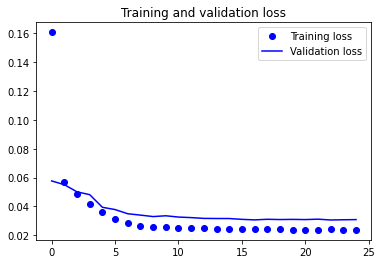

In [29]:
loss = running_loss_history
val_loss = val_running_loss_history

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("plot/train-valid-loss-resnet-50.jpg")
plt.show()

# **Model Validation**


**Validation on resnet 50**


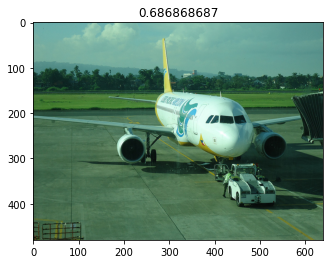

In [30]:
file = ""


def show_sample_from_dataset(i=0):
    global file

    def show_image(image, asethics_value=0):
        plt.imshow(image)
        plt.title(str(asethics_value))

    image_path = os.path.join("images/" + str(dataset_validation.iloc[i]["image"]))
    file = image_path
    mem_val = os.path.join(str(dataset_validation.iloc[i]["memorability_score"]))
    show_image(io.imread(image_path), mem_val)


show_sample_from_dataset()

In [31]:
image = None
from PIL import Image


def image_loader(loader, image_name):
    global image

    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)

    image = image.unsqueeze(0)
    return image


data_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
print(
    (resmodel_50(image_loader(data_transforms, file).double().to(device)).cpu().item())
)

-0.3208652956374516


/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_1716/622756029.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_1716/622756029.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


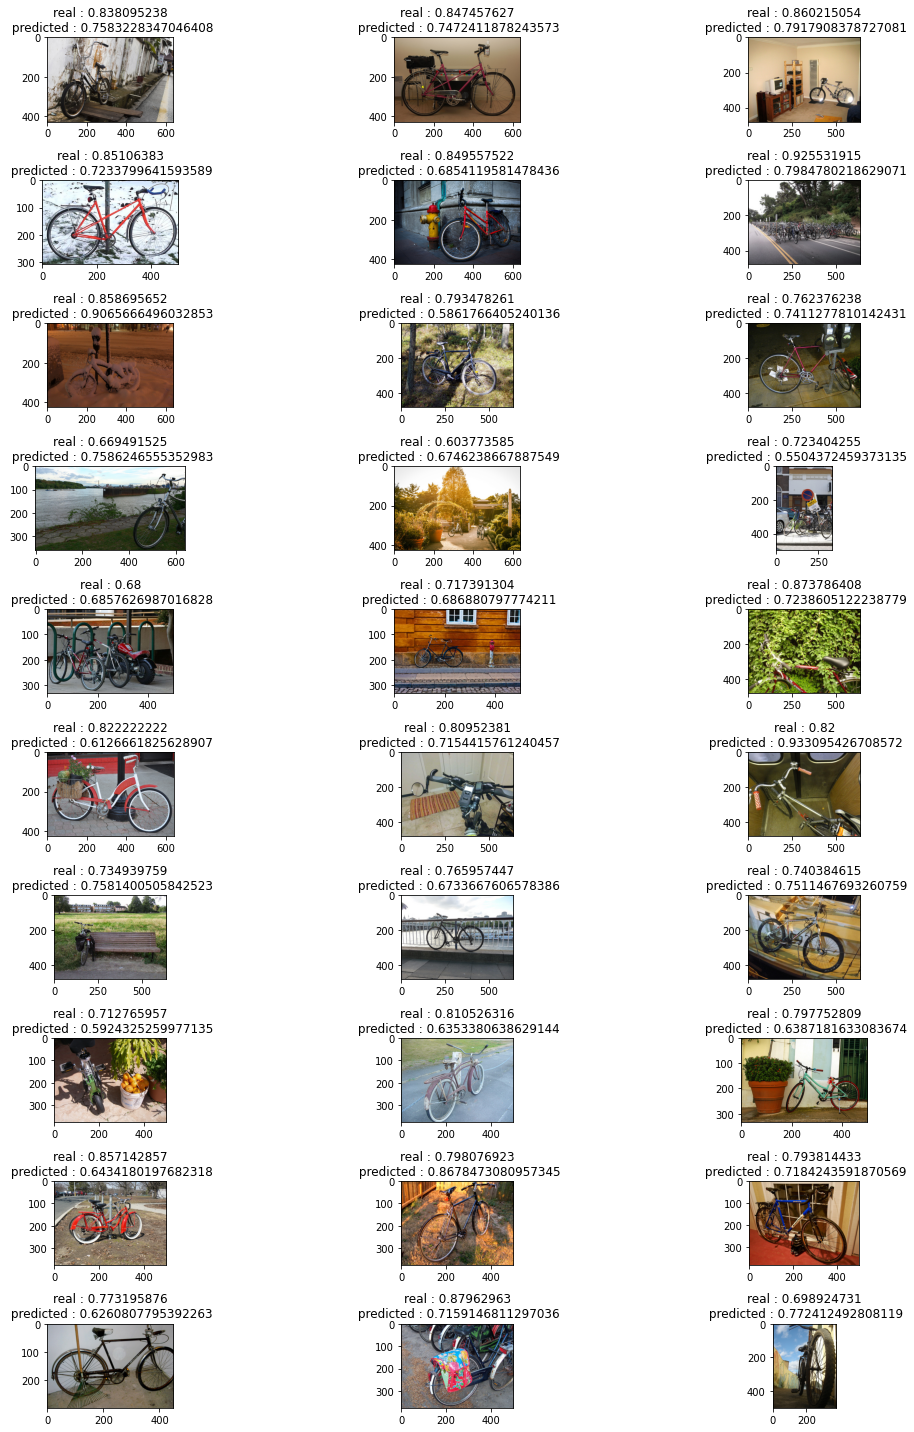

In [32]:
def show_grid(n_row, n_col):
    i = 100
    _, fig = plt.subplots(n_row, n_col, figsize=(20, 20))
    fig = fig.flatten()
    for f in fig:
        image_path = os.path.join("images/" + str(dataset_validation.iloc[i]["image"]))
        mem_val = os.path.join(str(dataset_validation.iloc[i]["memorability_score"]))
        pred = (
            best_model_50(image_loader(data_transforms, image_path).double().to(device))
            .cpu()
            .item()
        )
        f.imshow(io.imread(image_path))
        plt.tight_layout()
        f.title.set_text("real : " + str(mem_val) + "\n predicted : " + str(pred))
        i = i + 1


show_grid(10, 3)

In [33]:
best_model_50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
running_loss_history

[0.1607847366763649,
 0.056607281743967904,
 0.04826236091533115,
 0.04169494259254578,
 0.03587386156019889,
 0.031544039838147665,
 0.02814820818353152,
 0.026298498999495403,
 0.02567157622071684,
 0.02550705376428392,
 0.025197760659904134,
 0.02492544592687873,
 0.024750240983941855,
 0.024284376584199307,
 0.02398966062840176,
 0.024085240595922607,
 0.024118527617670357,
 0.023946936023211667,
 0.024005866528295512,
 0.023852308030459842,
 0.023764726422104854,
 0.02364837736744789,
 0.023938728323910995,
 0.023850026292384773,
 0.023887731255501227]

In [35]:
val_running_loss_history

[0.05764169898294034,
 0.05503155309574429,
 0.050046662765592026,
 0.048109319456998804,
 0.03934366164279488,
 0.03776832217679805,
 0.03486709023159299,
 0.03391908354417366,
 0.032905701859192796,
 0.03345871544863803,
 0.03256692309901172,
 0.03218957379068608,
 0.031643467070308504,
 0.0315654074027972,
 0.031547311073909755,
 0.030981938076518976,
 0.030609897398024454,
 0.031024659383391877,
 0.030843872722253907,
 0.03095052937089969,
 0.03082464668592119,
 0.031102611950949866,
 0.03052745844892945,
 0.030694418481265563,
 0.030801419807346526]

In [36]:
columns = {"name": "X", "score": "y"}
dataset_origin = pd.read_csv("../../data/dataset.csv")
dataset_origin.rename(columns=columns, inplace=True)

In [37]:
predictions = []

for index, row in dataset_origin.iterrows():
    image_path = os.path.join("semmem/" + str(row["image"]))
    mem_val = os.path.join(str(row["memorability_score"]))

    pred = (
        best_model_50(image_loader(data_transforms, image_path).double().to(device))
        .cpu()
        .item()
    )

    predictions.append(
        {"image": row["image"], "real": row["memorability_score"], "prediction": pred}
    )

/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_1716/622756029.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


In [38]:
image_list = []
real_list = []
prediction_list = []
image_type_list = []
for p in predictions:
    image_list.append(p["image"])
    real_list.append(p["real"])
    prediction_list.append(p["prediction"])

dataframe_dict = {"image": image_list, "real": real_list, "prediction": prediction_list}

df = pd.DataFrame(dataframe_dict)

df.to_csv("csv/predictions_resnet50_memcat.csv")